# $U(1)$ Gauge Model using L2HMC in graph mode

--------------------------------------------------------------------
### TODO:
* [ ] Look at performance on Cooley (longer training runs).
* [ ] Fit observables to Eq. \ref{eq:therm_time} to determine the thermalization time $\tau$.

\begin{equation} 
f(t) \equiv A \exp^{-t / \tau}+ \,\, B
\label{eq:therm_time}
\end{equation}
* [ ] Look at defining a distance metric as the difference in topological charge between two samples and see what effect adding this as an additional term to the loss function has on the models' ability to tunnel between topological sectors.

--------------------------------------------------------------------

In [3]:
import os
import sys
import time
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from scipy.special import i0, i1

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import utils.gauge_model_helpers as helpers
from utils.data_utils import (
    calc_avg_vals_errors, block_resampling, jackknife_err
)
from gauge_model import (
    GaugeModel, check_else_make_dir, save_params_to_pkl_file
)

tfe = tf.contrib.eager
%autoreload 2
%matplotlib notebook

#from gauge_model import GaugeModel
#%reload_ext gauge_model.GaugeModel
#from gauge_model import GaugeModel
#
#from dynamics.gauge_dynamics import GaugeDynamics
#%reload_ext dynamics.gauge_dynamics
#from dynamics.gauge_dynamics import GaugeDynamics

## Define parameters

In [4]:
tf.reset_default_graph()

In [5]:
params = {
#--------------------- Lattice parameters ----------------------------
    'time_size': 16,
    'space_size': 16,
    'link_type': 'U1',
    'dim': 2,
    'num_samples': 5,
    'rand': False,
    'data_format': 'channels_last',
#--------------------- Leapfrog parameters ---------------------------
    'num_steps': 1,
    'eps': 0.1,
    'loss_scale': 0.1,
    'loss_eps': 1e-4,
#--------------------- Learning rate parameters ----------------------
    'learning_rate_init': 1e-3,
    'learning_rate_decay_steps': 1000,
    'learning_rate_decay_rate': 0.96,
#--------------------- Annealing rate parameters ---------------------
    'annealing': True,
    'annealing_steps': 500,
    'annealing_factor': 0.9999,
    #'beta': 3.,
    'beta_init': 2.,
    'beta_final': 8.,
#--------------------- Training parameters ---------------------------
    'train_steps': 20000,
    'save_steps': 1000,
    'logging_steps': 50,
    'print_steps': 1,
    'training_samples_steps': 1000,
    'training_samples_length': 100,
#--------------------- Model parameters ------------------------------
    'conv_net': False,
    'hmc': False,
    'eps_trainable': True,
    'metric': 'l2',
    'aux': True,
    'clip_grads': False,
    'clip_value': 10.,
    'using_hvd': False
}

## Create model

In [6]:
os.environ["KMP_BLOCKTIME"] = str(0)
os.environ["KMP_SETTINGS"] = str(1)
os.environ["KMP_AFFINITY"] = "granularity=fine,verbose,compact,1,0"
os.environ["OMP_NUM_THREADS"] = str(2)
config = tf.ConfigProto()
tf.reset_default_graph()

In [7]:
model = GaugeModel(params=params, 
                   config=config,
                   sess=None,
                   log_dir=None,
                   restore=False)

save_params_to_pkl_file(params, model.info_dir)

Creating directory for new run: /Users/saforem2/ANL/l2hmc/gauge_logs_graph/run_101/
Creating directory: /Users/saforem2/ANL/l2hmc/gauge_logs_graph/run_101/samples_history
Creating directory: /Users/saforem2/ANL/l2hmc/gauge_logs_graph/run_101/samples_history/training
Creating directory: /Users/saforem2/ANL/l2hmc/gauge_logs_graph/run_101/train_samples
time_size: 16
space_size: 16
link_type: U1
dim: 2
num_samples: 5
rand: False
data_format: channels_last
num_steps: 1
eps: 0.1
loss_scale: 0.1
loss_eps: 0.0001
learning_rate_init: 0.001
learning_rate_decay_steps: 1000
learning_rate_decay_rate: 0.96
annealing: True
annealing_steps: 500
annealing_factor: 0.9999
beta_init: 2.0
beta_final: 8.0
train_steps: 20000
save_steps: 1000
logging_steps: 50
print_steps: 1
training_samples_steps: 1000
training_samples_length: 100
conv_net: False
hmc: False
eps_trainable: True
metric: l2
aux: True
clip_grads: False
clip_value: 10.0
using_hvd: False
------------------------------------------------------------

In [8]:
model.train(model.train_steps, kill_sess=False)

----------------------------------------------------------------------------------------------------
     STEP           LOSS       TIME/STEP      ACCEPT %        EPS           BETA           LR      
----------------------------------------------------------------------------------------------------
     0/20000    -1.587e+05       944.4        0.6893          0.1            2           0.001    
     1/20000    -6.724e+04      0.9808       0.001683        0.099           2           0.001    
     2/20000    -5.868e+04      0.6676          0.2         0.09814          2           0.001    
     3/20000    -1.953e+04      0.6223           0          0.09747        2.001         0.001    
     4/20000       1398         0.5732           0          0.09687        2.001         0.001    
     5/20000       1902          0.65            0          0.09635        2.001         0.001    
     6/20000       1484         0.6969           0          0.09588        2.001         0.001    
     

    80/20000    -6.015e+04       0.65            0          0.08275        2.016         0.001    
    81/20000    -5.989e+04      0.6635           0          0.08242        2.016         0.001    
    82/20000    -4.278e+04       0.745           0          0.08211        2.016         0.001    
    83/20000    -7.349e+04      0.6663           0          0.08181        2.017         0.001    
    84/20000    -4.014e+04       0.653           0          0.08145        2.017         0.001    
    85/20000       -9446        0.6858           0          0.08111        2.017         0.001    
    86/20000    -2.889e+04      0.6842           0          0.08074        2.017         0.001    
    87/20000     -7.19e+04      0.7017           0          0.08031        2.017         0.001    
    88/20000    -2.475e+04      0.7155           0          0.07985        2.018         0.001    
    89/20000    -2.043e+04      0.6233           0          0.07939        2.018         0.001    
    90/200

   163/20000    -1.049e+05      0.6509        0.4117        0.02354        2.033         0.001    
   164/20000    -1.089e+05      0.6696        0.6032        0.02226        2.033         0.001    
   165/20000    -9.574e+04      0.6601        0.4272        0.02103        2.033         0.001    
   166/20000    -7.875e+04      0.6411        0.4387        0.01983        2.033         0.001    
   167/20000    -1.025e+05      0.6468        0.7306        0.0185         2.034         0.001    
   168/20000     -9.02e+04      0.6638        0.5357        0.0172         2.034         0.001    
   169/20000    -1.048e+05      0.6781        0.7497        0.01586        2.034         0.001    
   170/20000    -1.046e+05      0.6747        0.8897        0.01452        2.034         0.001    
   171/20000    -9.699e+04      0.6247        0.7327        0.01323        2.034         0.001    
   172/20000    -9.692e+04      0.6447        0.6514        0.01191        2.035         0.001    
   173/200

   246/20000    -9.921e+04       0.642        0.9962       0.0006652       2.05          0.001    
   247/20000    -1.007e+05      0.6623        0.9987       0.000774        2.05          0.001    
   248/20000    -1.037e+05      0.6159        0.9926       0.0008089       2.05          0.001    
   249/20000     -1.01e+05      0.6499        0.9857       0.000874        2.05          0.001    
   250/20000    -1.039e+05      0.6395        0.9967       0.0008559       2.051         0.001    
   251/20000    -1.028e+05      0.6614        0.9992       0.000764        2.051         0.001    
   252/20000    -9.854e+04       0.933         0.992       0.0006055       2.051         0.001    
   253/20000    -1.013e+05      0.6973         0.993       0.0004594       2.051         0.001    
   254/20000    -9.894e+04      0.7005        0.9959       0.000333        2.051         0.001    
   255/20000    -1.003e+05      0.6492        0.9953       0.0003331       2.052         0.001    
   256/200

   329/20000    -1.001e+05      0.7253           1         0.0005343       2.067         0.001    
   330/20000     -9.97e+04      0.6667        0.9934       0.0006019       2.067         0.001    
   331/20000    -9.906e+04      0.6993        0.9981       0.0006713       2.067         0.001    
   332/20000    -9.661e+04      0.6608        0.9904        0.00081        2.068         0.001    
   333/20000    -1.037e+05      0.6228        0.9989       0.0009097       2.068         0.001    
   334/20000    -1.023e+05      0.6362        0.9899       0.0009884       2.068         0.001    
   335/20000    -1.006e+05      0.6574        0.9896       0.001039        2.068         0.001    
   336/20000     -1.01e+05      0.6362        0.9885       0.001016        2.068         0.001    
   337/20000    -1.015e+05      0.6511        0.9989       0.0009983       2.069         0.001    
   338/20000    -9.962e+04      0.6414        0.9899       0.0009496       2.069         0.001    
   339/200

   412/20000    -1.011e+05      0.6588        0.9833       0.0008379       2.084         0.001    
   413/20000    -1.034e+05       0.674        0.9736       0.0008162       2.084         0.001    
   414/20000    -1.013e+05      0.7385        0.9709       0.0007401       2.085         0.001    
   415/20000     -1.04e+05      0.6742        0.9896       0.0006157       2.085         0.001    
   416/20000     -1.02e+05      0.7035        0.9911       0.0004136       2.085         0.001    
   417/20000    -9.834e+04      0.6423        0.9964       0.0001983       2.085         0.001    
   418/20000    -9.909e+04      0.6481        0.9849       0.000338        2.085         0.001    
   419/20000    -1.033e+05      0.6646         0.982       0.0004141       2.086         0.001    
   420/20000     -1.01e+05      0.6467        0.9836       0.0004255       2.086         0.001    
   421/20000     -1.01e+05      0.6334        0.9941       0.0004465       2.086         0.001    
   422/200

   495/20000     -1.04e+05       0.698        0.9581      -0.0008885       2.101         0.001    
   496/20000     -1.07e+05      0.6897        0.8964       -0.001186       2.102         0.001    
   497/20000    -1.065e+05      0.6288        0.8561       -0.001368       2.102         0.001    
   498/20000    -1.044e+05      0.6498        0.9681       -0.00148        2.102         0.001    
   499/20000    -9.927e+04      0.6564        0.8451       -0.001533       2.102         0.001    
   500/20000    -1.043e+05      0.6477        0.8584       -0.001519       2.103         0.001    
   501/20000    -1.024e+05      0.6351        0.8924       -0.001417       2.103         0.001    
   502/20000    -1.065e+05      0.6689        0.9061       -0.001258       2.103         0.001    
   503/20000    -1.001e+05      0.6387        0.9041       -0.001048       2.103         0.001    
   504/20000    -1.034e+05      0.6379        0.8872      -0.0007794       2.103         0.001    
   505/200

   578/20000    -1.009e+05      0.6124           1        -0.0003179       2.119         0.001    
   579/20000    -1.039e+05      0.5992           1        -0.0003853       2.119         0.001    
   580/20000    -1.017e+05      0.6234         0.958      -0.0004974       2.119         0.001    
   581/20000     -1.02e+05      0.6327        0.9514      -0.0006094       2.12          0.001    
   582/20000    -1.012e+05      0.6721           1        -0.0007058       2.12          0.001    
   583/20000    -1.018e+05      0.6448        0.9629      -0.0007597       2.12          0.001    
   584/20000    -1.018e+05       0.679        0.9807      -0.0007886       2.12          0.001    
   585/20000    -9.827e+04      0.6638         0.952      -0.0007996       2.12          0.001    
   586/20000    -1.014e+05      0.6155        0.9434      -0.0007792       2.121         0.001    
   587/20000    -1.007e+05      0.6639        0.9593      -0.0007351       2.121         0.001    
   588/200

   661/20000    -1.025e+05      0.9998        0.9792      -0.0002711       2.137         0.001    
   662/20000    -1.007e+05      0.8797         0.973       -0.00038        2.137         0.001    
   663/20000    -9.898e+04      0.7806        0.9795      -0.0004633       2.137         0.001    
   664/20000    -1.049e+05      0.6769        0.9737      -0.0005291       2.137         0.001    
   665/20000    -1.007e+05      0.8942        0.9912       -0.000543       2.138         0.001    
   666/20000    -1.046e+05      0.6708        0.9778      -0.0005291       2.138         0.001    
   667/20000    -1.024e+05       0.717        0.9736      -0.0005188       2.138         0.001    
   668/20000    -1.009e+05      0.8984           1        -0.0005005       2.138         0.001    
   669/20000    -1.017e+05      0.7472        0.9738      -0.0004339       2.138         0.001    
   670/20000    -1.016e+05      0.7404         0.982      -0.0003642       2.139         0.001    
   671/200

   744/20000     -1.03e+05      0.5943        0.9413       -0.001779       2.154         0.001    
   745/20000    -1.029e+05      0.5982        0.8816       -0.001677       2.155         0.001    
   746/20000    -9.983e+04      0.6479        0.9613       -0.001528       2.155         0.001    
   747/20000     -1.04e+05      0.6962        0.9486       -0.001371       2.155         0.001    
   748/20000    -1.046e+05      0.7275        0.9447       -0.001202       2.155         0.001    
   749/20000    -1.041e+05      0.7445        0.9384      -0.0009749       2.156         0.001    
   750/20000    -9.803e+04      0.7116        0.9621      -0.0007453       2.156         0.001    
   751/20000    -1.006e+05      0.6939        0.9705      -0.0005061       2.156         0.001    
   752/20000    -9.887e+04      0.6443        0.9765      -0.0002853       2.156         0.001    
   753/20000    -1.016e+05      0.6903        0.9972      -0.0001273       2.156         0.001    
   754/200

   827/20000    -1.017e+05      0.6688         0.977      -0.0008964       2.172         0.001    
   828/20000    -1.001e+05      0.7583        0.9463      -0.0009673       2.173         0.001    
   829/20000    -1.026e+05      0.6503        0.9746      -0.0009861       2.173         0.001    
   830/20000    -9.946e+04        0.6         0.9928      -0.0009734       2.173         0.001    
   831/20000    -9.931e+04      0.6681        0.9745      -0.0009576       2.173         0.001    
   832/20000    -1.021e+05      0.6438        0.9874      -0.0008995       2.174         0.001    
   833/20000    -1.054e+05      0.6775        0.9657      -0.0008189       2.174         0.001    
   834/20000    -9.913e+04      0.6533        0.9596       -0.00071        2.174         0.001    
   835/20000    -1.015e+05      0.6923        0.9723      -0.0005951       2.174         0.001    
   836/20000    -1.011e+05      0.7108        0.9897      -0.0004947       2.174         0.001    
   837/200

   910/20000    -1.023e+05      0.6546           1        -0.0003788       2.191         0.001    
   911/20000    -9.777e+04      0.6634        0.9935       -0.000326       2.191         0.001    
   912/20000      -1e+05        0.6968        0.9943      -0.0002821       2.191         0.001    
   913/20000    -1.008e+05      0.6634         0.995      -0.0002557       2.191         0.001    
   914/20000    -9.964e+04      0.6338        0.9956      -0.0003257       2.191         0.001    
   915/20000    -1.039e+05      0.6748        0.9891      -0.0004035       2.192         0.001    
   916/20000    -1.018e+05       0.638        0.9961      -0.0004491       2.192         0.001    
   917/20000    -1.016e+05      0.6425         0.986       -0.000487       2.192         0.001    
   918/20000    -9.865e+04      0.6435        0.9908      -0.0004876       2.192         0.001    
   919/20000    -1.022e+05      0.6594        0.9849      -0.0003889       2.193         0.001    
   920/200

   993/20000     -9.86e+04      0.6761        0.9436      -0.0009482       2.209         0.001    
   994/20000    -1.024e+05      0.6562        0.9748      -0.0009383       2.209         0.001    
   995/20000    -9.984e+04      0.6677        0.9156      -0.0009149       2.209         0.001    
   996/20000    -1.017e+05      0.6413        0.9689      -0.0008968       2.209         0.001    
   997/20000    -1.032e+05       0.65         0.9513      -0.0008833       2.21          0.001    
   998/20000    -1.007e+05       0.695        0.9846      -0.0008937       2.21          0.001    
Saving checkpoint to: /Users/saforem2/ANL/l2hmc/gauge_logs_graph/run_101/model.ckpt
   999/20000    -1.014e+05       1.134        0.9835       -0.000911       2.21          0.001    


NameError: name 'hvd' is not defined

In [14]:
model.train(model.train_steps, pre_train=False, kill_sess=False, trace=False)

----------------------------------------------------------------------------------------------------
     STEP           LOSS       TIME/STEP      ACCEPT %        EPS           BETA           LR      
----------------------------------------------------------------------------------------------------
   999/20000    -2.062e+05      0.7769        0.9999      -0.0006722         2          0.00096   
--------------------------------------------------------------------------------

Evaluating sampler for 100 steps at beta = 8.0.
Running (trained) L2HMC sampler for 100 steps...
step:      0/100    accept prob (avg):  0.9997   step size: -0.0005351 	 time/step: 0.1977

accept prob: [1.         1.         1.         0.99858797 1.        ]


step:     10/100    accept prob (avg):  0.6882   step size: -0.0005351 	 time/step: 0.1443

accept prob: [0.5080402  0.3976927  1.         0.53535163 1.        ]


step:     20/100    accept prob (avg):  0.9507   step size: -0.0005351 	 time/step: 0.1396



  1053/20000    -1.039e+05      0.5989        0.9542       -0.00117        2.011        0.00096   
  1054/20000    -1.077e+05      0.6126        0.9828       -0.001137       2.011        0.00096   
  1055/20000    -1.053e+05      0.5781        0.9833       -0.001053       2.011        0.00096   
  1056/20000    -1.066e+05      0.5952        0.9847      -0.0009508       2.011        0.00096   
  1057/20000    -1.079e+05      0.6048        0.9833      -0.0008376       2.012        0.00096   
  1058/20000    -1.028e+05      0.8412        0.9882      -0.0007046       2.012        0.00096   
  1059/20000    -1.027e+05      0.7368        0.9947      -0.0005657       2.012        0.00096   
  1060/20000    -1.044e+05      0.7691        0.9915      -0.0004306       2.012        0.00096   
  1061/20000    -1.017e+05      0.7167        0.9913      -0.0003064       2.012        0.00096   
  1062/20000    -1.016e+05      0.6693        0.9964      -0.0001853       2.013        0.00096   
  1063/200

  1136/20000    -1.086e+05      0.7198        0.9908      -0.0006314       2.028        0.00096   
  1137/20000    -1.066e+05      0.6466        0.9891      -0.0005529       2.028        0.00096   
  1138/20000    -1.049e+05      0.6912        0.9947      -0.0004698       2.028        0.00096   
  1139/20000    -1.037e+05      0.7103        0.9943      -0.0003663       2.028        0.00096   
  1140/20000    -9.978e+04      0.6753         0.994      -0.0002924       2.028        0.00096   
  1141/20000    -1.029e+05      0.8098        0.9965      -0.0002092       2.029        0.00096   
  1142/20000     -1.01e+05      0.6751        0.9979      -0.0002052       2.029        0.00096   
  1143/20000    -1.055e+05      0.6067        0.9991      -0.0001934       2.029        0.00096   
  1144/20000    -1.008e+05      0.5777        0.9987      -0.0002651       2.029        0.00096   
  1145/20000     -1.04e+05      0.6134        0.9951      -0.0003122       2.029        0.00096   
  1146/200

  1219/20000    -1.108e+05      0.7931        0.9871       0.001197        2.044        0.00096   
  1220/20000    -1.078e+05      0.6834        0.9916       0.001061        2.045        0.00096   
  1221/20000    -1.075e+05      0.7192         0.995       0.0009282       2.045        0.00096   
  1222/20000    -1.036e+05      0.7357         0.987       0.0007892       2.045        0.00096   
  1223/20000    -1.024e+05      0.7436           1         0.0006382       2.045        0.00096   
  1224/20000     -1.01e+05      0.7717        0.9908       0.0004746       2.046        0.00096   
  1225/20000    -1.028e+05      0.7103        0.9936       0.0003137       2.046        0.00096   
  1226/20000     -1.07e+05      0.7091         0.998       0.0001367       2.046        0.00096   
  1227/20000    -1.027e+05      0.7296        0.9958       0.0002429       2.046        0.00096   
  1228/20000    -1.012e+05      0.7676        0.9915       0.0003334       2.046        0.00096   
  1229/200

  1302/20000    -1.022e+05      0.6844        0.9961       0.0003198       2.062        0.00096   
  1303/20000    -1.009e+05      0.7146        0.9999       0.0002517       2.062        0.00096   
  1304/20000    -1.002e+05      0.6967        0.9992       0.0001751       2.062        0.00096   
  1305/20000    -1.005e+05      0.6948        0.9992       0.0002104       2.062        0.00096   
  1306/20000    -1.027e+05      0.6711        0.9986       0.0001377       2.062        0.00096   
  1307/20000    -1.018e+05       0.668        0.9991       0.000194        2.063        0.00096   
  1308/20000    -1.038e+05      0.7003           1         0.0003223       2.063        0.00096   
  1309/20000     -1.04e+05      0.6934        0.9967       0.0004248       2.063        0.00096   
  1310/20000    -1.017e+05      0.6824        0.9941       0.0005143       2.063        0.00096   
  1311/20000    -1.023e+05      0.7324        0.9953       0.0005808       2.063        0.00096   
  1312/200

  1385/20000    -1.046e+05      0.7072        0.9967       0.0004473       2.079        0.00096   
  1386/20000    -1.031e+05       0.727        0.9993       0.0003313       2.079        0.00096   
  1387/20000    -1.009e+05      0.6783        0.9998       0.0001997       2.079        0.00096   
  1388/20000    -9.878e+04      0.7205        0.9999       6.832e-05       2.079        0.00096   
  1389/20000    -1.029e+05      0.7037        0.9993       0.0002709       2.08         0.00096   
  1390/20000     -1.01e+05      0.6869        0.9993       0.0004229       2.08         0.00096   
  1391/20000    -9.762e+04      0.6796        0.9981       0.000543        2.08         0.00096   
  1392/20000    -1.033e+05       0.643        0.9956       0.0006319       2.08         0.00096   
  1393/20000    -1.033e+05       0.698        0.9973       0.0007017       2.08         0.00096   
  1394/20000    -1.041e+05      0.7005        0.9941        0.00074        2.081        0.00096   
  1395/200

  1468/20000    -1.044e+05       0.669        0.9987       0.0005842       2.096        0.00096   
  1469/20000     -1.01e+05      0.6737        0.9981       0.0004909       2.096        0.00096   
  1470/20000    -1.055e+05      0.7365        0.9975       0.0003947       2.096        0.00096   
  1471/20000    -1.041e+05      0.7319        0.9991       0.0002905       2.097        0.00096   
  1472/20000    -1.016e+05      0.7513        0.9995       0.0001754       2.097        0.00096   
  1473/20000    -9.892e+04      0.7051        0.9993       0.0003071       2.097        0.00096   
  1474/20000    -1.018e+05      0.7182        0.9994       0.0004131       2.097        0.00096   
  1475/20000    -1.024e+05      0.7561        0.9994       0.0005078       2.098        0.00096   
  1476/20000    -1.028e+05      0.7405        0.9983       0.000582        2.098        0.00096   
  1477/20000    -1.056e+05      0.7115        0.9975       0.0006401       2.098        0.00096   
  1478/200

  1551/20000    -1.068e+05      0.7238         0.998       0.000931        2.114        0.00096   
  1552/20000    -1.062e+05      0.6985        0.9968       0.0009384       2.114        0.00096   
  1553/20000    -1.068e+05      0.6504        0.9983       0.0009266       2.114        0.00096   
  1554/20000    -1.035e+05      0.6871        0.9965       0.0009137       2.114        0.00096   
  1555/20000    -1.042e+05      0.7199        0.9956       0.0008663       2.114        0.00096   
  1556/20000     -1.03e+05      0.7482        0.9981       0.0008149       2.115        0.00096   
  1557/20000    -1.045e+05      0.7691        0.9947       0.0007583       2.115        0.00096   
  1558/20000     -1.04e+05      0.6469        0.9957       0.0006973       2.115        0.00096   
  1559/20000    -1.014e+05      0.6789        0.9979       0.0006333       2.115        0.00096   
  1560/20000    -1.055e+05      0.6855        0.9969       0.0005663       2.115        0.00096   
  1561/200

  1634/20000    -1.033e+05      0.7359        0.9957       0.0003988       2.131        0.00096   
  1635/20000    -1.027e+05      0.7346        0.9941       0.0003946       2.131        0.00096   
  1636/20000    -1.025e+05      0.7963        0.9963       0.0003532       2.132        0.00096   
  1637/20000    -1.023e+05      0.6876        0.9967       0.0003025       2.132        0.00096   
  1638/20000    -1.011e+05      0.7574        0.9978       0.0002488       2.132        0.00096   
  1639/20000    -1.018e+05      0.7121        0.9976       0.0002633       2.132        0.00096   
  1640/20000    -1.031e+05      0.6803        0.9942       0.0002729       2.132        0.00096   
  1641/20000     -1.04e+05      0.7164        0.9975       0.0003589       2.133        0.00096   
  1642/20000    -1.027e+05      0.6873        0.9966       0.0004931       2.133        0.00096   
  1643/20000    -1.039e+05      0.6127        0.9921       0.0005912       2.133        0.00096   
  1644/200

  1717/20000    -1.059e+05      0.8794        0.9972       0.0005062       2.149        0.00096   
  1718/20000     -9.93e+04      0.8079        0.9991       0.0004252       2.149        0.00096   
  1719/20000    -1.041e+05      0.7748           1         0.000333        2.149        0.00096   
  1720/20000    -1.006e+05      0.7855        0.9986       0.0003066       2.15         0.00096   
  1721/20000    -1.005e+05      0.5888        0.9985       0.0002717       2.15         0.00096   
  1722/20000    -9.953e+04      0.6775        0.9958       0.0003288       2.15         0.00096   
  1723/20000    -1.024e+05      0.7404        0.9962       0.000343        2.15         0.00096   
  1724/20000    -1.029e+05      0.6817        0.9976       0.0003397       2.15         0.00096   
  1725/20000    -1.039e+05      0.6194         0.999       0.0003808       2.151        0.00096   
  1726/20000    -1.003e+05      0.6614        0.9977       0.0003972       2.151        0.00096   
  1727/200

  1800/20000    -1.032e+05      0.7569        0.9958       0.0004493       2.167        0.00096   
  1801/20000    -1.017e+05      0.6528        0.9966       0.0004691       2.167        0.00096   
  1802/20000     -1.03e+05       0.654        0.9962       0.0004653       2.167        0.00096   
  1803/20000    -9.932e+04      0.7711        0.9984       0.000448        2.167        0.00096   
  1804/20000    -1.036e+05      0.7294        0.9978       0.0004312       2.168        0.00096   
  1805/20000    -1.018e+05      0.7237        0.9964       0.0004027       2.168        0.00096   
  1806/20000     -1.02e+05      0.7072        0.9974       0.0003523       2.168        0.00096   
  1807/20000    -1.007e+05      0.7388        0.9978       0.0002978       2.168        0.00096   
  1808/20000    -1.028e+05      0.7299         0.999       0.0002386       2.169        0.00096   
  1809/20000    -1.015e+05      0.7353        0.9975       0.0002843       2.169        0.00096   
  1810/200

  1883/20000    -1.065e+05      0.6497        0.9986       0.0005042       2.185        0.00096   
  1884/20000    -1.059e+05      0.6545        0.9984       0.0004526       2.185        0.00096   
  1885/20000    -9.932e+04      0.6529           1         0.0003979       2.185        0.00096   
  1886/20000    -9.837e+04       0.64         0.9993       0.0003409       2.186        0.00096   
  1887/20000    -1.006e+05      0.6464         0.999       0.0002803       2.186        0.00096   
  1888/20000    -1.008e+05      0.5596        0.9985       0.0003963       2.186        0.00096   
  1889/20000    -1.017e+05      0.5724        0.9988       0.0004804       2.186        0.00096   
  1890/20000    -1.006e+05      0.6589        0.9972       0.0005414       2.186        0.00096   
  1891/20000    -1.032e+05      0.6593        0.9979       0.0005715       2.187        0.00096   
  1892/20000    -1.005e+05      0.7241        0.9986       0.0005824       2.187        0.00096   
  1893/200

  1966/20000    -1.013e+05      0.7543        0.9932       0.000378        2.203        0.00096   
  1967/20000    -1.059e+05       0.696        0.9941       0.0004261       2.203        0.00096   
  1968/20000    -1.037e+05      0.6918        0.9937       0.0004627       2.204        0.00096   
  1969/20000    -1.022e+05      0.6615        0.9869       0.0004905       2.204        0.00096   
  1970/20000    -1.028e+05      0.6405        0.9865       0.0005282       2.204        0.00096   
  1971/20000    -9.772e+04      0.7066        0.9938       0.0005683       2.204        0.00096   
  1972/20000    -1.021e+05      0.6609        0.9808       0.000592        2.204        0.00096   
  1973/20000    -1.007e+05      0.6946         0.988       0.0005775       2.205        0.00096   
  1974/20000    -1.029e+05      0.6719        0.9944       0.000545        2.205        0.00096   
  1975/20000    -1.014e+05      0.7401         0.992       0.0005097       2.205        0.00096   
  1976/200

  2022/20000    -1.027e+05      0.6322        0.9979       0.0006977       2.215       0.0009216  
  2023/20000    -1.061e+05      0.6328        0.9924       0.0007733       2.216       0.0009216  
  2024/20000    -1.002e+05      0.6433        0.9981       0.0008291       2.216       0.0009216  
  2025/20000    -1.039e+05       0.694        0.9913       0.0008803       2.216       0.0009216  
  2026/20000    -1.031e+05      0.9802        0.9988       0.0009115       2.216       0.0009216  
  2027/20000    -1.034e+05      0.8946        0.9984       0.0009271       2.217       0.0009216  
  2028/20000    -1.044e+05      0.6789        0.9926       0.0009303       2.217       0.0009216  
  2029/20000    -1.038e+05       0.623        0.9954       0.0009103       2.217       0.0009216  
  2030/20000    -1.007e+05      0.6223        0.9911       0.0008854       2.217       0.0009216  
  2031/20000    -1.004e+05      0.6227        0.9958       0.0008493       2.217       0.0009216  
  2032/200

  2105/20000    -1.035e+05      0.6869        0.9817       0.001161        2.234       0.0009216  
  2106/20000    -1.011e+05      0.7381        0.9697       0.001134        2.234       0.0009216  
  2107/20000    -1.019e+05      0.7296        0.9949       0.001068        2.234       0.0009216  
  2108/20000    -1.085e+05      0.6759        0.9877       0.0009901       2.235       0.0009216  
  2109/20000    -9.936e+04      0.8683        0.9916       0.0008918       2.235       0.0009216  
  2110/20000    -1.022e+05      0.7272        0.9872       0.0007896       2.235       0.0009216  
  2111/20000    -1.033e+05      0.7211         0.998       0.000662        2.235       0.0009216  
  2112/20000    -1.069e+05       1.044        0.9972       0.0005317       2.235       0.0009216  
  2113/20000     -1.02e+05       1.006        0.9979       0.0004343       2.236       0.0009216  
  2114/20000    -1.027e+05      0.8161        0.9999       0.000393        2.236       0.0009216  
  2115/200

  2188/20000    -1.014e+05      0.6595        0.9951       0.0007348       2.253       0.0009216  
  2189/20000    -1.032e+05      0.7506        0.9928       0.0007585       2.253       0.0009216  
  2190/20000    -1.016e+05      0.6919        0.9887       0.0007613       2.253       0.0009216  
  2191/20000     -1.05e+05      0.6395        0.9992       0.0007437       2.253       0.0009216  
  2192/20000    -1.028e+05      0.6708        0.9935       0.0007189       2.253       0.0009216  
  2193/20000    -1.031e+05      0.6046         0.991       0.0006789       2.254       0.0009216  
  2194/20000    -1.024e+05      0.5802        0.9939       0.0006368       2.254       0.0009216  
  2195/20000    -1.018e+05      0.6285        0.9965       0.0005731       2.254       0.0009216  
  2196/20000    -1.021e+05      0.6763        0.9926       0.0005086       2.254       0.0009216  
  2197/20000    -1.035e+05      0.7426         0.994       0.0004592       2.255       0.0009216  
  2198/200

  2271/20000    -1.036e+05      0.6712        0.9942       0.0005184       2.271       0.0009216  
  2272/20000    -9.882e+04      0.6989         0.998       0.0005725       2.272       0.0009216  
  2273/20000    -1.023e+05      0.6835        0.9942       0.000602        2.272       0.0009216  
  2274/20000    -1.027e+05      0.7214        0.9936       0.0006309       2.272       0.0009216  
  2275/20000    -1.004e+05      0.6786        0.9948       0.0006647       2.272       0.0009216  
  2276/20000    -1.011e+05      0.6882        0.9955       0.0006921       2.272       0.0009216  
  2277/20000    -1.004e+05      0.6958        0.9967       0.0007096       2.273       0.0009216  
  2278/20000    -1.023e+05      0.6604        0.9981       0.0007023       2.273       0.0009216  
  2279/20000    -9.827e+04      0.6834        0.9948       0.0006789       2.273       0.0009216  
  2280/20000    -9.934e+04      0.7858        0.9944       0.000646        2.273       0.0009216  
  2281/200

  2354/20000    -1.027e+05      0.7202        0.9796       0.0009718       2.29        0.0009216  
  2355/20000    -1.026e+05      0.6333           1         0.001051        2.29        0.0009216  
  2356/20000    -1.027e+05      0.7134        0.9738       0.001112        2.291       0.0009216  
  2357/20000    -1.041e+05      0.6879        0.9727       0.001124        2.291       0.0009216  
  2358/20000    -1.025e+05      0.7249           1         0.001075        2.291       0.0009216  
  2359/20000    -1.022e+05      0.6686        0.9934       0.001024        2.291       0.0009216  
  2360/20000    -1.025e+05      0.6539        0.9974       0.0009644       2.292       0.0009216  
  2361/20000    -1.039e+05      0.6896        0.9954        0.0009         2.292       0.0009216  
  2362/20000    -9.874e+04      0.6651        0.9922       0.0008137       2.292       0.0009216  
  2363/20000    -1.015e+05      0.7271        0.9905       0.000721        2.292       0.0009216  
  2364/200

  2437/20000    -1.013e+05      0.6822        0.9934       0.0006732       2.309       0.0009216  
  2438/20000    -1.007e+05      0.6443         0.993       0.0006508       2.31        0.0009216  
  2439/20000    -1.038e+05      0.6932         0.99        0.000615        2.31        0.0009216  
  2440/20000    -1.017e+05      0.6764         0.996       0.0005628       2.31        0.0009216  
  2441/20000    -9.936e+04      0.6934        0.9932       0.0005005       2.31        0.0009216  
  2442/20000    -1.024e+05      0.6747        0.9911       0.0004611       2.31        0.0009216  
  2443/20000    -1.028e+05      0.6472        0.9959       0.0003993       2.311       0.0009216  
  2444/20000    -9.771e+04      0.6663        0.9978       0.0004297       2.311       0.0009216  
  2445/20000    -1.032e+05      0.6503        0.9942       0.0004919       2.311       0.0009216  
  2446/20000    -1.009e+05      0.6533         0.997       0.0005322       2.311       0.0009216  
  2447/200

  2520/20000    -1.024e+05       0.77         0.9931       0.0004898       2.329       0.0009216  
  2521/20000    -9.795e+04      0.7696        0.9917       0.0004705       2.329       0.0009216  
  2522/20000    -1.032e+05      0.8101        0.9945       0.0004714       2.329       0.0009216  
  2523/20000    -1.002e+05      0.7322        0.9977       0.0004754       2.329       0.0009216  
  2524/20000    -9.898e+04      0.7314        0.9908       0.0005026       2.33        0.0009216  
  2525/20000    -1.028e+05      0.7227        0.9884       0.0005433       2.33        0.0009216  
  2526/20000    -1.026e+05      0.8426        0.9882       0.000578        2.33        0.0009216  
  2527/20000     -1.02e+05       0.676        0.9911       0.0005891       2.33        0.0009216  
  2528/20000    -9.848e+04      0.6713        0.9911       0.0005983       2.33        0.0009216  
  2529/20000    -1.045e+05       0.687        0.9865       0.0005952       2.331       0.0009216  
  2530/200

  2603/20000     -1.01e+05      0.6856         0.997       0.0006624       2.348       0.0009216  
  2604/20000    -1.054e+05      0.7034         0.99        0.0007282       2.348       0.0009216  
  2605/20000    -1.015e+05      0.7285        0.9893        0.00077        2.348       0.0009216  
  2606/20000    -9.958e+04      0.7077        0.9826       0.0007845       2.349       0.0009216  
  2607/20000    -1.015e+05      0.7419        0.9924       0.0007643       2.349       0.0009216  
  2608/20000    -1.037e+05      0.6607        0.9847       0.0007112       2.349       0.0009216  
  2609/20000    -1.002e+05      0.6696        0.9944       0.0006361       2.349       0.0009216  
  2610/20000    -1.035e+05       0.731        0.9885       0.0005223       2.35        0.0009216  
  2611/20000    -1.027e+05      0.6599        0.9977       0.0004193       2.35        0.0009216  
  2612/20000    -1.011e+05      0.7215        0.9951       0.0003096       2.35        0.0009216  
  2613/200

  2686/20000    -1.031e+05       0.647        0.9899       0.000445        2.368       0.0009216  
  2687/20000    -1.022e+05      0.6572        0.9907       0.0005543       2.368       0.0009216  
  2688/20000    -9.992e+04      0.6893        0.9926       0.0006708       2.368       0.0009216  
  2689/20000    -1.031e+05      0.6906        0.9918       0.0007771       2.368       0.0009216  
  2690/20000    -1.018e+05      0.6558        0.9794       0.0008446       2.368       0.0009216  
  2691/20000    -1.016e+05      0.6306        0.9761       0.0008819       2.369       0.0009216  
  2692/20000    -1.012e+05      0.6581        0.9715       0.0008937       2.369       0.0009216  
  2693/20000    -1.064e+05      0.7319        0.9867       0.0008755       2.369       0.0009216  
  2694/20000    -1.034e+05      0.6671        0.9985       0.0008164       2.369       0.0009216  
  2695/20000     -1.02e+05      0.5848        0.9941       0.0007424       2.37        0.0009216  
  2696/200

  2769/20000    -1.014e+05       1.123        0.9968       0.0003886       2.387       0.0009216  
  2770/20000    -1.003e+05      0.8538        0.9948       0.0003998       2.388       0.0009216  
  2771/20000     -1.02e+05      0.9652        0.9875       0.0004676       2.388       0.0009216  
  2772/20000    -1.031e+05      0.6947        0.9864       0.0005273       2.388       0.0009216  
  2773/20000    -9.803e+04      0.6946        0.9928       0.000539        2.388       0.0009216  
  2774/20000    -1.009e+05      0.8187        0.9864       0.0005287       2.388       0.0009216  
  2775/20000    -9.927e+04      0.6641        0.9819        0.0005         2.389       0.0009216  
  2776/20000    -9.829e+04      0.7179        0.9863       0.0005033       2.389       0.0009216  
  2777/20000    -1.048e+05       1.073        0.9925       0.0004945       2.389       0.0009216  
  2778/20000    -9.936e+04      0.7517        0.9872       0.0004781       2.389       0.0009216  
  2779/200

  2852/20000     -1.01e+05      0.7072        0.8158       0.001742        2.407       0.0009216  
  2853/20000    -1.022e+05      0.6954        0.8953       0.001431        2.407       0.0009216  
  2854/20000     -1.01e+05      0.8722        0.9078       0.001094        2.408       0.0009216  
  2855/20000    -1.026e+05      0.7976           1         0.0007158       2.408       0.0009216  
  2856/20000    -1.028e+05      0.9011        0.9895       0.000356        2.408       0.0009216  
  2857/20000      -1e+05        0.9837        0.9897       9.464e-05       2.408       0.0009216  
  2858/20000    -9.960e+04      0.9172         0.969       0.0003715       2.409       0.0009216  
  2859/20000    -9.868e+04      0.8335           1         0.0006674       2.409       0.0009216  
  2860/20000    -1.049e+05      0.7225        0.9157       0.0009737       2.409       0.0009216  
  2861/20000    -1.054e+05       1.156        0.9377       0.001189        2.409       0.0009216  
  2862/200

  2935/20000    -1.084e+05      0.6602        0.9885       0.0007828       2.427       0.0009216  
  2936/20000    -1.035e+05      0.6067         0.993       0.000748        2.427       0.0009216  
  2937/20000    -1.015e+05       0.749        0.9919       0.0007033       2.428       0.0009216  
  2938/20000    -1.015e+05      0.6816        0.9941       0.0006537       2.428       0.0009216  
  2939/20000    -1.027e+05      0.6872        0.9958       0.0005865       2.428       0.0009216  
  2940/20000    -9.968e+04      0.6682        0.9973       0.0005522       2.428       0.0009216  
  2941/20000    -1.011e+05       0.709         0.997       0.0005528       2.429       0.0009216  
  2942/20000    -9.992e+04      0.6811        0.9945       0.000583        2.429       0.0009216  
  2943/20000    -1.039e+05      0.7597        0.9945       0.000638        2.429       0.0009216  
  2944/20000     -1.01e+05      0.7213        0.9939       0.0006925       2.429       0.0009216  
  2945/200


Samples saved to: /Users/saforem2/ANL/l2hmc/gauge_logs_graph/run_101/samples_history/training/samples_history_3000_TRAIN_100.pkl.
Accept probabilities saved to: /Users/saforem2/ANL/l2hmc/gauge_logs_graph/run_101/samples_history/training/accept_prob_history_3000_TRAIN_100.pkl.

 Time to complete run: 16.022499084472656 seconds.
--------------------------------------------------------------------------------
  done. took: 16.029110193252563.
--------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
     STEP           LOSS       TIME/STEP      ACCEPT %        EPS           BETA           LR      
----------------------------------------------------------------------------------------------------
  3000/20000    -9.974e+04      0.6334        0.9876       0.0007089       2.443       0.0008847  
  3001/20000     -1.06e+05      0.6039        0.9871       0.0007847     

  3075/20000    -9.811e+04       0.664        0.9946       0.0006477       2.461       0.0008847  
  3076/20000    -1.025e+05      0.6732        0.9933       0.0005859       2.462       0.0008847  
  3077/20000    -1.033e+05      0.6676        0.9998       0.0005268       2.462       0.0008847  
  3078/20000    -1.014e+05       0.68         0.9998       0.0004519       2.462       0.0008847  
  3079/20000    -1.013e+05      0.5761        0.9969       0.0004805       2.462       0.0008847  
  3080/20000    -1.028e+05      0.5931        0.9948       0.0004788       2.463       0.0008847  
  3081/20000    -9.988e+04      0.6209        0.9967       0.000452        2.463       0.0008847  
  3082/20000    -1.005e+05      0.6353        0.9994       0.000477        2.463       0.0008847  
  3083/20000    -9.862e+04      0.7005        0.9923       0.000514        2.463       0.0008847  
  3084/20000    -9.959e+04       0.753        0.9981       0.0005782       2.464       0.0008847  
  3085/200

  3158/20000    -1.035e+05      0.7342         0.994       0.0008124       2.482       0.0008847  
  3159/20000    -1.014e+05      0.6927        0.9928       0.0008411       2.482       0.0008847  
  3160/20000    -1.067e+05      0.6132        0.9976       0.000854        2.482       0.0008847  
  3161/20000    -1.029e+05      0.6655        0.9973       0.0008353       2.483       0.0008847  
  3162/20000    -1.028e+05       0.677        0.9986       0.0008032       2.483       0.0008847  
  3163/20000    -1.009e+05      0.6303        0.9988       0.0007574       2.483       0.0008847  
  3164/20000    -1.031e+05      0.6821        0.9988       0.0006909       2.483       0.0008847  
  3165/20000     -1.01e+05      0.6669        0.9943       0.0006253       2.484       0.0008847  
  3166/20000    -1.032e+05      0.6546        0.9972       0.0005607       2.484       0.0008847  
  3167/20000    -1.038e+05      0.6794        0.9993       0.0005268       2.484       0.0008847  
  3168/200

  3241/20000    -1.023e+05      0.7194        0.9716       0.0008092       2.503       0.0008847  
  3242/20000    -9.926e+04      0.6916        0.9593       0.0009631       2.503       0.0008847  
  3243/20000    -1.056e+05      0.6574         0.953       0.001093        2.503       0.0008847  
  3244/20000    -1.053e+05      0.6709        0.9913       0.001177        2.503       0.0008847  
  3245/20000    -1.041e+05      0.8473        0.9934       0.001235        2.504       0.0008847  
  3246/20000    -1.047e+05      0.8853        0.9876       0.001274        2.504       0.0008847  
  3247/20000    -1.053e+05      0.8165        0.9802       0.001287        2.504       0.0008847  
  3248/20000    -1.016e+05      0.5415        0.9534       0.001286        2.504       0.0008847  
  3249/20000    -1.031e+05      0.6845        0.9882       0.001248        2.505       0.0008847  
  3250/20000    -1.022e+05      0.6869        0.9714        0.0012         2.505       0.0008847  
  3251/200

  3324/20000    -1.006e+05      0.7569        0.9949       0.0005396       2.524       0.0008847  
  3325/20000    -1.031e+05      0.7704        0.9979       0.0006856       2.524       0.0008847  
  3326/20000     -1.01e+05      0.8266        0.9965       0.0008411       2.524       0.0008847  
  3327/20000    -1.018e+05      0.7364        0.9941       0.0009701       2.524       0.0008847  
  3328/20000    -9.773e+04      0.7393        0.9937        0.00108        2.525       0.0008847  
  3329/20000    -1.052e+05      0.6332        0.9967       0.001171        2.525       0.0008847  
  3330/20000    -1.031e+05      0.6519         0.992       0.001232        2.525       0.0008847  
  3331/20000    -1.037e+05      0.7244        0.9917       0.001246        2.525       0.0008847  
  3332/20000    -1.008e+05      0.6991        0.9917       0.001241        2.526       0.0008847  
  3333/20000    -1.021e+05       0.574        0.9924       0.001213        2.526       0.0008847  
  3334/200

  3407/20000    -1.019e+05      0.7343        0.9832       0.0007114       2.545       0.0008847  
  3408/20000     -1.01e+05      0.7202        0.9834       0.0006333       2.545       0.0008847  
  3409/20000    -9.856e+04      0.6396        0.9841       0.0005334       2.545       0.0008847  
  3410/20000    -9.921e+04      0.6889        0.9834        0.00046        2.545       0.0008847  
  3411/20000    -1.002e+05      0.6721        0.9833       0.0003685       2.546       0.0008847  
  3412/20000    -1.021e+05      0.6378        0.9965       0.0004241       2.546       0.0008847  
  3413/20000    -1.002e+05      0.7279        0.9817       0.0005824       2.546       0.0008847  
  3414/20000    -1.054e+05      0.7131        0.9746       0.0007404       2.546       0.0008847  
  3415/20000    -9.978e+04      0.8475        0.9848       0.0008697       2.547       0.0008847  
  3416/20000    -1.003e+05      0.8173        0.9847       0.0009767       2.547       0.0008847  
  3417/200

  3490/20000    -1.018e+05      0.6636         0.975       0.0007145       2.566       0.0008847  
  3491/20000    -1.041e+05      0.6298        0.9654       0.0006825       2.566       0.0008847  
  3492/20000    -1.034e+05      0.6944        0.9844       0.0006131       2.566       0.0008847  
  3493/20000    -1.049e+05      0.6475        0.9986       0.0005267       2.567       0.0008847  
  3494/20000    -1.013e+05       0.869        0.9874       0.0004242       2.567       0.0008847  
  3495/20000    -1.006e+05      0.7826        0.9903       0.0004521       2.567       0.0008847  
  3496/20000    -1.008e+05      0.7309        0.9876       0.0005139       2.567       0.0008847  
  3497/20000    -1.027e+05      0.6886        0.9806       0.0005693       2.568       0.0008847  
  3498/20000    -1.021e+05      0.5939        0.9814       0.0006123       2.568       0.0008847  
  3499/20000    -1.057e+05      0.5913        0.9861       0.000658        2.568       0.0008847  
  3500/200

  3573/20000    -9.964e+04      0.6322        0.9806       0.0005462       2.587       0.0008847  
  3574/20000    -1.016e+05      0.6671        0.9815       0.000663        2.587       0.0008847  
  3575/20000    -1.035e+05      0.7061        0.9755       0.000765        2.588       0.0008847  
  3576/20000    -1.008e+05      0.7087        0.9844       0.0008168       2.588       0.0008847  
  3577/20000    -1.014e+05      0.6419        0.9569       0.000859        2.588       0.0008847  
  3578/20000    -1.033e+05      0.6018        0.9739       0.0008546       2.588       0.0008847  
  3579/20000    -9.776e+04      0.7184        0.9746       0.0008503       2.589       0.0008847  
  3580/20000    -1.042e+05      0.6601        0.9718       0.0008103       2.589       0.0008847  
  3581/20000    -1.052e+05      0.5514        0.9618       0.0007487       2.589       0.0008847  
  3582/20000    -1.013e+05      0.6454        0.9874       0.0006813       2.589       0.0008847  
  3583/200

  3656/20000    -1.055e+05      0.6623        0.9917       0.0008442       2.609       0.0008847  
  3657/20000    -9.998e+04      0.5975        0.9697       0.0008809       2.609       0.0008847  
  3658/20000     -1.01e+05      0.6397        0.9941       0.0008843       2.609       0.0008847  
  3659/20000    -1.024e+05      0.6552         0.992       0.0008704       2.61        0.0008847  
  3660/20000    -1.048e+05      0.6619        0.9906       0.0008369       2.61        0.0008847  
  3661/20000    -1.022e+05      0.6305        0.9962       0.000797        2.61        0.0008847  
  3662/20000    -1.016e+05      0.7159        0.9992       0.0007524       2.61        0.0008847  
  3663/20000    -1.022e+05      0.6419        0.9958       0.0006713       2.611       0.0008847  
  3664/20000    -1.024e+05      0.6242        0.9986       0.0005757       2.611       0.0008847  
  3665/20000    -1.048e+05      0.5989        0.9992       0.0005256       2.611       0.0008847  
  3666/200

  3739/20000    -1.029e+05      0.7727        0.9974       0.0006345       2.63        0.0008847  
  3740/20000    -1.018e+05      0.6589        0.9938       0.0005546       2.631       0.0008847  
  3741/20000    -1.012e+05       0.645        0.9958       0.0004452       2.631       0.0008847  
  3742/20000    -9.719e+04      0.6518        0.9946       0.0003194       2.631       0.0008847  
  3743/20000    -1.013e+05      0.6519        0.9984       0.0003528       2.632       0.0008847  
  3744/20000    -1.037e+05      0.6948        0.9993       0.0004382       2.632       0.0008847  
  3745/20000    -1.019e+05      0.6781        0.9947       0.0005484       2.632       0.0008847  
  3746/20000    -9.922e+04      0.5897        0.9956       0.0006698       2.632       0.0008847  
  3747/20000    -1.024e+05      0.6409        0.9924       0.0007602       2.633       0.0008847  
  3748/20000    -1.031e+05       0.699        0.9958       0.0008076       2.633       0.0008847  
  3749/200

  3822/20000    -1.006e+05      0.6204        0.9951       0.000751        2.652       0.0008847  
  3823/20000    -1.029e+05      0.6275        0.9899       0.0006938       2.653       0.0008847  
  3824/20000    -1.028e+05       0.669        0.9934       0.0006393       2.653       0.0008847  
  3825/20000    -1.017e+05      0.7607        0.9847       0.0005851       2.653       0.0008847  
  3826/20000    -1.022e+05       0.687        0.9989       0.0005159       2.653       0.0008847  
  3827/20000    -1.022e+05      0.7354        0.9967       0.0004154       2.654       0.0008847  
  3828/20000    -1.009e+05      0.6682        0.9946       0.0004157       2.654       0.0008847  
  3829/20000    -1.017e+05      0.6746        0.9926       0.0004283       2.654       0.0008847  
  3830/20000    -1.045e+05      0.6474        0.9956       0.0005593       2.655       0.0008847  
  3831/20000    -1.021e+05      0.6833        0.9919       0.000674        2.655       0.0008847  
  3832/200

  3905/20000    -1.026e+05      0.6033        0.9907       0.0005179       2.674       0.0008847  
  3906/20000    -1.024e+05      0.6617           1         0.000534        2.675       0.0008847  
  3907/20000     -1.04e+05      0.6437        0.9942       0.0005128       2.675       0.0008847  
  3908/20000    -9.824e+04      0.5906        0.9883       0.0004679       2.675       0.0008847  
  3909/20000    -1.042e+05      0.6088        0.9913       0.0004594       2.676       0.0008847  
  3910/20000    -1.017e+05      0.6578         0.987       0.0005014       2.676       0.0008847  
  3911/20000    -1.019e+05      0.6995        0.9867       0.0005457       2.676       0.0008847  
  3912/20000    -1.027e+05      0.6807        0.9843       0.0005823       2.676       0.0008847  
  3913/20000     -1.03e+05      0.5929        0.9906       0.0005844       2.677       0.0008847  
  3914/20000    -9.896e+04      0.6519        0.9875       0.0005702       2.677       0.0008847  
  3915/200

  3988/20000    -9.729e+04      0.5729        0.9987       -0.001102       2.697       0.0008847  
  3989/20000    -9.799e+04      0.7708        0.9995       -0.001176       2.697       0.0008847  
  3990/20000    -1.026e+05      0.6855        0.9988       -0.001264       2.697       0.0008847  
  3991/20000    -1.029e+05      0.6786        0.9996       -0.001337       2.698       0.0008847  
  3992/20000    -1.016e+05      0.6974        0.9982       -0.001399       2.698       0.0008847  
  3993/20000    -1.043e+05      0.6559        0.9988       -0.001454       2.698       0.0008847  
  3994/20000    -1.045e+05      0.6425        0.9996       -0.001474       2.698       0.0008847  
  3995/20000    -9.838e+04      0.6464         0.999       -0.001471       2.699       0.0008847  
  3996/20000    -1.032e+05      0.6885        0.9991       -0.001468       2.699       0.0008847  
  3997/20000    -9.874e+04      0.6933        0.9982       -0.001454       2.699       0.0008847  
  3998/200

  4044/20000    -1.058e+05      0.6528        0.9982       -0.002267       2.712       0.0008493  
  4045/20000    -1.024e+05      0.6222        0.9965       -0.002065       2.712       0.0008493  
  4046/20000    -1.046e+05      0.6159        0.9991       -0.001853       2.712       0.0008493  
  4047/20000    -1.041e+05      0.7317        0.9982       -0.001652       2.713       0.0008493  
  4048/20000    -9.875e+04      0.6626        0.9992       -0.001451       2.713       0.0008493  
  4049/20000    -1.001e+05      0.6786        0.9998       -0.001207       2.713       0.0008493  
  4050/20000    -1.027e+05      0.6957         0.999      -0.0009483       2.714       0.0008493  
  4051/20000     -9.82e+04      0.7011        0.9983       -0.000672       2.714       0.0008493  
  4052/20000    -9.945e+04      0.7195        0.9992      -0.0003703       2.714       0.0008493  
  4053/20000    -1.011e+05      0.6975        0.9997      -0.0002487       2.714       0.0008493  
  4054/200

  4127/20000    -1.053e+05      0.7528        0.9997      -0.0006718       2.735       0.0008493  
  4128/20000    -1.011e+05      0.6809        0.9999      -0.0007504       2.735       0.0008493  
  4129/20000    -1.024e+05      0.6408        0.9997      -0.0007829       2.735       0.0008493  
  4130/20000    -1.016e+05      0.6934        0.9999      -0.0007525       2.735       0.0008493  
  4131/20000      -1e+05         1.224        0.9997      -0.0006866       2.736       0.0008493  
  4132/20000    -1.018e+05       0.621        0.9995      -0.0006042       2.736       0.0008493  
  4133/20000    -9.905e+04      0.6009        0.9996      -0.0006297       2.736       0.0008493  
  4134/20000    -1.024e+05      0.6114        0.9999      -0.0006319       2.736       0.0008493  
  4135/20000    -1.001e+05      0.7153        0.9999      -0.0006605       2.737       0.0008493  
  4136/20000    -1.016e+05       0.669        0.9996      -0.0006754       2.737       0.0008493  
  4137/200

  4210/20000    -1.017e+05      0.6534        0.9991      -0.0009835       2.757       0.0008493  
  4211/20000    -1.053e+05      0.6502        0.9993      -0.0008697       2.758       0.0008493  
  4212/20000    -1.019e+05      0.6846        0.9996      -0.0007761       2.758       0.0008493  
  4213/20000    -1.029e+05      0.6918        0.9996      -0.0007077       2.758       0.0008493  
  4214/20000    -1.024e+05      0.6705        0.9994      -0.0006067       2.758       0.0008493  
  4215/20000    -9.963e+04      0.6522        0.9998      -0.0005375       2.759       0.0008493  
  4216/20000    -9.678e+04      0.6022        0.9996      -0.0006724       2.759       0.0008493  
  4217/20000    -1.002e+05      0.6526        0.9995      -0.0008215       2.759       0.0008493  
  4218/20000    -1.043e+05      0.6739        0.9995      -0.0009688       2.76        0.0008493  
  4219/20000    -9.902e+04      0.6811        0.9998       -0.001078       2.76        0.0008493  
  4220/200

  4293/20000    -1.037e+05      0.7023        0.9999      -0.0008691       2.78        0.0008493  
  4294/20000    -1.018e+05       0.677        0.9996      -0.0007788       2.781       0.0008493  
  4295/20000    -1.032e+05      0.7064        0.9998      -0.0007307       2.781       0.0008493  
  4296/20000    -9.929e+04      0.7142        0.9995      -0.0007295       2.781       0.0008493  
  4297/20000    -9.994e+04      0.6448        0.9998       -0.000734       2.781       0.0008493  
  4298/20000    -1.037e+05       0.663        0.9995      -0.0007121       2.782       0.0008493  
  4299/20000    -1.048e+05      0.6326        0.9998      -0.0006785       2.782       0.0008493  
  4300/20000    -1.026e+05       0.646        0.9997       -0.000662       2.782       0.0008493  
  4301/20000    -1.022e+05      0.7371        0.9998      -0.0006383       2.783       0.0008493  
  4302/20000    -1.033e+05      0.6859        0.9997      -0.0005951       2.783       0.0008493  
  4303/200

  4376/20000    -1.002e+05      0.6058           1        -0.0004294       2.803       0.0008493  
  4377/20000    -9.768e+04      0.5512        0.9996      -0.0005162       2.804       0.0008493  
  4378/20000    -1.023e+05      0.5603        0.9996      -0.0006657       2.804       0.0008493  
  4379/20000    -1.036e+05      0.6391        0.9993      -0.0008486       2.804       0.0008493  
  4380/20000    -1.024e+05      0.6418         0.999       -0.001057       2.805       0.0008493  
  4381/20000    -1.011e+05      0.6729           1         -0.001168       2.805       0.0008493  
  4382/20000    -1.066e+05      0.7016        0.9986       -0.001259       2.805       0.0008493  
  4383/20000    -1.029e+05      0.6801           1         -0.001314       2.805       0.0008493  
  4384/20000    -1.012e+05      0.6664        0.9983       -0.001338       2.806       0.0008493  
  4385/20000    -1.007e+05      0.7077        0.9998       -0.001341       2.806       0.0008493  
  4386/200

  4459/20000    -9.946e+04      0.6795           1        -0.0008721       2.827       0.0008493  
  4460/20000    -1.015e+05      0.6266        0.9983      -0.0009907       2.827       0.0008493  
  4461/20000    -1.009e+05      0.6748        0.9998       -0.001042       2.827       0.0008493  
  4462/20000    -1.027e+05       0.688        0.9983       -0.001038       2.828       0.0008493  
  4463/20000    -1.015e+05      0.6691        0.9998       -0.001025       2.828       0.0008493  
  4464/20000    -1.037e+05      0.6185        0.9986      -0.0009829       2.828       0.0008493  
  4465/20000    -1.004e+05       0.744        0.9983      -0.0009088       2.829       0.0008493  
  4466/20000     -9.62e+04      0.6717           1        -0.0008293       2.829       0.0008493  
  4467/20000    -1.021e+05      0.7198        0.9996      -0.0007674       2.829       0.0008493  
  4468/20000    -1.024e+05       1.004           1        -0.0007083       2.829       0.0008493  
  4469/200

  4542/20000    -1.055e+05      0.6145        0.9998       -0.001112       2.85        0.0008493  
  4543/20000    -1.023e+05      0.5245        0.9997       -0.00128        2.851       0.0008493  
  4544/20000    -1.015e+05      0.6405           1         -0.001403       2.851       0.0008493  
  4545/20000    -1.035e+05      0.5305        0.9989       -0.001523       2.851       0.0008493  
  4546/20000    -1.012e+05      0.5683        0.9993       -0.001596       2.852       0.0008493  
  4547/20000     -1.02e+05       0.66         0.9984       -0.001642       2.852       0.0008493  
  4548/20000    -1.039e+05      0.6712        0.9973       -0.001674       2.852       0.0008493  
  4549/20000    -1.028e+05       0.615        0.9967       -0.001671       2.852       0.0008493  
  4550/20000    -1.019e+05      0.6157        0.9997       -0.001632       2.853       0.0008493  
  4551/20000    -1.025e+05      0.6138        0.9972       -0.001567       2.853       0.0008493  
  4552/200

  4625/20000    -1.023e+05      0.5889         0.999      -0.0005023       2.874       0.0008493  
  4626/20000    -9.875e+04      0.5942        0.9995       -0.000589       2.874       0.0008493  
  4627/20000    -9.802e+04      0.6228         0.999      -0.0006465       2.875       0.0008493  
  4628/20000    -1.042e+05      0.6642        0.9997      -0.0006682       2.875       0.0008493  
  4629/20000    -1.029e+05      0.6774        0.9989      -0.0006987       2.875       0.0008493  
  4630/20000    -1.041e+05       0.614        0.9993      -0.0007593       2.876       0.0008493  
  4631/20000    -1.015e+05      0.6766        0.9995      -0.0007986       2.876       0.0008493  
  4632/20000    -1.025e+05      0.8633        0.9997      -0.0007777       2.876       0.0008493  
  4633/20000    -1.018e+05      0.9297        0.9992      -0.0008411       2.876       0.0008493  
  4634/20000     -9.53e+04      0.8532        0.9989      -0.0009011       2.877       0.0008493  
  4635/200

  4708/20000    -1.022e+05      0.6722        0.9974      -0.0007662       2.898       0.0008493  
  4709/20000    -1.023e+05      0.6176        0.9999      -0.0007159       2.898       0.0008493  
  4710/20000     -9.85e+04      0.5478        0.9999      -0.0007019       2.899       0.0008493  
  4711/20000    -1.011e+05      0.6099        0.9986      -0.0007028       2.899       0.0008493  
  4712/20000    -9.896e+04      0.5991        0.9993      -0.0008114       2.899       0.0008493  
  4713/20000    -1.016e+05      0.6158        0.9997      -0.0008961        2.9        0.0008493  
  4714/20000    -9.939e+04      0.5961        0.9997      -0.0009559        2.9        0.0008493  
  4715/20000    -1.025e+05      0.5977        0.9974       -0.001004        2.9        0.0008493  
  4716/20000    -1.031e+05      0.6903        0.9967       -0.001051        2.9        0.0008493  
  4717/20000    -9.754e+04      0.6682        0.9964       -0.001083       2.901       0.0008493  
  4718/200

  4791/20000    -1.015e+05      0.6665        0.9957      -0.0008881       2.922       0.0008493  
  4792/20000    -1.032e+05      0.6555        0.9964      -0.0008041       2.923       0.0008493  
  4793/20000     -9.86e+04      0.6929        0.9954      -0.0007408       2.923       0.0008493  
  4794/20000    -9.852e+04      0.6903        0.9995      -0.0007046       2.923       0.0008493  
  4795/20000    -9.969e+04      0.6198        0.9962       -0.000609       2.923       0.0008493  
  4796/20000    -1.005e+05      0.6276        0.9956      -0.0006232       2.924       0.0008493  
  4797/20000    -1.016e+05      0.6862        0.9995      -0.0006693       2.924       0.0008493  
  4798/20000    -1.003e+05      0.6591        0.9999      -0.0007111       2.924       0.0008493  
  4799/20000    -9.874e+04      0.6953        0.9996      -0.0007795       2.925       0.0008493  
  4800/20000    -9.879e+04      0.7092        0.9942       -0.000905       2.925       0.0008493  
  4801/200

  4874/20000    -1.024e+05      0.5923        0.9987       -0.001055       2.947       0.0008493  
  4875/20000    -1.022e+05      0.5896           1         -0.001079       2.947       0.0008493  
  4876/20000     -1.02e+05      0.6264        0.9995       -0.001057       2.947       0.0008493  
  4877/20000    -9.909e+04      0.6635         0.998       -0.001034       2.948       0.0008493  
  4878/20000    -1.001e+05      0.7018        0.9979      -0.0009738       2.948       0.0008493  
  4879/20000    -1.025e+05       0.685        0.9975      -0.0008505       2.948       0.0008493  
  4880/20000    -1.002e+05      0.6945         0.998      -0.0006799       2.948       0.0008493  
  4881/20000    -1.017e+05      0.5897        0.9982      -0.0005586       2.949       0.0008493  
  4882/20000    -1.009e+05      0.6355        0.9986      -0.0004719       2.949       0.0008493  
  4883/20000    -9.859e+04      0.6677        0.9988      -0.0005576       2.949       0.0008493  
  4884/200

  4957/20000    -1.009e+05      0.6171        0.9981       -0.001129       2.971       0.0008493  
  4958/20000    -1.017e+05      0.6961        0.9999       -0.001069       2.972       0.0008493  
  4959/20000    -9.847e+04       0.63         0.9984      -0.0009657       2.972       0.0008493  
  4960/20000    -1.036e+05      0.6105        0.9976      -0.0008859       2.972       0.0008493  
  4961/20000     -9.97e+04      0.6253           1        -0.0007945       2.972       0.0008493  
  4962/20000    -1.016e+05      0.6249           1        -0.0007184       2.973       0.0008493  
  4963/20000    -9.847e+04       0.623        0.9991      -0.0006001       2.973       0.0008493  
  4964/20000    -1.034e+05      0.6231        0.9993      -0.0005658       2.973       0.0008493  
  4965/20000    -9.939e+04      0.7077        0.9999      -0.0006879       2.974       0.0008493  
  4966/20000    -9.983e+04      0.7092        0.9995      -0.0008783       2.974       0.0008493  
  4967/200

  5013/20000     -1.03e+05      0.5783           1         -0.001531       2.988       0.0008154  
  5014/20000    -1.047e+05      0.6541        0.9992       -0.001529       2.988       0.0008154  
  5015/20000     -1.01e+05       0.634         0.997       -0.001498       2.988       0.0008154  
  5016/20000    -1.054e+05       1.009        0.9956       -0.001462       2.989       0.0008154  
  5017/20000    -1.005e+05      0.8793        0.9956       -0.001422       2.989       0.0008154  
  5018/20000    -1.042e+05      0.7587        0.9995       -0.001319       2.989       0.0008154  
  5019/20000     -1.01e+05      0.7774        0.9997       -0.00122        2.99        0.0008154  
  5020/20000    -1.024e+05      0.6276        0.9982       -0.00108        2.99        0.0008154  
  5021/20000    -1.034e+05      0.9396        0.9995      -0.0009156       2.99        0.0008154  
  5022/20000    -9.818e+04      0.8961        0.9995      -0.0007325       2.991       0.0008154  
  5023/200

  5096/20000    -1.012e+05      0.6215        0.9995       -0.001695       3.013       0.0008154  
  5097/20000    -1.001e+05      0.7176        0.9995       -0.001764       3.013       0.0008154  
  5098/20000     -1.04e+05      0.6937         0.994       -0.001789       3.013       0.0008154  
  5099/20000    -1.033e+05      0.7586        0.9942       -0.001802       3.014       0.0008154  
  5100/20000    -1.037e+05      0.7004        0.9922       -0.001808       3.014       0.0008154  
  5101/20000    -1.034e+05      0.8832        0.9976       -0.001794       3.014       0.0008154  
  5102/20000    -9.976e+04      0.9157        0.9996       -0.001745       3.015       0.0008154  
  5103/20000     -1.01e+05      0.8498        0.9995       -0.001689       3.015       0.0008154  
  5104/20000     -1.03e+05      0.9736           1         -0.001629       3.015       0.0008154  
  5105/20000    -1.024e+05      0.6465        0.9973       -0.001541       3.016       0.0008154  
  5106/200

  5179/20000    -9.715e+04       0.608        0.9996      -0.0008409       3.038       0.0008154  
  5180/20000    -1.018e+05      0.5844         0.997      -0.0009487       3.038       0.0008154  
  5181/20000    -1.001e+05      0.6541        0.9927       -0.001065       3.039       0.0008154  
  5182/20000    -1.049e+05      0.6915        0.9939       -0.001153       3.039       0.0008154  
  5183/20000    -1.027e+05      0.6897        0.9996       -0.001138       3.039       0.0008154  
  5184/20000    -1.007e+05      0.6762        0.9934       -0.001105       3.039       0.0008154  
  5185/20000    -1.047e+05      0.6905        0.9948       -0.001061       3.04        0.0008154  
  5186/20000    -9.912e+04      0.6957        0.9938       -0.001005       3.04        0.0008154  
  5187/20000    -1.011e+05       0.697        0.9923      -0.0008934       3.04        0.0008154  
  5188/20000    -1.045e+05      0.6702         0.993      -0.0007497       3.041       0.0008154  
  5189/200

  5262/20000    -1.027e+05      0.6539        0.9997       -0.001021       3.063       0.0008154  
  5263/20000    -1.013e+05       0.662        0.9998      -0.0009431       3.064       0.0008154  
  5264/20000    -1.029e+05      0.6308           1        -0.0008508       3.064       0.0008154  
  5265/20000    -1.036e+05      0.6769        0.9985      -0.0007339       3.064       0.0008154  
  5266/20000     -1.04e+05      0.6859           1        -0.0006253       3.064       0.0008154  
  5267/20000    -9.766e+04      0.6699        0.9998      -0.0006119       3.065       0.0008154  
  5268/20000    -1.028e+05      0.6877        0.9995      -0.0005925       3.065       0.0008154  
  5269/20000    -1.027e+05      0.6639        0.9997      -0.0005257       3.065       0.0008154  
  5270/20000    -9.893e+04      0.6319        0.9998      -0.0004331       3.066       0.0008154  
  5271/20000    -1.019e+05      0.6937        0.9994      -0.0005403       3.066       0.0008154  
  5272/200

  5345/20000    -9.901e+04      0.7888        0.9903       -0.001077       3.089       0.0008154  
  5346/20000    -1.036e+05      0.8443        0.9998      -0.0009379       3.089       0.0008154  
  5347/20000     -1.01e+05      0.6145        0.9995      -0.0007915       3.089       0.0008154  
  5348/20000    -1.034e+05       0.611        0.9971      -0.0007727       3.09        0.0008154  
  5349/20000    -1.007e+05       0.628        0.9949      -0.0007574       3.09        0.0008154  
  5350/20000    -1.015e+05      0.6849        0.9998      -0.0007616       3.09        0.0008154  
  5351/20000    -1.017e+05      0.6931        0.9986      -0.0008248       3.091       0.0008154  
  5352/20000    -1.028e+05      0.8184        0.9968      -0.0009026       3.091       0.0008154  
  5353/20000     -9.94e+04      0.8563         0.997      -0.0009601       3.091       0.0008154  
  5354/20000    -1.027e+05      0.6181        0.9994       -0.001038       3.092       0.0008154  
  5355/200

  5428/20000    -1.025e+05      0.6119        0.9976      -0.0004891       3.115       0.0008154  
  5429/20000     -1.01e+05      0.6114           1        -0.0002835       3.115       0.0008154  
  5430/20000    -1.001e+05      0.6437        0.9982      -0.0003778       3.115       0.0008154  
  5431/20000    -1.021e+05      0.6297        0.9973      -0.0005171       3.115       0.0008154  
  5432/20000    -1.026e+05      0.6593        0.9997      -0.0006885       3.116       0.0008154  
  5433/20000    -1.018e+05      0.6247        0.9956      -0.0008389       3.116       0.0008154  
  5434/20000    -1.017e+05      0.5796        0.9997      -0.0009466       3.116       0.0008154  
  5435/20000    -1.023e+05      0.6076           1         -0.001043       3.117       0.0008154  
  5436/20000    -1.024e+05      0.6315        0.9998       -0.001167       3.117       0.0008154  
  5437/20000    -9.997e+04      0.6014        0.9995       -0.001215       3.117       0.0008154  
  5438/200

  5511/20000    -1.045e+05      0.6852         0.994       -0.001093       3.14        0.0008154  
  5512/20000    -1.003e+05      0.6662        0.9919       -0.001037       3.141       0.0008154  
  5513/20000    -1.029e+05      0.7542        0.9917      -0.0009827       3.141       0.0008154  
  5514/20000    -9.928e+04      0.6969           1        -0.0008806       3.141       0.0008154  
  5515/20000    -1.024e+05      0.6753        0.9996      -0.0007599       3.142       0.0008154  
  5516/20000    -9.802e+04      0.6479        0.9944      -0.0007441       3.142       0.0008154  
  5517/20000    -1.049e+05      0.6319        0.9936      -0.0007727       3.142       0.0008154  
  5518/20000    -1.017e+05      0.7143        0.9917       -0.000896       3.143       0.0008154  
  5519/20000    -1.001e+05      0.7531        0.9893      -0.0009844       3.143       0.0008154  
  5520/20000    -9.946e+04      0.6794        0.9998       -0.001033       3.143       0.0008154  
  5521/200

  5594/20000    -1.024e+05      0.6921        0.9973       -0.00064        3.167       0.0008154  
  5595/20000    -1.038e+05      0.7242        0.9974       -0.000569       3.167       0.0008154  
  5596/20000    -1.052e+05      0.9024         0.997      -0.0005776       3.167       0.0008154  
  5597/20000    -1.003e+05       0.672        0.9996      -0.0006613       3.168       0.0008154  
  5598/20000    -9.931e+04      0.9251        0.9958      -0.0007974       3.168       0.0008154  
  5599/20000    -9.718e+04      0.8311        0.9999      -0.0008483       3.168       0.0008154  
  5600/20000    -1.034e+05      0.6663        0.9956      -0.0009051       3.169       0.0008154  
  5601/20000    -1.068e+05      0.7381        0.9997       -0.000945       3.169       0.0008154  
  5602/20000    -1.005e+05      0.8883        0.9953        -0.001         3.169       0.0008154  
  5603/20000    -9.895e+04      0.7383        0.9994       -0.001022       3.169       0.0008154  
  5604/200

  5677/20000    -1.016e+05      0.6238        0.9972       -0.001009       3.193       0.0008154  
  5678/20000    -1.024e+05       0.624        0.9987      -0.0008992       3.193       0.0008154  
  5679/20000    -1.043e+05      0.6008        0.9968      -0.0008223       3.194       0.0008154  
  5680/20000    -1.001e+05      0.6311        0.9997      -0.0007231       3.194       0.0008154  
  5681/20000    -1.005e+05       0.673        0.9996      -0.0006437       3.194       0.0008154  
  5682/20000    -1.013e+05      0.6786        0.9994      -0.0005241       3.195       0.0008154  
  5683/20000     -1.01e+05      0.6265         0.999      -0.0005512       3.195       0.0008154  
  5684/20000    -1.006e+05      0.5963        0.9977      -0.0006145       3.195       0.0008154  
  5685/20000     -1.02e+05      0.5543        0.9996      -0.0008253       3.196       0.0008154  
  5686/20000    -1.042e+05      0.6042        0.9996      -0.0009973       3.196       0.0008154  
  5687/200

  5760/20000     -1.03e+05      0.7189        0.9999      -0.0009677       3.22        0.0008154  
  5761/20000    -1.022e+05      0.6609        0.9999       -0.001014       3.22        0.0008154  
  5762/20000    -1.033e+05      0.6478        0.9993       -0.001073       3.22        0.0008154  
  5763/20000    -1.025e+05       0.692        0.9977       -0.001152       3.221       0.0008154  
  5764/20000    -9.924e+04       0.652        0.9982       -0.001236       3.221       0.0008154  
  5765/20000    -1.002e+05      0.6016        0.9993       -0.001299       3.221       0.0008154  
  5766/20000    -1.018e+05      0.6518        0.9995       -0.001305       3.222       0.0008154  
  5767/20000    -1.022e+05      0.6811        0.9958       -0.00131        3.222       0.0008154  
  5768/20000    -1.019e+05      0.6715        0.9908       -0.001284       3.222       0.0008154  
  5769/20000     -1.02e+05      0.7297        0.9993       -0.00125        3.223       0.0008154  
  5770/200

  5843/20000    -9.991e+04      0.5404         0.999      -0.0006795       3.246       0.0008154  
  5844/20000    -1.042e+05      0.5362        0.9996      -0.0006542       3.247       0.0008154  
  5845/20000     -9.77e+04      0.5316        0.9987      -0.0006993       3.247       0.0008154  
  5846/20000    -1.052e+05      0.5359        0.9993      -0.0008578       3.247       0.0008154  
  5847/20000    -1.022e+05      0.5584        0.9994       -0.001001       3.248       0.0008154  
  5848/20000    -1.048e+05       0.523        0.9987       -0.00112        3.248       0.0008154  
  5849/20000    -1.037e+05      0.5464        0.9957       -0.001215       3.248       0.0008154  
  5850/20000    -9.902e+04       0.55         0.9991       -0.001285       3.249       0.0008154  
  5851/20000    -1.018e+05      0.6333        0.9971       -0.001314       3.249       0.0008154  
  5852/20000    -1.017e+05      0.6544        0.9996       -0.001334       3.249       0.0008154  
  5853/200

  5926/20000    -1.029e+05      0.5704        0.9995       -0.001548       3.274       0.0008154  
  5927/20000    -1.002e+05      0.6017        0.9995       -0.001419       3.274       0.0008154  
  5928/20000    -1.016e+05      0.6108         0.993       -0.001237       3.274       0.0008154  
  5929/20000    -1.029e+05      0.6711        0.9926       -0.001086       3.275       0.0008154  
  5930/20000    -1.031e+05       0.691        0.9996      -0.0009325       3.275       0.0008154  
  5931/20000    -1.005e+05       0.668        0.9998      -0.0007881       3.275       0.0008154  
  5932/20000     -9.84e+04      0.5708        0.9968      -0.0006997       3.276       0.0008154  
  5933/20000    -1.004e+05      0.6682        0.9965      -0.0007351       3.276       0.0008154  
  5934/20000    -1.026e+05      0.5983        0.9999      -0.0008942       3.276       0.0008154  
  5935/20000    -1.046e+05      0.5966         0.996       -0.00108        3.276       0.0008154  
  5936/200

step:     40/100    accept prob (avg):   0.942   step size: -0.00123 	 time/step:  0.14 

accept prob: [0.7107737  0.99931914 1.         1.         1.        ]


step:     50/100    accept prob (avg):  0.9267   step size: -0.00123 	 time/step: 0.1591

accept prob: [0.6866376  1.         1.         0.97468674 0.97197914]


step:     60/100    accept prob (avg):  0.9886   step size: -0.00123 	 time/step: 0.1595

accept prob: [1.         0.99903756 0.9717135  0.97228944 1.        ]


step:     70/100    accept prob (avg):  0.9331   step size: -0.00123 	 time/step: 0.1492

accept prob: [0.6653749 1.        1.        1.        1.       ]


step:     80/100    accept prob (avg):  0.9946   step size: -0.00123 	 time/step: 0.1639

accept prob: [1.       1.       0.973143 1.       1.      ]


step:     90/100    accept prob (avg):  0.9308   step size: -0.00123 	 time/step: 0.1472

accept prob: [0.70179504 0.9982969  0.9776116  0.9762165  1.        ]



Samples saved to: /Users/saforem2/ANL/l2hm

  6065/20000    -1.031e+05      0.6067        0.9998       -0.001295       3.319       0.0007828  
  6066/20000    -9.997e+04      0.5686        0.9992       -0.001388       3.32        0.0007828  
  6067/20000    -1.016e+05      0.6036        0.9994       -0.001441       3.32        0.0007828  
  6068/20000    -9.715e+04      0.6309         0.985       -0.001419       3.32        0.0007828  
  6069/20000    -9.989e+04      0.6737        0.9857       -0.001399       3.321       0.0007828  
  6070/20000    -1.053e+05      0.6338         0.984       -0.00136        3.321       0.0007828  
  6071/20000    -1.067e+05      0.6914        0.9988       -0.001248       3.321       0.0007828  
  6072/20000    -1.005e+05      0.6879        0.9878       -0.001108       3.322       0.0007828  
  6073/20000    -9.973e+04      0.6358        0.9988      -0.0009749       3.322       0.0007828  
  6074/20000    -1.004e+05       0.592        0.9989      -0.0008651       3.322       0.0007828  
  6075/200

  6148/20000    -1.038e+05      0.6711         0.999      -0.0008251       3.347       0.0007828  
  6149/20000    -1.025e+05      0.7456         0.993       -0.00073        3.347       0.0007828  
  6150/20000    -1.022e+05      0.7389        0.9929      -0.0006505       3.348       0.0007828  
  6151/20000    -1.022e+05      0.7555        0.9936      -0.0005311       3.348       0.0007828  
  6152/20000    -9.828e+04      0.7854        0.9932      -0.0005228       3.348       0.0007828  
  6153/20000    -9.938e+04      0.9342        0.9898      -0.0007155       3.349       0.0007828  
  6154/20000    -1.034e+05      0.8362        0.9987      -0.0008412       3.349       0.0007828  
  6155/20000    -1.032e+05      0.7349        0.9873      -0.0008988       3.349       0.0007828  
  6156/20000    -1.038e+05      0.7329        0.9994       -0.000939       3.35        0.0007828  
  6157/20000    -1.004e+05      0.6856        0.9992       -0.001002       3.35        0.0007828  
  6158/200

  6231/20000    -1.032e+05      0.7162        0.9998      -0.0008773       3.375       0.0007828  
  6232/20000    -9.844e+04      0.7128        0.9996      -0.0008586       3.375       0.0007828  
  6233/20000    -1.022e+05      0.7935        0.9991      -0.0008185       3.376       0.0007828  
  6234/20000    -1.015e+05      0.7812        0.9998      -0.0007745       3.376       0.0007828  
  6235/20000    -1.008e+05      0.7772        0.9997      -0.0007137       3.376       0.0007828  
  6236/20000    -1.036e+05      0.7577        0.9983      -0.0008089       3.377       0.0007828  
  6237/20000    -9.713e+04      0.7837           1         -0.000838       3.377       0.0007828  
  6238/20000    -1.028e+05      0.7531        0.9998      -0.0009319       3.377       0.0007828  
  6239/20000    -1.024e+05       0.684        0.9997       -0.001046       3.378       0.0007828  
  6240/20000    -1.008e+05       0.711        0.9956       -0.001128       3.378       0.0007828  
  6241/200

  6314/20000    -1.018e+05      0.6739        0.9947       -0.001311       3.403       0.0007828  
  6315/20000    -1.011e+05      0.6262        0.9998       -0.001199       3.403       0.0007828  
  6316/20000     -9.98e+04      0.6259        0.9941       -0.001025       3.404       0.0007828  
  6317/20000     -1.01e+05      0.6677           1        -0.0008424       3.404       0.0007828  
  6318/20000    -1.031e+05      0.6628        0.9998      -0.0007378       3.404       0.0007828  
  6319/20000    -1.004e+05      0.7097        0.9993      -0.0007421       3.405       0.0007828  
  6320/20000    -1.025e+05      0.6585        0.9995      -0.0006946       3.405       0.0007828  
  6321/20000    -1.038e+05      0.6917        0.9989      -0.0007024       3.405       0.0007828  
  6322/20000    -1.001e+05      0.6865        0.9971      -0.0007538       3.406       0.0007828  
  6323/20000    -1.013e+05      0.6619        0.9996      -0.0008417       3.406       0.0007828  
  6324/200

  6397/20000    -1.042e+05       0.809        0.9839      -0.0008824       3.431       0.0007828  
  6398/20000    -1.011e+05       0.768        0.9998      -0.0007878       3.432       0.0007828  
  6399/20000    -1.026e+05      0.6994        0.9859      -0.0007865       3.432       0.0007828  
  6400/20000    -1.048e+05      0.6561        0.9999       -0.000777       3.432       0.0007828  
  6401/20000    -1.043e+05      0.6906        0.9874      -0.0007165       3.433       0.0007828  
  6402/20000    -1.009e+05      0.6483        0.9996      -0.0006049       3.433       0.0007828  
  6403/20000    -1.004e+05      0.6938        0.9887      -0.0006859       3.433       0.0007828  
  6404/20000    -1.034e+05      0.7645        0.9997      -0.0007223       3.434       0.0007828  
  6405/20000    -1.037e+05      0.6603        0.9892       -0.000714       3.434       0.0007828  
  6406/20000    -1.035e+05      0.7007        0.9996      -0.0006457       3.435       0.0007828  
  6407/200

  6480/20000    -1.009e+05      0.6659        0.9948      -0.0009812       3.46        0.0007828  
  6481/20000    -1.014e+05       0.614        0.9998       -0.001104       3.46        0.0007828  
  6482/20000    -1.015e+05       0.636        0.9989       -0.001133       3.461       0.0007828  
  6483/20000    -9.961e+04      0.6821         0.993       -0.001101       3.461       0.0007828  
  6484/20000    -9.733e+04      0.7097        0.9989      -0.0009284       3.461       0.0007828  
  6485/20000    -1.021e+05      0.6897        0.9974      -0.0007381       3.462       0.0007828  
  6486/20000     -1.02e+05      0.6886        0.9978      -0.0006456       3.462       0.0007828  
  6487/20000    -1.014e+05      0.6402        0.9967      -0.0006659       3.462       0.0007828  
  6488/20000    -9.842e+04      0.5713        0.9955      -0.0008036       3.463       0.0007828  
  6489/20000    -1.026e+05      0.5914        0.9997      -0.0008987       3.463       0.0007828  
  6490/200

  6563/20000    -1.036e+05       0.673        0.9998       -0.001216       3.489       0.0007828  
  6564/20000    -1.005e+05      0.6789        0.9939       -0.001144       3.489       0.0007828  
  6565/20000    -1.023e+05      0.6222        0.9975       -0.001032       3.49        0.0007828  
  6566/20000    -1.021e+05      0.6686        0.9996      -0.0008831       3.49        0.0007828  
  6567/20000    -1.042e+05      0.6818        0.9999      -0.0007553       3.49        0.0007828  
  6568/20000    -1.042e+05      0.8206        0.9977      -0.0007034       3.491       0.0007828  
  6569/20000    -9.962e+04      0.8178         0.999       -0.000746       3.491       0.0007828  
  6570/20000    -9.784e+04      0.7782        0.9949      -0.0008395       3.491       0.0007828  
  6571/20000    -1.049e+05      0.9377        0.9901      -0.0009019       3.492       0.0007828  
  6572/20000    -1.036e+05      0.6928        0.9859      -0.0009286       3.492       0.0007828  
  6573/200

  6646/20000    -1.024e+05      0.6011        0.9941      -0.0003811       3.518       0.0007828  
  6647/20000    -1.008e+05      0.8037        0.9962      -0.0002436       3.518       0.0007828  
  6648/20000    -1.029e+05      0.7694           1        -0.0008661       3.519       0.0007828  
  6649/20000    -1.039e+05      0.7175        0.9981       -0.001374       3.519       0.0007828  
  6650/20000    -1.047e+05      0.7241        0.9876       -0.001826       3.519       0.0007828  
  6651/20000    -1.035e+05      0.6933        0.9785       -0.002202       3.52        0.0007828  
  6652/20000    -9.935e+04      0.8026        0.9567       -0.002473       3.52        0.0007828  
  6653/20000     -1.07e+05      0.6676        0.9636       -0.002619       3.52        0.0007828  
  6654/20000    -1.025e+05      0.7144        0.9566       -0.002721       3.521       0.0007828  
  6655/20000    -1.036e+05      0.7365        0.9461       -0.002755       3.521       0.0007828  
  6656/200

  6729/20000    -9.952e+04      0.7864        0.9994      -0.0005398       3.547       0.0007828  
  6730/20000    -1.023e+05      0.8216        0.9987      -0.0004468       3.548       0.0007828  
  6731/20000     -9.95e+04      0.7889         0.996      -0.0005397       3.548       0.0007828  
  6732/20000     -1.03e+05       0.769        0.9997      -0.0006475       3.548       0.0007828  
  6733/20000    -1.015e+05      0.7069        0.9965      -0.0008157       3.549       0.0007828  
  6734/20000    -1.015e+05      0.6585        0.9893       -0.001006       3.549       0.0007828  
  6735/20000    -1.003e+05       0.564        0.9885       -0.001151       3.549       0.0007828  
  6736/20000    -9.896e+04      0.6394        0.9816       -0.001262       3.55        0.0007828  
  6737/20000    -1.013e+05      0.6024        0.9969       -0.001336       3.55        0.0007828  
  6738/20000    -1.027e+05      0.7481        0.9805       -0.001368       3.55        0.0007828  
  6739/200

  6812/20000    -1.007e+05       0.715        0.9878      -0.0005426       3.577       0.0007828  
  6813/20000    -1.011e+05      0.7941        0.9998       -0.000616       3.577       0.0007828  
  6814/20000     -1.04e+05      0.7207        0.9972      -0.0007217       3.578       0.0007828  
  6815/20000    -1.011e+05      0.7602        0.9998      -0.0008711       3.578       0.0007828  
  6816/20000    -1.055e+05      0.7554        0.9875       -0.001033       3.578       0.0007828  
  6817/20000    -1.024e+05      0.7127        0.9761       -0.001203       3.579       0.0007828  
  6818/20000    -1.003e+05      0.7295        0.9997       -0.001255       3.579       0.0007828  
  6819/20000    -1.022e+05      0.7645        0.9913       -0.00125        3.579       0.0007828  
  6820/20000    -1.047e+05      0.8275        0.9879       -0.001254       3.58        0.0007828  
  6821/20000    -1.024e+05      0.7564        0.9982       -0.001232       3.58        0.0007828  
  6822/200

  6895/20000    -1.029e+05      0.9091        0.9471       -0.002977       3.607       0.0007828  
  6896/20000    -1.051e+05      0.9889        0.9584       -0.003598       3.607       0.0007828  
  6897/20000    -1.063e+05      0.8564        0.8747       -0.00407        3.607       0.0007828  
  6898/20000    -1.039e+05      0.8617        0.9091       -0.004385       3.608       0.0007828  
  6899/20000    -1.034e+05      0.8705        0.9257       -0.004606       3.608       0.0007828  
  6900/20000    -1.032e+05       0.832        0.9249       -0.004706       3.608       0.0007828  
  6901/20000    -1.059e+05       0.871        0.9392       -0.004732       3.609       0.0007828  
  6902/20000     -9.81e+04      0.7372        0.9745       -0.004709       3.609       0.0007828  
  6903/20000    -1.023e+05      0.8063        0.9341       -0.004604       3.61        0.0007828  
  6904/20000    -1.028e+05      0.7363        0.8741       -0.00443        3.61        0.0007828  
  6905/200

  6978/20000      -1e+05        0.6305        0.9997      -0.0005873       3.637       0.0007828  
  6979/20000    -9.909e+04      0.6786        0.9997      -0.0007665       3.637       0.0007828  
  6980/20000    -1.008e+05       0.552        0.9998      -0.0009273       3.637       0.0007828  
  6981/20000    -1.046e+05      0.5266        0.9995      -0.0009976       3.638       0.0007828  
  6982/20000    -1.023e+05      0.5929        0.9996       -0.001012       3.638       0.0007828  
  6983/20000     -1.01e+05      0.6726        0.9993       -0.00102        3.639       0.0007828  
  6984/20000    -1.013e+05      0.6805        0.9994       -0.001012       3.639       0.0007828  
  6985/20000    -1.009e+05      0.6804        0.9989       -0.001027       3.639       0.0007828  
  6986/20000    -1.029e+05      0.6488        0.9994       -0.001045       3.64        0.0007828  
  6987/20000    -9.963e+04      0.6605        0.9993       -0.001021       3.64        0.0007828  
  6988/200

  7034/20000    -9.806e+04      0.7576        0.9992      -0.0008119       3.657       0.0007514  
  7035/20000    -1.034e+05      0.7368        0.9993      -0.0009149       3.657       0.0007514  
  7036/20000    -1.008e+05      0.6309        0.9994      -0.0009548       3.658       0.0007514  
  7037/20000    -1.019e+05      0.7247        0.9993      -0.0009675       3.658       0.0007514  
  7038/20000    -1.037e+05      0.7191           1        -0.0009732       3.659       0.0007514  
  7039/20000    -1.036e+05      0.7194        0.9995      -0.0009267       3.659       0.0007514  
  7040/20000    -1.027e+05      0.6164        0.9999      -0.0008344       3.659       0.0007514  
  7041/20000    -1.008e+05      0.7237        0.9996      -0.0007194       3.66        0.0007514  
  7042/20000    -9.725e+04      0.5239        0.9993      -0.0007199       3.66        0.0007514  
  7043/20000    -1.025e+05      0.6376        0.9996      -0.0007389       3.66        0.0007514  
  7044/200

  7117/20000    -1.022e+05      0.6281        0.9989       -0.001183       3.688       0.0007514  
  7118/20000    -1.002e+05      0.6104        0.9994       -0.001109       3.688       0.0007514  
  7119/20000    -1.004e+05      0.5778        0.9994      -0.0009938       3.688       0.0007514  
  7120/20000    -1.018e+05      0.5995           1         -0.000912       3.689       0.0007514  
  7121/20000    -9.901e+04      0.6833        0.9999      -0.0008354       3.689       0.0007514  
  7122/20000    -1.001e+05      0.6903        0.9997       -0.000806       3.689       0.0007514  
  7123/20000    -1.039e+05      0.6552        0.9999      -0.0008535       3.69        0.0007514  
  7124/20000     -1.01e+05      0.6747        0.9999       -0.000933       3.69        0.0007514  
  7125/20000     -1.01e+05      0.6703        0.9997      -0.0009642       3.691       0.0007514  
  7126/20000    -1.018e+05      0.6024        0.9997      -0.0009507       3.691       0.0007514  
  7127/200

  7200/20000    -1.015e+05      0.8336        0.9994      -0.0009291       3.718       0.0007514  
  7201/20000    -9.958e+04      0.6883        0.9995      -0.0009756       3.719       0.0007514  
  7202/20000     -9.84e+04      0.7111        0.9995      -0.0009921       3.719       0.0007514  
  7203/20000    -1.017e+05      0.6132        0.9997       -0.000977       3.719       0.0007514  
  7204/20000    -1.013e+05      0.6304        0.9998      -0.0008687       3.72        0.0007514  
  7205/20000    -1.039e+05      0.6729        0.9993      -0.0007669       3.72        0.0007514  
  7206/20000    -1.043e+05      0.7355        0.9993      -0.0006066       3.721       0.0007514  
  7207/20000    -1.002e+05      0.6727        0.9999      -0.0004639       3.721       0.0007514  
  7208/20000     -9.86e+04      0.6563        0.9997      -0.0007064       3.721       0.0007514  
  7209/20000    -1.025e+05      0.6096        0.9997      -0.0009917       3.722       0.0007514  
  7210/200

  7283/20000    -1.079e+05      0.6893        0.9664      -0.0009105       3.749       0.0007514  
  7284/20000    -1.009e+05      0.6826        0.8904       -0.001586       3.75        0.0007514  
  7285/20000    -1.045e+05      0.7052        0.8244       -0.002011       3.75        0.0007514  
  7286/20000    -1.056e+05      0.6899        0.7756       -0.00225        3.75        0.0007514  
  7287/20000    -1.019e+05      0.6444        0.8805       -0.002249       3.751       0.0007514  
  7288/20000    -1.045e+05      0.6372        0.9348       -0.002104       3.751       0.0007514  
  7289/20000    -1.034e+05      0.6541        0.9587       -0.001835       3.752       0.0007514  
  7290/20000    -1.032e+05      0.6578         0.938       -0.001517       3.752       0.0007514  
  7291/20000    -9.981e+04      0.7044        0.9705       -0.001147       3.752       0.0007514  
  7292/20000    -1.049e+05      0.7153        0.9669      -0.0007578       3.753       0.0007514  
  7293/200

  7366/20000    -1.015e+05      0.7516        0.9932      -0.0005627       3.781       0.0007514  
  7367/20000    -1.015e+05      0.6668           1         -0.00063        3.781       0.0007514  
  7368/20000    -9.875e+04      0.5948        0.9908      -0.0006679       3.781       0.0007514  
  7369/20000    -1.015e+05      0.6117        0.9964      -0.0007128       3.782       0.0007514  
  7370/20000    -1.042e+05      0.6834           1        -0.0007506       3.782       0.0007514  
  7371/20000    -1.025e+05      0.6643        0.9947      -0.0008107       3.782       0.0007514  
  7372/20000    -9.887e+04      0.6566        0.9857      -0.0008909       3.783       0.0007514  
  7373/20000    -9.984e+04      0.6849         0.99       -0.0009476       3.783       0.0007514  
  7374/20000    -9.891e+04      0.7362           1        -0.0009417       3.784       0.0007514  
  7375/20000    -1.041e+05       0.747        0.9971      -0.0009271       3.784       0.0007514  
  7376/200

  7449/20000    -1.036e+05      0.6524        0.9858       -0.001289       3.812       0.0007514  
  7450/20000    -1.016e+05      0.7293        0.9846       -0.001158       3.812       0.0007514  
  7451/20000     -1.02e+05      0.6587        0.9753       -0.001007       3.813       0.0007514  
  7452/20000    -1.016e+05      0.6744        0.9729      -0.0008318       3.813       0.0007514  
  7453/20000    -1.023e+05      0.6113        0.9893      -0.0007165       3.814       0.0007514  
  7454/20000    -1.043e+05      0.6887        0.9905      -0.0006826       3.814       0.0007514  
  7455/20000    -1.025e+05      0.6882        0.9942      -0.0006897       3.814       0.0007514  
  7456/20000    -1.005e+05      0.6923        0.9693      -0.0008188       3.815       0.0007514  
  7457/20000    -1.014e+05      0.6734        0.9876      -0.0009623       3.815       0.0007514  
  7458/20000    -1.025e+05      0.6617        0.9716       -0.00106        3.816       0.0007514  
  7459/200

  7532/20000     -1.03e+05      0.5845        0.9963      -0.0009993       3.844       0.0007514  
  7533/20000    -1.007e+05      0.6083        0.9999      -0.0009577       3.844       0.0007514  
  7534/20000    -9.935e+04      0.6926        0.9986      -0.0008802       3.845       0.0007514  
  7535/20000    -1.026e+05      0.6743        0.9972      -0.0007552       3.845       0.0007514  
  7536/20000      -1e+05        0.6357        0.9978      -0.0006195       3.845       0.0007514  
  7537/20000    -1.019e+05      0.5976           1        -0.0004947       3.846       0.0007514  
  7538/20000    -1.034e+05      0.6375        0.9986      -0.0003986       3.846       0.0007514  
  7539/20000      -1e+05        0.6045           1        -0.0003685       3.847       0.0007514  
  7540/20000    -1.048e+05      0.5971        0.9966      -0.0005394       3.847       0.0007514  
  7541/20000    -1.026e+05      0.6993        0.9968      -0.0007271       3.847       0.0007514  
  7542/200

  7615/20000    -1.044e+05       0.657        0.9889       -0.000703       3.876       0.0007514  
  7616/20000    -9.884e+04      0.6973        0.9999      -0.0006811       3.876       0.0007514  
  7617/20000    -9.963e+04       0.676        0.9997       -0.000697       3.877       0.0007514  
  7618/20000    -9.803e+04       0.682        0.9966       -0.000741       3.877       0.0007514  
  7619/20000    -1.009e+05      0.5965         0.999      -0.0008199       3.877       0.0007514  
  7620/20000    -1.034e+05      0.5958           1         -0.000917       3.878       0.0007514  
  7621/20000    -1.038e+05      0.6001        0.9989       -0.001011       3.878       0.0007514  
  7622/20000    -1.015e+05      0.5851        0.9982       -0.001079       3.879       0.0007514  
  7623/20000    -9.897e+04       0.579         0.996       -0.001136       3.879       0.0007514  
  7624/20000    -1.014e+05      0.6275        0.9997       -0.001113       3.879       0.0007514  
  7625/200

  7698/20000    -1.019e+05      0.5876        0.9998       -0.001129       3.908       0.0007514  
  7699/20000    -1.015e+05       0.607        0.9953       -0.001085       3.909       0.0007514  
  7700/20000    -1.046e+05      0.6324        0.9934       -0.001014       3.909       0.0007514  
  7701/20000    -1.008e+05      0.6701        0.9997      -0.0009093       3.909       0.0007514  
  7702/20000    -9.705e+04      0.6601        0.9997      -0.0008152       3.91        0.0007514  
  7703/20000    -1.023e+05      0.5625         0.999      -0.0007419       3.91        0.0007514  
  7704/20000    -9.751e+04      0.6054        0.9968      -0.0007556       3.911       0.0007514  
  7705/20000    -1.019e+05      0.5911        0.9974      -0.0007819       3.911       0.0007514  
  7706/20000    -1.011e+05       0.579        0.9963      -0.0008301       3.911       0.0007514  
  7707/20000    -1.021e+05      0.5959        0.9995      -0.0009444       3.912       0.0007514  
  7708/200

  7781/20000    -1.024e+05      0.6743        0.9943      -0.0006238       3.941       0.0007514  
  7782/20000    -9.937e+04      0.7126        0.9935      -0.0006792       3.941       0.0007514  
  7783/20000    -9.957e+04      0.6287        0.9996      -0.0007488       3.942       0.0007514  
  7784/20000    -1.012e+05      0.6249        0.9906       -0.000847       3.942       0.0007514  
  7785/20000    -9.985e+04      0.6037        0.9889      -0.0009327       3.942       0.0007514  
  7786/20000    -1.026e+05      0.6808        0.9998        -0.001         3.943       0.0007514  
  7787/20000    -9.969e+04      0.6724        0.9986       -0.001043       3.943       0.0007514  
  7788/20000    -1.003e+05       0.644        0.9899       -0.001036       3.944       0.0007514  
  7789/20000     -9.93e+04      0.6426         0.99        -0.001017       3.944       0.0007514  
  7790/20000    -9.941e+04      0.6527         0.988      -0.0009744       3.944       0.0007514  
  7791/200

  7864/20000     -1.01e+05      0.6626        0.9991      -0.0009493       3.974       0.0007514  
  7865/20000    -1.019e+05      0.5905        0.9988      -0.0008835       3.974       0.0007514  
  7866/20000    -1.028e+05      0.5203        0.9972      -0.0008053       3.974       0.0007514  
  7867/20000    -9.874e+04      0.5417        0.9995      -0.0006749       3.975       0.0007514  
  7868/20000    -1.027e+05      0.5724        0.9991      -0.0005321       3.975       0.0007514  
  7869/20000    -9.748e+04      0.5636        0.9981      -0.0004302       3.976       0.0007514  
  7870/20000    -9.984e+04      0.6746         0.996      -0.0007549       3.976       0.0007514  
  7871/20000    -1.002e+05      0.6636        0.9991       -0.001027       3.976       0.0007514  
  7872/20000    -1.021e+05      0.7337        0.9996       -0.001265       3.977       0.0007514  
  7873/20000    -1.042e+05      0.6649        0.9942       -0.001489       3.977       0.0007514  
  7874/200

  7947/20000     -9.87e+04      0.7874           1        -0.0004825       4.007       0.0007514  
  7948/20000    -1.013e+05      0.7438        0.9995      -0.0004983       4.007       0.0007514  
  7949/20000    -1.017e+05      0.6635        0.9996      -0.0005933       4.008       0.0007514  
  7950/20000    -9.971e+04      0.6529        0.9998      -0.0006709       4.008       0.0007514  
  7951/20000    -1.019e+05      0.7011        0.9998      -0.0009099       4.008       0.0007514  
  7952/20000    -1.006e+05      0.6635        0.9996       -0.00115        4.009       0.0007514  
  7953/20000    -1.016e+05      0.6694        0.9963       -0.001317       4.009       0.0007514  
  7954/20000     -1.02e+05       0.65         0.9991       -0.001454       4.01        0.0007514  
  7955/20000    -1.023e+05      0.6673        0.9957       -0.001526       4.01        0.0007514  
  7956/20000    -1.019e+05      0.7128        0.9991       -0.001518       4.01        0.0007514  
  7957/200

  8003/20000    -1.021e+05      0.5797        0.9953      -0.0007004       4.029       0.0007214  
  8004/20000    -1.023e+05      0.6016        0.9996      -0.0006918       4.03        0.0007214  
  8005/20000    -1.029e+05      0.5798        0.9994      -0.0007278       4.03        0.0007214  
  8006/20000    -1.022e+05      0.6494        0.9931      -0.0008188       4.03        0.0007214  
  8007/20000    -1.022e+05      0.6886        0.9932      -0.0008483       4.031       0.0007214  
  8008/20000    -1.029e+05       1.351        0.9998      -0.0008256       4.031       0.0007214  
  8009/20000    -9.812e+04      0.8122        0.9999       -0.00085        4.032       0.0007214  
  8010/20000    -1.026e+05      0.6831        0.9995       -0.000875       4.032       0.0007214  
  8011/20000    -9.886e+04      0.7512        0.9999      -0.0009009       4.032       0.0007214  
  8012/20000    -1.019e+05      0.7451        0.9942      -0.0009686       4.033       0.0007214  
  8013/200

  8086/20000    -1.012e+05      0.7196        0.9993       -0.001272       4.063       0.0007214  
  8087/20000    -1.032e+05      0.6757        0.9996       -0.001168       4.063       0.0007214  
  8088/20000    -1.033e+05       0.781        0.9978       -0.001036       4.064       0.0007214  
  8089/20000    -9.949e+04      0.6418        0.9991      -0.0008813       4.064       0.0007214  
  8090/20000    -1.038e+05      0.6938        0.9975      -0.0007636       4.064       0.0007214  
  8091/20000    -9.917e+04      0.6835         0.996      -0.0007367       4.065       0.0007214  
  8092/20000    -1.001e+05      0.7199        0.9995      -0.0007736       4.065       0.0007214  
  8093/20000    -1.037e+05      0.7409        0.9997      -0.0007642       4.066       0.0007214  
  8094/20000    -9.995e+04      0.7497        0.9953      -0.0007973       4.066       0.0007214  
  8095/20000      -1e+05        0.6445        0.9999      -0.0008683       4.066       0.0007214  
  8096/200

  8169/20000    -1.019e+05      0.5701        0.9998       -0.001003       4.097       0.0007214  
  8170/20000    -9.979e+04      0.6669        0.9998      -0.0009787       4.097       0.0007214  
  8171/20000    -9.981e+04      0.6465        0.9978      -0.0008865       4.098       0.0007214  
  8172/20000    -9.907e+04      0.6699        0.9962      -0.0008235       4.098       0.0007214  
  8173/20000    -1.013e+05       0.654        0.9956      -0.0007756       4.098       0.0007214  
  8174/20000    -1.011e+05      0.6666           1        -0.0007145       4.099       0.0007214  
  8175/20000    -9.748e+04      0.6703        0.9999      -0.0006942       4.099       0.0007214  
  8176/20000    -9.918e+04      0.7113        0.9968      -0.0008292        4.1        0.0007214  
  8177/20000    -1.011e+05      0.7225         0.999      -0.0009273        4.1        0.0007214  
  8178/20000    -1.003e+05      0.6311        0.9988       -0.001048        4.1        0.0007214  
  8179/200

  8252/20000     -1.01e+05      0.6661           1         -0.001167       4.131       0.0007214  
  8253/20000    -1.021e+05       0.683        0.9995       -0.001056       4.131       0.0007214  
  8254/20000    -9.859e+04      0.6138        0.9903      -0.0009704       4.132       0.0007214  
  8255/20000    -9.987e+04      0.5823        0.9912      -0.0008893       4.132       0.0007214  
  8256/20000    -1.023e+05      0.6676        0.9907       -0.000822       4.133       0.0007214  
  8257/20000      -1e+05        0.6845        0.9922      -0.0007524       4.133       0.0007214  
  8258/20000    -9.887e+04      0.6676        0.9997      -0.0006803       4.133       0.0007214  
  8259/20000    -9.858e+04      0.6578         0.994      -0.0006208       4.134       0.0007214  
  8260/20000    -9.825e+04      0.6354        0.9994       -0.000669       4.134       0.0007214  
  8261/20000    -9.943e+04      0.7025        0.9997      -0.0007137       4.135       0.0007214  
  8262/200

  8335/20000    -1.038e+05      0.8205        0.9997       -0.001102       4.165       0.0007214  
  8336/20000    -1.034e+05      0.8014        0.9977       -0.001188       4.166       0.0007214  
  8337/20000    -1.006e+05      0.8671        0.9994       -0.001195       4.166       0.0007214  
  8338/20000    -1.018e+05      0.7681        0.9976       -0.001173       4.167       0.0007214  
  8339/20000    -9.945e+04      0.8231        0.9995       -0.001146       4.167       0.0007214  
  8340/20000     -1.01e+05       0.777        0.9986       -0.001109       4.167       0.0007214  
  8341/20000     -9.7e+04       0.7084        0.9999       -0.001039       4.168       0.0007214  
  8342/20000    -9.994e+04      0.7466        0.9998       -0.000977       4.168       0.0007214  
  8343/20000    -1.008e+05      0.6784        0.9981      -0.0008721       4.169       0.0007214  
  8344/20000     -1.02e+05       0.718        0.9999      -0.0008437       4.169       0.0007214  
  8345/200

  8418/20000    -1.038e+05      0.6693        0.9996       -0.001112        4.2        0.0007214  
  8419/20000    -1.002e+05      0.6815        0.9997       -0.001197        4.2        0.0007214  
  8420/20000    -1.005e+05      0.6585        0.9988       -0.001137       4.201       0.0007214  
  8421/20000    -1.014e+05      0.6723        0.9993       -0.001061       4.201       0.0007214  
  8422/20000    -9.915e+04       0.692        0.9995      -0.0009443       4.202       0.0007214  
  8423/20000    -1.027e+05      0.6653        0.9998      -0.0008844       4.202       0.0007214  
  8424/20000    -1.017e+05      0.6399        0.9997      -0.0008518       4.203       0.0007214  
  8425/20000    -9.951e+04      0.6224        0.9999      -0.0007772       4.203       0.0007214  
  8426/20000     -9.97e+04      0.7361        0.9996      -0.0006782       4.203       0.0007214  
  8427/20000    -1.024e+05      0.7044        0.9998       -0.000557       4.204       0.0007214  
  8428/200

  8501/20000    -9.942e+04      0.8329        0.9998      -0.0006951       4.235       0.0007214  
  8502/20000    -1.038e+05      0.7222        0.9993      -0.0006465       4.235       0.0007214  
  8503/20000    -1.015e+05      0.7685        0.9999      -0.0007526       4.236       0.0007214  
  8504/20000    -1.041e+05      0.7981        0.9997      -0.0008863       4.236       0.0007214  
  8505/20000     -1.02e+05      0.7391        0.9995       -0.001075       4.237       0.0007214  
  8506/20000    -1.013e+05      0.8003        0.9996        -0.0012        4.237       0.0007214  
  8507/20000    -1.049e+05      0.8049        0.9993       -0.001257       4.238       0.0007214  
  8508/20000    -1.027e+05      0.8498        0.9993       -0.001214       4.238       0.0007214  
  8509/20000    -1.042e+05      0.8597        0.9995       -0.001143       4.238       0.0007214  
  8510/20000    -1.015e+05      0.7844        0.9996       -0.001027       4.239       0.0007214  
  8511/200

  8584/20000    -1.045e+05      0.6366        0.9994       -0.00129        4.27        0.0007214  
  8585/20000    -9.752e+04      0.6563        0.9997       -0.001221       4.271       0.0007214  
  8586/20000    -1.032e+05      0.9079        0.9995       -0.001182       4.271       0.0007214  
  8587/20000    -1.006e+05      0.6461        0.9997       -0.001104       4.272       0.0007214  
  8588/20000    -9.867e+04       0.553        0.9994       -0.001026       4.272       0.0007214  
  8589/20000    -9.905e+04       0.585        0.9996       -0.000984       4.272       0.0007214  
  8590/20000     -1.01e+05      0.6998        0.9994      -0.0009355       4.273       0.0007214  
  8591/20000    -9.982e+04      0.6147        0.9999       -0.000894       4.273       0.0007214  
  8592/20000    -1.013e+05      0.7722        0.9993      -0.0008285       4.274       0.0007214  
  8593/20000    -9.918e+04      0.6734         0.999      -0.0008434       4.274       0.0007214  
  8594/200

  8667/20000    -1.023e+05      0.5716        0.9983       -0.001315       4.306       0.0007214  
  8668/20000    -1.048e+05      0.6583        0.9991       -0.001335       4.306       0.0007214  
  8669/20000    -1.032e+05      0.7519        0.9995       -0.001284       4.307       0.0007214  
  8670/20000    -1.042e+05      0.6936        0.9993       -0.001217       4.307       0.0007214  
  8671/20000    -1.022e+05       0.659         0.999       -0.00108        4.308       0.0007214  
  8672/20000    -1.031e+05       0.706        0.9996       -0.000998       4.308       0.0007214  
  8673/20000    -1.018e+05      0.9234        0.9992      -0.0009074       4.308       0.0007214  
  8674/20000    -1.009e+05      0.9235        0.9993      -0.0007884       4.309       0.0007214  
  8675/20000    -1.024e+05      0.8574        0.9999      -0.0006763       4.309       0.0007214  
  8676/20000    -1.015e+05      0.9574        0.9994      -0.0005674       4.31        0.0007214  
  8677/200

  8750/20000    -9.899e+04      0.6904        0.9994       -0.000894       4.342       0.0007214  
  8751/20000    -1.044e+05      0.6835        0.9997       -0.001042       4.342       0.0007214  
  8752/20000    -1.024e+05      0.7011        0.9993       -0.001149       4.343       0.0007214  
  8753/20000    -9.841e+04      0.7569        0.9989       -0.001146       4.343       0.0007214  
  8754/20000    -1.043e+05      0.7948           1         -0.001086       4.344       0.0007214  
  8755/20000    -1.005e+05      0.8159        0.9993       -0.001044       4.344       0.0007214  
  8756/20000    -1.024e+05       1.029        0.9987      -0.0009752       4.344       0.0007214  
  8757/20000     -9.91e+04      0.8661        0.9996       -0.000899       4.345       0.0007214  
  8758/20000    -1.021e+05      0.9322         0.999      -0.0008447       4.345       0.0007214  
  8759/20000    -1.026e+05      0.9014         0.999      -0.0007556       4.346       0.0007214  
  8760/200

  8833/20000    -9.928e+04       0.92         0.9994       -0.001123       4.378       0.0007214  
  8834/20000    -1.026e+05      0.7703        0.9994       -0.001064       4.378       0.0007214  
  8835/20000    -1.018e+05      0.8399        0.9999      -0.0009906       4.379       0.0007214  
  8836/20000    -9.957e+04      0.9461        0.9986      -0.0009302       4.379       0.0007214  
  8837/20000    -1.016e+05      0.8816        0.9993      -0.0009442       4.38        0.0007214  
  8838/20000    -9.927e+04      0.8188           1        -0.0009608       4.38        0.0007214  
  8839/20000    -1.079e+05       0.766        0.9993      -0.0009556       4.381       0.0007214  
  8840/20000    -1.004e+05      0.7258        0.9983      -0.0009343       4.381       0.0007214  
  8841/20000    -9.946e+04      0.8361        0.9991      -0.0008722       4.381       0.0007214  
  8842/20000     -9.92e+04      0.7839        0.9996      -0.0008197       4.382       0.0007214  
  8843/200

  8916/20000    -9.949e+04      0.7345        0.9993       -0.001069       4.414       0.0007214  
  8917/20000    -1.052e+05       0.639        0.9993       -0.001217       4.415       0.0007214  
  8918/20000    -1.006e+05      0.6655        0.9998       -0.00133        4.415       0.0007214  
  8919/20000     -9.99e+04        0.7         0.9995       -0.001445       4.416       0.0007214  
  8920/20000    -1.031e+05      0.6222        0.9987       -0.001528       4.416       0.0007214  
  8921/20000    -1.034e+05      0.6553        0.9994       -0.001563       4.417       0.0007214  
  8922/20000    -1.031e+05      0.7245        0.9985       -0.001583       4.417       0.0007214  
  8923/20000    -1.025e+05      0.6904        0.9996       -0.001554       4.418       0.0007214  
  8924/20000    -9.978e+04      0.6655        0.9987       -0.001483       4.418       0.0007214  
  8925/20000    -1.015e+05      0.6988        0.9989       -0.001412       4.418       0.0007214  
  8926/200

  8999/20000    -1.027e+05       1.195        0.9995       -0.003315       4.451       0.0007214  
--------------------------------------------------------------------------------

Evaluating sampler for 100 steps at beta = 8.0.
Running (trained) L2HMC sampler for 100 steps...
step:      0/100    accept prob (avg):  0.9949   step size: -0.003119 	 time/step: 0.2659

accept prob: [0.9920055  1.         0.99218816 1.         0.9901833 ]


step:     10/100    accept prob (avg):  0.9901   step size: -0.003119 	 time/step: 0.1531

accept prob: [0.9619543 1.        0.9920055 1.        0.9963745]


step:     20/100    accept prob (avg):  0.9798   step size: -0.003119 	 time/step: 0.1659

accept prob: [0.959843   0.9673711  0.98428565 0.9881381  0.99923784]


step:     30/100    accept prob (avg):  0.9888   step size: -0.003119 	 time/step: 0.1647

accept prob: [0.9624241  1.         0.99055344 0.9907953  1.        ]


step:     40/100    accept prob (avg):   0.998   step size: -0.003119 	 tim

  9056/20000    -1.018e+05      0.6565        0.9996       -0.001145       4.477       0.0006925  
  9057/20000    -1.011e+05       0.694        0.9997       -0.001196       4.477       0.0006925  
  9058/20000     -1.03e+05      0.6783         0.999       -0.001237       4.478       0.0006925  
  9059/20000    -1.004e+05      0.6093        0.9994       -0.001272       4.478       0.0006925  
  9060/20000    -1.038e+05      0.6821        0.9999       -0.001285       4.478       0.0006925  
  9061/20000    -1.007e+05       0.636        0.9992       -0.001324       4.479       0.0006925  
  9062/20000    -1.021e+05      0.6376        0.9996       -0.001318       4.479       0.0006925  
  9063/20000    -1.055e+05       1.175        0.9996       -0.001203       4.48        0.0006925  
  9064/20000    -1.012e+05       0.911        0.9991      -0.0009726       4.48        0.0006925  
  9065/20000    -1.042e+05      0.8906        0.9994      -0.0007557       4.481       0.0006925  
  9066/200

  9139/20000    -1.011e+05      0.6901        0.9987      -0.0008064       4.514       0.0006925  
  9140/20000    -1.035e+05      0.6985        0.9993      -0.0008509       4.514       0.0006925  
  9141/20000    -1.049e+05      0.6941        0.9998      -0.0009292       4.515       0.0006925  
  9142/20000    -1.008e+05      0.7288        0.9991       -0.001025       4.515       0.0006925  
  9143/20000    -9.653e+04      0.7298        0.9987       -0.001078       4.516       0.0006925  
  9144/20000    -1.007e+05      0.6636        0.9993       -0.001109       4.516       0.0006925  
  9145/20000    -1.005e+05       0.563        0.9996       -0.001127       4.517       0.0006925  
  9146/20000    -1.044e+05      0.6061        0.9996       -0.001156       4.517       0.0006925  
  9147/20000    -1.021e+05      0.6366        0.9993       -0.001107       4.518       0.0006925  
  9148/20000    -1.048e+05      0.6932        0.9991       -0.00105        4.518       0.0006925  
  9149/200

  9222/20000    -1.036e+05      0.7924         0.999       -0.001489       4.552       0.0006925  
  9223/20000    -1.033e+05      0.8389        0.9995       -0.00142        4.552       0.0006925  
  9224/20000    -1.007e+05      0.7388         0.999       -0.001353       4.553       0.0006925  
  9225/20000    -1.026e+05      0.7416        0.9999       -0.001227       4.553       0.0006925  
  9226/20000    -1.038e+05      0.7905        0.9993       -0.001047       4.553       0.0006925  
  9227/20000     -1.01e+05      0.8316        0.9996      -0.0008846       4.554       0.0006925  
  9228/20000    -1.041e+05      0.8088        0.9999      -0.0008173       4.554       0.0006925  
  9229/20000    -9.999e+04      0.7365        0.9991      -0.0007372       4.555       0.0006925  
  9230/20000    -1.034e+05      0.7594        0.9987      -0.0007914       4.555       0.0006925  
  9231/20000    -1.021e+05      0.8934        0.9997      -0.0008161       4.556       0.0006925  
  9232/200

  9305/20000    -1.047e+05      0.6705        0.9991       -0.000884       4.59        0.0006925  
  9306/20000    -1.017e+05      0.7078        0.9993       -0.000811       4.59        0.0006925  
  9307/20000    -9.881e+04      0.5795        0.9995      -0.0007612       4.59        0.0006925  
  9308/20000    -1.042e+05      0.5979        0.9995       -0.000687       4.591       0.0006925  
  9309/20000    -9.857e+04      0.7845        0.9999      -0.0005729       4.591       0.0006925  
  9310/20000    -1.052e+05      0.8023        0.9992      -0.0005904       4.592       0.0006925  
  9311/20000    -1.009e+05      0.8837        0.9998      -0.0006036       4.592       0.0006925  
  9312/20000    -1.014e+05      0.8722        0.9969       -0.000712       4.593       0.0006925  
  9313/20000    -9.754e+04      0.8054        0.9967      -0.0008834       4.593       0.0006925  
  9314/20000    -1.046e+05      0.8742        0.9951      -0.0009675       4.594       0.0006925  
  9315/200

  9388/20000    -9.863e+04       0.813        0.9985       -0.001522       4.628       0.0006925  
  9389/20000    -1.006e+05      0.9888        0.9982       -0.001734       4.628       0.0006925  
  9390/20000    -1.009e+05      0.8469        0.9979       -0.001861       4.629       0.0006925  
  9391/20000    -1.008e+05      0.8644        0.9992       -0.001957       4.629       0.0006925  
  9392/20000    -1.006e+05       0.736        0.9977       -0.002013       4.63        0.0006925  
  9393/20000    -1.026e+05      0.7865        0.9984       -0.002056       4.63        0.0006925  
  9394/20000    -9.841e+04      0.7598        0.9981       -0.002056       4.631       0.0006925  
  9395/20000    -1.015e+05      0.9306        0.9994       -0.00205        4.631       0.0006925  
  9396/20000    -1.027e+05      0.7649        0.9983       -0.002008       4.632       0.0006925  
  9397/20000    -1.041e+05      0.8122        0.9984       -0.001929       4.632       0.0006925  
  9398/200

  9471/20000    -1.005e+05      0.7769         0.999       -0.001178       4.666       0.0006925  
  9472/20000    -1.032e+05      0.8206         0.999       -0.001404       4.667       0.0006925  
  9473/20000    -9.884e+04      0.9068        0.9986       -0.001552       4.667       0.0006925  
  9474/20000     -9.94e+04      0.8183        0.9973       -0.001672       4.668       0.0006925  
  9475/20000    -1.011e+05      0.8465        0.9968       -0.001734       4.668       0.0006925  
  9476/20000    -1.025e+05      0.8103        0.9975       -0.001769       4.669       0.0006925  
  9477/20000    -1.009e+05       0.906        0.9999       -0.00174        4.669       0.0006925  
  9478/20000    -9.944e+04      0.8091        0.9997        -0.0017        4.67        0.0006925  
  9479/20000    -1.048e+05      0.8998        0.9999       -0.001609       4.67        0.0006925  
  9480/20000    -1.029e+05      0.8416        0.9993       -0.001471       4.671       0.0006925  
  9481/200

  9554/20000    -9.992e+04      0.6704         0.999      -0.0007449       4.705       0.0006925  
  9555/20000    -1.011e+05       0.704        0.9998      -0.0007063       4.706       0.0006925  
  9556/20000    -9.949e+04      0.7221        0.9994      -0.0007602       4.706       0.0006925  
  9557/20000    -9.896e+04      0.7331        0.9997      -0.0008422       4.707       0.0006925  
  9558/20000    -1.008e+05       0.68         0.9996      -0.0009035       4.707       0.0006925  
  9559/20000    -1.012e+05      0.6794        0.9999      -0.0009052       4.708       0.0006925  
  9560/20000    -1.008e+05      0.7144        0.9988      -0.0008935       4.708       0.0006925  
  9561/20000    -1.009e+05      0.7609        0.9992      -0.0007764       4.709       0.0006925  
  9562/20000    -1.014e+05      0.7065        0.9989      -0.0006612       4.709       0.0006925  
  9563/20000    -1.035e+05      0.6662        0.9997      -0.0005696       4.71        0.0006925  
  9564/200

  9637/20000    -1.017e+05       0.695        0.9997      -0.0009619       4.745       0.0006925  
  9638/20000    -1.018e+05      0.6894        0.9989       -0.00106        4.745       0.0006925  
  9639/20000    -1.011e+05      0.6488        0.9997       -0.001109       4.745       0.0006925  
  9640/20000     -9.94e+04      0.6673        0.9993       -0.001174       4.746       0.0006925  
  9641/20000    -1.026e+05      0.6613        0.9996       -0.001196       4.746       0.0006925  
  9642/20000    -1.009e+05       1.018        0.9993       -0.001147       4.747       0.0006925  
  9643/20000    -1.026e+05      0.9198        0.9992       -0.001052       4.747       0.0006925  
  9644/20000    -1.021e+05      0.9612        0.9992      -0.0009322       4.748       0.0006925  
  9645/20000    -9.999e+04      0.9234        0.9995       -0.000787       4.748       0.0006925  
  9646/20000    -9.934e+04      0.8313        0.9995      -0.0006129       4.749       0.0006925  
  9647/200

  9720/20000    -9.766e+04      0.7424        0.9995       -0.001062       4.784       0.0006925  
  9721/20000    -1.006e+05      0.6706        0.9987       -0.001108       4.785       0.0006925  
  9722/20000    -9.952e+04      0.6865        0.9992       -0.00109        4.785       0.0006925  
  9723/20000    -1.014e+05      0.6778        0.9993       -0.001054       4.786       0.0006925  
  9724/20000    -1.027e+05       0.663        0.9998      -0.0009635       4.786       0.0006925  
  9725/20000    -9.913e+04      0.6604        0.9989      -0.0008314       4.786       0.0006925  
  9726/20000    -1.047e+05      0.7131        0.9996      -0.0007144       4.787       0.0006925  
  9727/20000    -1.008e+05      0.6903        0.9996      -0.0006604       4.787       0.0006925  
  9728/20000    -9.859e+04      0.7157        0.9999      -0.0007254       4.788       0.0006925  
  9729/20000    -1.041e+05      0.6968        0.9999       -0.000842       4.788       0.0006925  
  9730/200

  9803/20000    -1.008e+05      0.6055        0.9994      -0.0009958       4.824       0.0006925  
  9804/20000    -1.066e+05       0.588        0.9999      -0.0009727       4.824       0.0006925  
  9805/20000    -9.928e+04      0.6179        0.9996      -0.0009343       4.825       0.0006925  
  9806/20000    -1.029e+05      0.7045        0.9994      -0.0009241       4.825       0.0006925  
  9807/20000    -1.007e+05      0.7182        0.9994      -0.0009276       4.826       0.0006925  
  9808/20000    -1.026e+05      0.8093        0.9994      -0.0009211       4.826       0.0006925  
  9809/20000      -1e+05        0.7637        0.9991      -0.0008864       4.827       0.0006925  
  9810/20000     -1.02e+05      0.9087        0.9998      -0.0008784       4.827       0.0006925  
  9811/20000    -1.023e+05      0.6849        0.9994      -0.0009204       4.828       0.0006925  
  9812/20000    -1.037e+05      0.7051        0.9995      -0.0009679       4.828       0.0006925  
  9813/200

  9886/20000    -1.038e+05      0.6756        0.9996       -0.001252       4.864       0.0006925  
  9887/20000     -9.92e+04      0.6587        0.9997       -0.001419       4.865       0.0006925  
  9888/20000    -1.003e+05      0.6329        0.9992       -0.001479       4.865       0.0006925  
  9889/20000    -9.993e+04      0.6737           1         -0.001474       4.866       0.0006925  
  9890/20000    -1.019e+05      0.7546         0.999       -0.001423       4.866       0.0006925  
  9891/20000    -1.023e+05      0.6986        0.9993       -0.001354       4.867       0.0006925  
  9892/20000     -1.05e+05      0.7448        0.9996       -0.001269       4.867       0.0006925  
  9893/20000    -1.042e+05      0.7008        0.9996       -0.001174       4.868       0.0006925  
  9894/20000    -1.043e+05      0.6822        0.9996       -0.001025       4.868       0.0006925  
  9895/20000    -1.009e+05      0.6433        0.9991      -0.0008504       4.869       0.0006925  
  9896/200

  9969/20000    -9.827e+04      0.5744        0.9994      -0.0007203       4.905       0.0006925  
  9970/20000    -1.007e+05      0.6619        0.9997      -0.0008729       4.905       0.0006925  
  9971/20000    -1.019e+05      0.6265        0.9995       -0.001073       4.906       0.0006925  
  9972/20000    -1.001e+05      0.5486        0.9999       -0.001286       4.906       0.0006925  
  9973/20000    -1.002e+05      0.5862        0.9995       -0.001471       4.907       0.0006925  
  9974/20000    -1.003e+05      0.5566        0.9992       -0.001603       4.907       0.0006925  
  9975/20000    -1.027e+05      0.6599        0.9992       -0.001715       4.908       0.0006925  
  9976/20000    -9.942e+04      0.6625        0.9987       -0.001803       4.908       0.0006925  
  9977/20000    -1.006e+05      0.6813        0.9985       -0.001852       4.909       0.0006925  
  9978/20000    -1.027e+05      0.7477        0.9994       -0.001872       4.909       0.0006925  
  9979/200

 10025/20000    -1.039e+05      0.6548        0.9996       -0.001125       4.932       0.0006648  
 10026/20000    -1.022e+05      0.6065        0.9991       -0.001164       4.933       0.0006648  
 10027/20000    -9.977e+04      0.6608        0.9994       -0.001155       4.933       0.0006648  
 10028/20000    -1.023e+05      0.7096           1         -0.001135       4.934       0.0006648  
 10029/20000    -1.029e+05      0.6909           1         -0.00106        4.934       0.0006648  
 10030/20000    -1.033e+05      0.7023        0.9992       -0.001019       4.935       0.0006648  
 10031/20000    -1.012e+05      0.8471        0.9993      -0.0009578       4.935       0.0006648  
 10032/20000    -9.789e+04       0.925        0.9995      -0.0008851       4.936       0.0006648  
 10033/20000    -1.049e+05      0.8948        0.9996      -0.0008306       4.936       0.0006648  
 10034/20000      -1e+05        0.9328        0.9996       -0.000855       4.937       0.0006648  
 10035/200

 10108/20000    -1.013e+05       0.657        0.9995       -0.001107       4.973       0.0006648  
 10109/20000    -1.065e+05      0.6535        0.9999       -0.000973       4.974       0.0006648  
 10110/20000    -1.004e+05      0.5777        0.9995       -0.000885       4.974       0.0006648  
 10111/20000    -1.046e+05      0.6315        0.9991      -0.0007938       4.975       0.0006648  
 10112/20000    -1.026e+05      0.6939        0.9995      -0.0007669       4.975       0.0006648  
 10113/20000    -1.064e+05      0.6715        0.9994      -0.0008077       4.976       0.0006648  
 10114/20000     -1.01e+05      0.6736        0.9998      -0.0007733       4.976       0.0006648  
 10115/20000    -1.045e+05      0.6273        0.9998      -0.0008234       4.977       0.0006648  
 10116/20000    -1.024e+05      0.6675        0.9991      -0.0008918       4.977       0.0006648  
 10117/20000    -1.031e+05      0.6703        0.9985       -0.000996       4.978       0.0006648  
 10118/200

 10191/20000    -9.878e+04      0.6806        0.9996      -0.0009553       5.015       0.0006648  
 10192/20000    -1.011e+05      0.6925        0.9997       -0.001003       5.015       0.0006648  
 10193/20000    -9.889e+04      0.7193        0.9996       -0.001064       5.016       0.0006648  
 10194/20000    -1.028e+05      0.9926        0.9989       -0.001098       5.016       0.0006648  
 10195/20000    -9.928e+04      0.6829        0.9985       -0.001196       5.017       0.0006648  
 10196/20000    -1.045e+05      0.6686        0.9992       -0.001293       5.017       0.0006648  
 10197/20000    -1.005e+05       0.669        0.9996       -0.001361       5.018       0.0006648  
 10198/20000    -1.017e+05      0.6586        0.9998       -0.001443       5.018       0.0006648  
 10199/20000     -1.04e+05      0.7201         0.999       -0.001487       5.019       0.0006648  
 10200/20000    -9.974e+04      0.6928         0.999       -0.001513       5.019       0.0006648  
 10201/200

 10274/20000    -1.008e+05      0.7075        0.9997       -0.001103       5.057       0.0006648  
 10275/20000     -1.01e+05      0.5863        0.9993       -0.001076       5.057       0.0006648  
 10276/20000     -1.03e+05      0.6406        0.9997      -0.0009841       5.058       0.0006648  
 10277/20000    -1.004e+05      0.6247        0.9994       -0.000865       5.058       0.0006648  
 10278/20000    -1.006e+05      0.6527        0.9998      -0.0007682       5.059       0.0006648  
 10279/20000     -9.81e+04      0.6751        0.9995      -0.0007588       5.059       0.0006648  
 10280/20000    -1.003e+05      0.6018        0.9998      -0.0008579       5.06        0.0006648  
 10281/20000      -1e+05        0.6194        0.9994      -0.0009642       5.06        0.0006648  
 10282/20000    -1.051e+05      0.5924        0.9994       -0.001016       5.061       0.0006648  
 10283/20000     -1.02e+05      0.6094        0.9986       -0.001019       5.061       0.0006648  
 10284/200

 10357/20000    -9.935e+04      0.6443        0.9988       -0.001123       5.099       0.0006648  
 10358/20000    -9.947e+04      0.5261        0.9996       -0.001088       5.099       0.0006648  
 10359/20000    -1.014e+05      0.5968        0.9997       -0.001015        5.1        0.0006648  
 10360/20000    -1.013e+05      0.6544        0.9992      -0.0009818        5.1        0.0006648  
 10361/20000    -1.021e+05      0.7176        0.9987      -0.0009963       5.101       0.0006648  
 10362/20000    -1.034e+05      0.6404         0.999       -0.001019       5.101       0.0006648  
 10363/20000    -9.913e+04      0.6717        0.9995      -0.0009836       5.102       0.0006648  
 10364/20000    -1.033e+05      0.6658           1        -0.0009889       5.102       0.0006648  
 10365/20000    -1.023e+05       0.543        0.9995      -0.0008841       5.103       0.0006648  
 10366/20000    -1.026e+05      0.5461        0.9997      -0.0007802       5.103       0.0006648  
 10367/200

 10440/20000    -9.973e+04      0.6817        0.9995      -0.0006906       5.141       0.0006648  
 10441/20000    -1.021e+05      0.6824        0.9996      -0.0006317       5.142       0.0006648  
 10442/20000    -1.017e+05      0.7125        0.9994       -0.000613       5.142       0.0006648  
 10443/20000    -1.035e+05      0.7202        0.9998      -0.0006856       5.143       0.0006648  
 10444/20000    -9.879e+04      0.6893        0.9998      -0.0008428       5.143       0.0006648  
 10445/20000    -9.797e+04       0.611        0.9983       -0.00108        5.144       0.0006648  
 10446/20000    -9.889e+04      0.5852        0.9992       -0.001286       5.144       0.0006648  
 10447/20000    -9.922e+04      0.6112        0.9996       -0.00143        5.145       0.0006648  
 10448/20000    -9.667e+04      0.6739         0.999       -0.001501       5.145       0.0006648  
 10449/20000    -1.013e+05       0.713        0.9983       -0.00155        5.146       0.0006648  
 10450/200

 10523/20000    -1.061e+05      0.6578        0.9992      -0.0009051       5.184       0.0006648  
 10524/20000    -9.905e+04      0.6286        0.9994       -0.000803       5.185       0.0006648  
 10525/20000      -1e+05        0.6632        0.9995      -0.0007697       5.185       0.0006648  
 10526/20000    -9.984e+04      0.6511        0.9992      -0.0007865       5.186       0.0006648  
 10527/20000    -1.048e+05       0.672        0.9998      -0.0007956       5.186       0.0006648  
 10528/20000    -1.023e+05      0.5764        0.9999      -0.0007689       5.187       0.0006648  
 10529/20000    -1.021e+05      0.6616        0.9994      -0.0008271       5.187       0.0006648  
 10530/20000    -9.888e+04      0.6697        0.9993      -0.0008708       5.188       0.0006648  
 10531/20000    -9.711e+04      0.5938        0.9995      -0.0008427       5.188       0.0006648  
 10532/20000    -1.002e+05       0.569        0.9994      -0.0008283       5.189       0.0006648  
 10533/200

 10606/20000    -9.859e+04      0.5627        0.9996      -0.0006941       5.227       0.0006648  
 10607/20000     -1.04e+05      0.5614        0.9999      -0.0006883       5.228       0.0006648  
 10608/20000    -1.023e+05      0.6479        0.9989      -0.0007843       5.228       0.0006648  
 10609/20000    -9.934e+04      0.6799        0.9995      -0.0009701       5.229       0.0006648  
 10610/20000     -1.02e+05      0.5863        0.9994       -0.001108       5.229       0.0006648  
 10611/20000    -9.966e+04      0.6043        0.9988       -0.001217       5.23        0.0006648  
 10612/20000    -1.042e+05      0.6798         0.999       -0.001249       5.23        0.0006648  
 10613/20000    -9.916e+04      0.6972        0.9991       -0.00125        5.231       0.0006648  
 10614/20000    -1.026e+05      0.6172        0.9994       -0.00121        5.231       0.0006648  
 10615/20000    -1.064e+05      0.5896        0.9992       -0.001144       5.232       0.0006648  
 10616/200

 10689/20000    -1.058e+05      0.7592        0.9994       -0.001013       5.271       0.0006648  
 10690/20000    -1.043e+05      0.6934        0.9993       -0.001075       5.271       0.0006648  
 10691/20000    -1.016e+05       0.705        0.9999       -0.001073       5.272       0.0006648  
 10692/20000    -1.029e+05      0.6903        0.9996       -0.001042       5.272       0.0006648  
 10693/20000    -9.932e+04      0.7805         0.999      -0.0009895       5.273       0.0006648  
 10694/20000    -1.017e+05      0.7127        0.9991      -0.0009397       5.274       0.0006648  
 10695/20000    -1.004e+05      0.7444        0.9998      -0.0008762       5.274       0.0006648  
 10696/20000    -1.019e+05      0.8008        0.9997      -0.0007635       5.275       0.0006648  
 10697/20000    -1.026e+05      0.7147           1        -0.0006542       5.275       0.0006648  
 10698/20000    -1.001e+05      0.6909        0.9991      -0.0006705       5.276       0.0006648  
 10699/200

 10772/20000    -1.026e+05      0.5964           1         -0.001153       5.315       0.0006648  
 10773/20000    -1.044e+05      0.6589        0.9994       -0.00112        5.315       0.0006648  
 10774/20000    -1.022e+05      0.6794        0.9994       -0.001075       5.316       0.0006648  
 10775/20000     -1.03e+05      0.6622        0.9993       -0.001025       5.316       0.0006648  
 10776/20000    -1.009e+05      0.6648        0.9994       -0.000927       5.317       0.0006648  
 10777/20000    -1.007e+05      0.5204        0.9995       -0.000783       5.317       0.0006648  
 10778/20000     -1.04e+05      0.5846         0.999      -0.0006603       5.318       0.0006648  
 10779/20000    -1.049e+05      0.5947        0.9994      -0.0005453       5.319       0.0006648  
 10780/20000    -9.831e+04       0.573        0.9998      -0.0006908       5.319       0.0006648  
 10781/20000    -1.042e+05      0.6174        0.9995      -0.0008764       5.32        0.0006648  
 10782/200

 10855/20000    -1.002e+05      0.8283        0.9994      -0.0009305       5.359       0.0006648  
 10856/20000    -1.009e+05      0.8834        0.9981       -0.001113       5.36        0.0006648  
 10857/20000    -1.014e+05      0.9166        0.9989       -0.001254       5.36        0.0006648  
 10858/20000    -1.023e+05      0.9043        0.9991       -0.001334       5.361       0.0006648  
 10859/20000    -1.004e+05      0.8254        0.9995       -0.001394       5.361       0.0006648  
 10860/20000    -1.019e+05      0.8294        0.9994       -0.001409       5.362       0.0006648  
 10861/20000    -1.043e+05      0.8388        0.9992       -0.001398       5.362       0.0006648  
 10862/20000    -1.024e+05      0.6999        0.9979       -0.001358       5.363       0.0006648  
 10863/20000    -1.008e+05       0.648        0.9983        -0.0013        5.363       0.0006648  
 10864/20000    -1.051e+05       0.835        0.9991       -0.001225       5.364       0.0006648  
 10865/200

 10938/20000    -1.017e+05      0.6182           1         -0.001253       5.404       0.0006648  
 10939/20000    -1.022e+05      0.6051        0.9987       -0.001216       5.404       0.0006648  
 10940/20000    -1.029e+05       0.586        0.9984       -0.001198       5.405       0.0006648  
 10941/20000    -1.034e+05      0.6447        0.9996       -0.001125       5.405       0.0006648  
 10942/20000    -9.994e+04      0.6999        0.9997       -0.001061       5.406       0.0006648  
 10943/20000    -1.024e+05      0.6423        0.9992      -0.0009529       5.406       0.0006648  
 10944/20000    -1.015e+05      0.5816        0.9997      -0.0008318       5.407       0.0006648  
 10945/20000    -9.926e+04      0.6103        0.9994      -0.0007799       5.408       0.0006648  
 10946/20000    -1.035e+05      0.6098        0.9994      -0.0007476       5.408       0.0006648  
 10947/20000    -1.016e+05      0.6422        0.9995      -0.0007386       5.409       0.0006648  
 10948/200

 11000/20000    -1.018e+05      0.8168        0.9995       -0.000836       5.437       0.0006382  
 11001/20000    -9.986e+04      0.6129        0.9994      -0.0008021       5.438       0.0006382  
 11002/20000    -1.038e+05      0.7137         0.999      -0.0007616       5.438       0.0006382  
 11003/20000     -1.01e+05      0.7086        0.9997      -0.0008428       5.439       0.0006382  
 11004/20000    -9.611e+04      0.6428        0.9998      -0.0009038       5.44        0.0006382  
 11005/20000    -1.009e+05      0.6101        0.9985      -0.0009358       5.44        0.0006382  
 11006/20000    -1.013e+05      0.7879        0.9997      -0.0009284       5.441       0.0006382  
 11007/20000    -1.046e+05      0.7148        0.9999      -0.0008868       5.441       0.0006382  
 11008/20000    -1.011e+05      0.7512        0.9986       -0.000856       5.442       0.0006382  
 11009/20000    -1.006e+05      0.7011         0.999      -0.0007624       5.442       0.0006382  
 11010/200

 11083/20000     -1.01e+05      0.8261        0.9994      -0.0008997       5.483       0.0006382  
 11084/20000    -1.009e+05      0.7335         0.999      -0.0008252       5.483       0.0006382  
 11085/20000     -9.91e+04      0.7755        0.9996      -0.0007254       5.484       0.0006382  
 11086/20000     -9.99e+04      0.7922        0.9989      -0.0006785       5.484       0.0006382  
 11087/20000    -1.032e+05      0.7307        0.9993      -0.0007852       5.485       0.0006382  
 11088/20000    -9.925e+04      0.6291        0.9997      -0.0009707       5.485       0.0006382  
 11089/20000    -1.041e+05      0.6516        0.9988       -0.001146       5.486       0.0006382  
 11090/20000    -1.011e+05      0.6887        0.9999       -0.001335       5.487       0.0006382  
 11091/20000    -1.019e+05       0.608        0.9986       -0.001498       5.487       0.0006382  
 11092/20000    -1.038e+05      0.8598           1         -0.001626       5.488       0.0006382  
 11093/200

 11166/20000    -9.992e+04      0.6325        0.9991      -0.0009683       5.528       0.0006382  
 11167/20000    -1.046e+05      0.6707        0.9989       -0.001193       5.529       0.0006382  
 11168/20000    -1.035e+05      0.6606        0.9976       -0.001403       5.53        0.0006382  
 11169/20000    -1.025e+05      0.6919        0.9984       -0.00155        5.53        0.0006382  
 11170/20000    -1.002e+05      0.6849         0.998       -0.001647       5.531       0.0006382  
 11171/20000    -9.893e+04      0.6718        0.9996       -0.00169        5.531       0.0006382  
 11172/20000    -1.048e+05      0.6788        0.9975       -0.001687       5.532       0.0006382  
 11173/20000    -1.051e+05      0.6593         0.997       -0.001653       5.532       0.0006382  
 11174/20000    -1.048e+05       0.652         0.999       -0.001547       5.533       0.0006382  
 11175/20000    -9.982e+04      0.6747        0.9981       -0.001461       5.533       0.0006382  
 11176/200

 11249/20000     -1.01e+05      0.7035        0.9991      -0.0007019       5.574       0.0006382  
 11250/20000    -9.953e+04      0.7758        0.9994      -0.0005772       5.575       0.0006382  
 11251/20000    -1.014e+05      0.7251        0.9995      -0.0005143       5.576       0.0006382  
 11252/20000    -1.032e+05      0.6879        0.9992      -0.0004678       5.576       0.0006382  
 11253/20000    -1.043e+05      0.6847        0.9982      -0.0007393       5.577       0.0006382  
 11254/20000     -1.01e+05      0.5891        0.9982      -0.0009806       5.577       0.0006382  
 11255/20000    -1.009e+05      0.7049        0.9986       -0.001153       5.578       0.0006382  
 11256/20000    -1.016e+05      0.6758        0.9985       -0.00127        5.578       0.0006382  
 11257/20000     -1.02e+05      0.6934        0.9997       -0.001356       5.579       0.0006382  
 11258/20000    -9.972e+04      0.6884        0.9992       -0.001384       5.579       0.0006382  
 11259/200

 11332/20000    -1.005e+05       0.728        0.9997      -0.0009526       5.621       0.0006382  
 11333/20000     -1.03e+05      0.7106        0.9997      -0.0009518       5.622       0.0006382  
 11334/20000    -1.002e+05      0.7924        0.9994      -0.0009072       5.622       0.0006382  
 11335/20000    -1.012e+05      0.6693        0.9997      -0.0009311       5.623       0.0006382  
 11336/20000    -1.032e+05      0.7344        0.9997      -0.0009473       5.623       0.0006382  
 11337/20000    -1.028e+05      0.7329           1        -0.0009541       5.624       0.0006382  
 11338/20000    -1.014e+05      0.7089        0.9989       -0.001003       5.624       0.0006382  
 11339/20000    -1.011e+05      0.7095        0.9985       -0.001055       5.625       0.0006382  
 11340/20000    -1.028e+05      0.6941        0.9998       -0.001157       5.625       0.0006382  
 11341/20000    -1.019e+05      0.7051        0.9998       -0.001228       5.626       0.0006382  
 11342/200

 11415/20000    -9.782e+04      0.7498        0.9981       -0.002554       5.668       0.0006382  
 11416/20000    -1.025e+05      0.7216        0.9961       -0.002619       5.668       0.0006382  
 11417/20000      -1e+05        0.6766        0.9967       -0.002629       5.669       0.0006382  
 11418/20000    -1.026e+05      0.6628        0.9988       -0.002469       5.669       0.0006382  
 11419/20000    -1.049e+05      0.6532        0.9987       -0.002315       5.67        0.0006382  
 11420/20000     -1.02e+05      0.6768         0.994       -0.002167       5.671       0.0006382  
 11421/20000    -1.028e+05      0.6922        0.9949       -0.002039       5.671       0.0006382  
 11422/20000    -1.024e+05      0.6815        0.9978       -0.001909       5.672       0.0006382  
 11423/20000    -9.955e+04      0.6744        0.9977       -0.001735       5.672       0.0006382  
 11424/20000    -1.012e+05       0.607        0.9987       -0.001535       5.673       0.0006382  
 11425/200

 11498/20000    -1.022e+05      0.7615        0.9997      -0.0006729       5.715       0.0006382  
 11499/20000    -1.023e+05       0.727        0.9988      -0.0007292       5.716       0.0006382  
 11500/20000    -1.012e+05      0.7597        0.9996      -0.0008807       5.716       0.0006382  
 11501/20000    -1.046e+05      0.7574        0.9994       -0.001002       5.717       0.0006382  
 11502/20000    -1.016e+05      0.7629        0.9995       -0.001051       5.717       0.0006382  
 11503/20000    -1.028e+05      0.7131        0.9992       -0.001073       5.718       0.0006382  
 11504/20000    -1.004e+05      0.6854        0.9993       -0.00106        5.718       0.0006382  
 11505/20000    -1.061e+05      0.6983        0.9985       -0.001004       5.719       0.0006382  
 11506/20000     -1.01e+05      0.6779           1         -0.001009       5.72        0.0006382  
 11507/20000    -1.001e+05      0.6827        0.9996       -0.001055       5.72        0.0006382  
 11508/200

 11581/20000    -1.023e+05      0.6708        0.9994      -0.0007618       5.763       0.0006382  
 11582/20000    -9.903e+04      0.6998        0.9993      -0.0006074       5.763       0.0006382  
 11583/20000    -1.028e+05      0.6764        0.9989      -0.0006876       5.764       0.0006382  
 11584/20000    -1.024e+05       0.767        0.9998      -0.0009148       5.764       0.0006382  
 11585/20000    -1.038e+05      0.6978        0.9996       -0.00111        5.765       0.0006382  
 11586/20000    -1.005e+05      0.7509        0.9994       -0.001268       5.766       0.0006382  
 11587/20000    -1.027e+05      0.6853         0.998       -0.001363       5.766       0.0006382  
 11588/20000    -9.995e+04      0.7099        0.9996       -0.001423       5.767       0.0006382  
 11589/20000    -1.002e+05      0.7316        0.9987       -0.001449       5.767       0.0006382  
 11590/20000    -1.022e+05      0.7196        0.9994       -0.001443       5.768       0.0006382  
 11591/200

 11664/20000     -1.04e+05      0.6877        0.9991       -0.001073       5.811       0.0006382  
 11665/20000    -1.003e+05      0.6853        0.9989      -0.0009167       5.811       0.0006382  
 11666/20000    -9.806e+04      0.7896        0.9994      -0.0008502       5.812       0.0006382  
 11667/20000    -9.841e+04      0.7213        0.9991      -0.0008035       5.812       0.0006382  
 11668/20000    -1.044e+05      0.7188        0.9997      -0.0007551       5.813       0.0006382  
 11669/20000    -1.042e+05      0.7035        0.9991      -0.0007881       5.814       0.0006382  
 11670/20000    -9.994e+04      0.6528           1        -0.0008886       5.814       0.0006382  
 11671/20000    -1.041e+05      0.6938        0.9992       -0.001002       5.815       0.0006382  
 11672/20000    -1.009e+05      0.7203        0.9996       -0.001096       5.815       0.0006382  
 11673/20000    -1.027e+05      0.7701        0.9993       -0.001169       5.816       0.0006382  
 11674/200

 11747/20000    -1.033e+05       0.715        0.9992      -0.0007175       5.859       0.0006382  
 11748/20000    -9.554e+04      0.6896        0.9992       -0.001143       5.86        0.0006382  
 11749/20000    -1.052e+05      0.6928        0.9991       -0.001551       5.86        0.0006382  
 11750/20000    -9.858e+04      0.7347        0.9913       -0.001866       5.861       0.0006382  
 11751/20000    -1.028e+05      0.7369        0.9995       -0.002061       5.861       0.0006382  
 11752/20000    -1.001e+05      0.6917        0.9975       -0.002214       5.862       0.0006382  
 11753/20000    -1.039e+05       0.693        0.9974       -0.002315       5.863       0.0006382  
 11754/20000    -1.018e+05      0.8206        0.9992       -0.002342       5.863       0.0006382  
 11755/20000    -1.008e+05      0.8151        0.9964       -0.002364       5.864       0.0006382  
 11756/20000    -1.019e+05       0.788        0.9984       -0.002373       5.864       0.0006382  
 11757/200

 11830/20000    -9.713e+04      0.6381        0.9995       -0.001477       5.908       0.0006382  
 11831/20000    -9.997e+04      0.6422        0.9996       -0.001546       5.909       0.0006382  
 11832/20000    -1.029e+05      0.6368         0.999       -0.001599       5.909       0.0006382  
 11833/20000    -1.027e+05      0.6665        0.9995       -0.001594       5.91        0.0006382  
 11834/20000    -9.825e+04      0.6596         0.996       -0.001446       5.91        0.0006382  
 11835/20000    -1.008e+05      0.7619         0.999       -0.001266       5.911       0.0006382  
 11836/20000    -1.032e+05      0.7492        0.9997       -0.001036       5.912       0.0006382  
 11837/20000    -1.012e+05       0.77         0.9998      -0.0007226       5.912       0.0006382  
 11838/20000    -1.007e+05      0.7323        0.9997      -0.0004387       5.913       0.0006382  
 11839/20000    -9.813e+04      0.7439        0.9999      -0.0002261       5.913       0.0006382  
 11840/200

 11913/20000     -1.02e+05      0.7752           1         -0.001041       5.957       0.0006382  
 11914/20000    -9.967e+04      0.7975        0.9994      -0.0009303       5.958       0.0006382  
 11915/20000    -1.005e+05      0.8603           1        -0.0008634       5.958       0.0006382  
 11916/20000    -9.936e+04      0.8447        0.9984      -0.0009054       5.959       0.0006382  
 11917/20000    -1.029e+05      0.8033        0.9991      -0.0009742       5.96        0.0006382  
 11918/20000    -1.026e+05      0.8105        0.9989       -0.001025       5.96        0.0006382  
 11919/20000    -1.003e+05      0.7723        0.9994       -0.001073       5.961       0.0006382  
 11920/20000    -9.835e+04      0.7736        0.9995       -0.001089       5.961       0.0006382  
 11921/20000    -1.028e+05      0.8044        0.9988       -0.001061       5.962       0.0006382  
 11922/20000    -1.028e+05      0.8276        0.9995       -0.001009       5.963       0.0006382  
 11923/200

 11996/20000    -1.018e+05      0.6904        0.9998       -0.001651       6.007       0.0006382  
 11997/20000    -1.021e+05      0.9733        0.9996       -0.001539       6.007       0.0006382  
 11998/20000     -9.74e+04      0.8016         0.998       -0.001418       6.008       0.0006382  
Saving checkpoint to: /Users/saforem2/ANL/l2hmc/gauge_logs_graph/run_101/model.ckpt
 11999/20000    -1.017e+05       1.415        0.9994       -0.001285       6.009       0.0006382  
--------------------------------------------------------------------------------

Evaluating sampler for 100 steps at beta = 8.0.
Running (trained) L2HMC sampler for 100 steps...
step:      0/100    accept prob (avg):  0.9977   step size: -0.001134 	 time/step: 0.3374

accept prob: [0.99867797 0.9983316  1.         0.9921165  0.99937004]


step:     10/100    accept prob (avg):  0.9978   step size: -0.001134 	 time/step: 0.1753

accept prob: [1.         0.99766356 1.         0.99790716 0.99353147]


step:     20/10

 12052/20000    -1.062e+05      0.7263        0.9964       -0.00161        6.041       0.0006127  
 12053/20000    -1.019e+05      0.6859        0.9944       -0.001715       6.041       0.0006127  
 12054/20000    -9.744e+04      0.7278           1         -0.001802       6.042       0.0006127  
 12055/20000    -1.005e+05       0.704        0.9979       -0.001871       6.042       0.0006127  
 12056/20000    -1.036e+05        0.7         0.9979       -0.001902       6.043       0.0006127  
 12057/20000    -9.832e+04      0.7759        0.9969       -0.001875       6.044       0.0006127  
 12058/20000    -1.022e+05      0.8173        0.9971       -0.001791       6.044       0.0006127  
 12059/20000    -1.036e+05      0.7837        0.9983       -0.001711       6.045       0.0006127  
 12060/20000    -1.017e+05      0.7562        0.9992       -0.001604       6.045       0.0006127  
 12061/20000    -1.027e+05      0.7888        0.9978       -0.001505       6.046       0.0006127  
 12062/200

 12135/20000    -1.029e+05      0.8286        0.9983      -0.0009764       6.091       0.0006127  
 12136/20000    -1.032e+05      0.7271        0.9993      -0.0009084       6.092       0.0006127  
 12137/20000    -1.023e+05       0.701        0.9993      -0.0007901       6.092       0.0006127  
 12138/20000    -9.755e+04      0.6847        0.9997      -0.0006947       6.093       0.0006127  
 12139/20000    -1.029e+05      0.7682        0.9992      -0.0007021       6.093       0.0006127  
 12140/20000    -1.011e+05      0.7951        0.9991      -0.0007761       6.094       0.0006127  
 12141/20000      -1e+05        0.7471        0.9984      -0.0009032       6.095       0.0006127  
 12142/20000    -9.932e+04      0.7734        0.9991       -0.00103        6.095       0.0006127  
 12143/20000     -9.92e+04      0.7923        0.9994       -0.001147       6.096       0.0006127  
 12144/20000     -1.01e+05      0.7733        0.9983       -0.001204       6.096       0.0006127  
 12145/200

 12218/20000     -9.97e+04      0.7286         0.999       -0.001309       6.142       0.0006127  
 12219/20000    -1.008e+05       0.694        0.9987       -0.001297       6.142       0.0006127  
 12220/20000    -1.029e+05      0.7278        0.9987       -0.001295       6.143       0.0006127  
 12221/20000    -9.898e+04      0.6888        0.9982       -0.001319       6.144       0.0006127  
 12222/20000    -9.914e+04       0.808        0.9992       -0.001315       6.144       0.0006127  
 12223/20000    -9.881e+04      0.8077        0.9976       -0.001317       6.145       0.0006127  
 12224/20000    -9.903e+04      0.6494        0.9993       -0.001325       6.145       0.0006127  
 12225/20000    -1.029e+05      0.7492        0.9989       -0.001285       6.146       0.0006127  
 12226/20000    -9.969e+04      0.7497        0.9992       -0.001169       6.147       0.0006127  
 12227/20000    -1.027e+05      0.8543        0.9989       -0.00107        6.147       0.0006127  
 12228/200

 12301/20000    -1.024e+05      0.7639        0.9983       -0.001888       6.193       0.0006127  
 12302/20000    -1.035e+05      0.7503        0.9996       -0.001994       6.194       0.0006127  
 12303/20000    -1.002e+05      0.7789        0.9993       -0.002092       6.194       0.0006127  
 12304/20000    -1.001e+05      0.7844        0.9984       -0.002108       6.195       0.0006127  
 12305/20000    -9.803e+04      0.7576        0.9994       -0.002116       6.195       0.0006127  
 12306/20000    -1.014e+05      0.7738        0.9988       -0.002116       6.196       0.0006127  
 12307/20000    -1.007e+05      0.7722        0.9979       -0.002095       6.197       0.0006127  
 12308/20000     -1.06e+05      0.7145         0.999       -0.002019       6.197       0.0006127  
 12309/20000    -1.013e+05      0.7203        0.9981       -0.001955       6.198       0.0006127  
 12310/20000    -1.005e+05      0.7063        0.9997       -0.001885       6.198       0.0006127  
 12311/200

 12384/20000    -9.875e+04      0.7606        0.9999      -0.0005804       6.245       0.0006127  
 12385/20000    -1.007e+05      0.7557        0.9998      -0.0007099       6.245       0.0006127  
 12386/20000    -1.004e+05      0.6939        0.9995      -0.0009261       6.246       0.0006127  
 12387/20000    -1.018e+05      0.7249        0.9989       -0.001183       6.246       0.0006127  
 12388/20000    -1.024e+05      0.7597        0.9996       -0.001457       6.247       0.0006127  
 12389/20000    -1.022e+05      0.8225        0.9986       -0.001702       6.248       0.0006127  
 12390/20000    -1.015e+05      0.7961         0.999       -0.001878       6.248       0.0006127  
 12391/20000    -9.817e+04       0.767        0.9993       -0.001991       6.249       0.0006127  
 12392/20000    -1.018e+05      0.7242        0.9993       -0.002082       6.25        0.0006127  
 12393/20000    -1.038e+05      0.7762        0.9978       -0.002167       6.25        0.0006127  
 12394/200

 12467/20000    -1.003e+05      0.9557        0.9992       -0.001181       6.297       0.0006127  
 12468/20000    -1.026e+05      0.8015        0.9983       -0.001279       6.297       0.0006127  
 12469/20000    -1.046e+05      0.7748        0.9986       -0.001336       6.298       0.0006127  
 12470/20000    -1.024e+05      0.7589        0.9997       -0.001378       6.298       0.0006127  
 12471/20000    -1.029e+05      0.8055        0.9996       -0.001371       6.299       0.0006127  
 12472/20000    -9.928e+04      0.8241        0.9987       -0.001367        6.3        0.0006127  
 12473/20000    -1.016e+05      0.7791        0.9988       -0.001365        6.3        0.0006127  
 12474/20000    -1.004e+05      0.7895        0.9997       -0.001328       6.301       0.0006127  
 12475/20000     -9.93e+04      0.7963        0.9981       -0.001287       6.302       0.0006127  
 12476/20000    -1.021e+05      0.7708        0.9989       -0.001206       6.302       0.0006127  
 12477/200

 12550/20000    -1.016e+05      0.7592        0.9996      -0.0008418       6.349       0.0006127  
 12551/20000    -1.026e+05      0.7662        0.9992       -0.001022       6.35        0.0006127  
 12552/20000     -1.04e+05      0.7177        0.9998       -0.001148       6.35        0.0006127  
 12553/20000    -1.035e+05      0.7504        0.9987       -0.001229       6.351       0.0006127  
 12554/20000    -1.008e+05      0.7494        0.9995       -0.001256       6.352       0.0006127  
 12555/20000    -1.074e+05      0.7093        0.9988       -0.001281       6.352       0.0006127  
 12556/20000    -1.052e+05      0.7659         0.999       -0.001285       6.353       0.0006127  
 12557/20000    -1.018e+05      0.8213        0.9987       -0.001276       6.353       0.0006127  
 12558/20000    -1.053e+05      0.7467        0.9981       -0.001228       6.354       0.0006127  
 12559/20000    -1.017e+05      0.7671        0.9997       -0.001187       6.355       0.0006127  
 12560/200

 12633/20000    -1.007e+05      0.7051         0.999       -0.001205       6.402       0.0006127  
 12634/20000    -9.917e+04      0.7268         0.999       -0.001209       6.403       0.0006127  
 12635/20000    -1.008e+05      0.7099        0.9992       -0.001222       6.403       0.0006127  
 12636/20000    -1.012e+05      0.6837        0.9991      -0.0009574       6.404       0.0006127  
 12637/20000    -1.004e+05      0.7973        0.9995      -0.0006721       6.405       0.0006127  
 12638/20000    -9.652e+04      0.7329        0.9996      -0.0004604       6.405       0.0006127  
 12639/20000     -9.72e+04      0.8019        0.9994      -0.0006044       6.406       0.0006127  
 12640/20000    -1.015e+05      0.7668        0.9997      -0.0009056       6.406       0.0006127  
 12641/20000    -1.019e+05      0.7708        0.9995       -0.001282       6.407       0.0006127  
 12642/20000    -9.644e+04      0.8458           1         -0.001593       6.408       0.0006127  
 12643/200

 12716/20000    -1.011e+05      0.6034        0.9996       -0.001591       6.455       0.0006127  
 12717/20000    -1.041e+05      0.6347        0.9996       -0.001609       6.456       0.0006127  
 12718/20000    -1.017e+05      0.7112        0.9998       -0.001618       6.457       0.0006127  
 12719/20000    -1.019e+05      0.7412        0.9988       -0.001602       6.457       0.0006127  
 12720/20000    -1.041e+05      0.6837        0.9991       -0.001545       6.458       0.0006127  
 12721/20000    -9.856e+04      0.6824        0.9993       -0.001468       6.459       0.0006127  
 12722/20000    -9.937e+04      0.7215        0.9998       -0.001381       6.459       0.0006127  
 12723/20000    -1.024e+05      0.6787        0.9998       -0.001284       6.46        0.0006127  
 12724/20000    -1.035e+05      0.6979        0.9989       -0.001196       6.46        0.0006127  
 12725/20000    -9.793e+04      0.7268           1         -0.001132       6.461       0.0006127  
 12726/200

 12799/20000     -1.02e+05      0.6973           1        -0.0009395       6.509       0.0006127  
 12800/20000     -1.06e+05      0.6637         0.999       -0.000916       6.51        0.0006127  
 12801/20000    -1.044e+05      0.7774        0.9987      -0.0009455       6.51        0.0006127  
 12802/20000    -1.003e+05      0.6705        0.9992       -0.001007       6.511       0.0006127  
 12803/20000    -1.003e+05      0.6841        0.9986       -0.001121       6.512       0.0006127  
 12804/20000    -9.948e+04      0.6739        0.9985       -0.001214       6.512       0.0006127  
 12805/20000    -9.969e+04      0.6689        0.9987       -0.001344       6.513       0.0006127  
 12806/20000    -1.015e+05      0.7078        0.9988       -0.001468       6.514       0.0006127  
 12807/20000    -1.027e+05      0.6966        0.9989       -0.001565       6.514       0.0006127  
 12808/20000     -1.04e+05       0.709        0.9985       -0.001563       6.515       0.0006127  
 12809/200

 12882/20000    -9.814e+04      0.6434        0.9987       -0.001096       6.563       0.0006127  
 12883/20000    -1.009e+05      0.7053        0.9999       -0.001021       6.564       0.0006127  
 12884/20000    -1.009e+05      0.7432        0.9988      -0.0009388       6.565       0.0006127  
 12885/20000    -1.021e+05      0.7255        0.9993      -0.0008003       6.565       0.0006127  
 12886/20000    -1.048e+05      0.6801        0.9995       -0.00072        6.566       0.0006127  
 12887/20000    -1.001e+05      0.7424        0.9997      -0.0008076       6.567       0.0006127  
 12888/20000    -9.926e+04      0.7253        0.9992      -0.0009152       6.567       0.0006127  
 12889/20000    -1.019e+05      0.6675        0.9989       -0.001082       6.568       0.0006127  
 12890/20000    -1.027e+05      0.7083        0.9995       -0.001172       6.569       0.0006127  
 12891/20000    -9.888e+04      0.6943        0.9999       -0.001227       6.569       0.0006127  
 12892/200

 12965/20000    -1.052e+05      0.7042        0.9992      -0.0008679       6.618       0.0006127  
 12966/20000    -9.907e+04      0.6691        0.9991      -0.0009135       6.619       0.0006127  
 12967/20000     -1.02e+05      0.8704        0.9986       -0.001014       6.619       0.0006127  
 12968/20000    -1.021e+05      0.8079        0.9995       -0.001152       6.62        0.0006127  
 12969/20000    -1.002e+05      0.8213        0.9988       -0.001246       6.621       0.0006127  
 12970/20000    -1.018e+05      0.7511        0.9973       -0.001296       6.621       0.0006127  
 12971/20000    -1.015e+05      0.7721        0.9984       -0.001314       6.622       0.0006127  
 12972/20000    -1.023e+05      0.7461         0.999       -0.001321       6.623       0.0006127  
 12973/20000    -1.027e+05      0.7773        0.9985       -0.001274       6.623       0.0006127  
 12974/20000    -1.035e+05      0.7517        0.9992       -0.001185       6.624       0.0006127  
 12975/200

 13021/20000    -1.034e+05      0.6411        0.9996      -0.0009263       6.655       0.0005882  
 13022/20000    -1.034e+05      0.6024        0.9993      -0.0008229       6.656       0.0005882  
 13023/20000    -1.001e+05      0.7262        0.9994      -0.0007146       6.657       0.0005882  
 13024/20000    -1.003e+05      0.6959        0.9993      -0.0007362       6.657       0.0005882  
 13025/20000    -9.983e+04      0.6961        0.9996      -0.0008895       6.658       0.0005882  
 13026/20000    -1.024e+05      0.6844        0.9998       -0.001056       6.659       0.0005882  
 13027/20000    -1.039e+05      0.6759        0.9993       -0.001174       6.659       0.0005882  
 13028/20000    -1.049e+05      0.6958        0.9989       -0.001291       6.66        0.0005882  
 13029/20000    -1.001e+05      0.6462        0.9979       -0.001402       6.661       0.0005882  
 13030/20000    -1.038e+05      0.6547        0.9998       -0.001504       6.661       0.0005882  
 13031/200

 13104/20000    -9.992e+04      0.6915        0.9999      -0.0008703       6.711       0.0005882  
 13105/20000    -1.019e+05      0.6886        0.9989      -0.0007921       6.711       0.0005882  
 13106/20000    -1.002e+05      0.6523        0.9993      -0.0006962       6.712       0.0005882  
 13107/20000    -1.008e+05      0.6594        0.9997      -0.0006443       6.713       0.0005882  
 13108/20000    -1.025e+05       0.638        0.9999      -0.0005556       6.713       0.0005882  
 13109/20000    -1.041e+05      0.6738        0.9999      -0.0005956       6.714       0.0005882  
 13110/20000    -1.043e+05      0.6813        0.9995       -0.000818       6.715       0.0005882  
 13111/20000    -1.034e+05      0.7023        0.9993       -0.001052       6.715       0.0005882  
 13112/20000    -1.018e+05      0.6212           1         -0.001232       6.716       0.0005882  
 13113/20000    -1.001e+05       0.689         0.998       -0.001407       6.717       0.0005882  
 13114/200

 13187/20000    -9.807e+04      0.6833         0.998       -0.001312       6.767       0.0005882  
 13188/20000    -1.029e+05      0.6578        0.9999       -0.001285       6.767       0.0005882  
 13189/20000    -1.012e+05      0.6845        0.9998       -0.001229       6.768       0.0005882  
 13190/20000    -1.015e+05      0.6775           1         -0.001136       6.769       0.0005882  
 13191/20000    -1.009e+05      0.6427        0.9994       -0.001062       6.769       0.0005882  
 13192/20000    -1.015e+05      0.6752        0.9998       -0.001003       6.77        0.0005882  
 13193/20000    -9.684e+04      0.6793        0.9997      -0.0009917       6.771       0.0005882  
 13194/20000    -9.757e+04      0.6838        0.9995       -0.001012       6.771       0.0005882  
 13195/20000    -9.978e+04      0.6359        0.9991       -0.001028       6.772       0.0005882  
 13196/20000    -1.021e+05      0.6527        0.9999       -0.001036       6.773       0.0005882  
 13197/200

 13270/20000    -9.971e+04      0.6904        0.9995       -0.001706       6.823       0.0005882  
 13271/20000    -1.029e+05       0.685        0.9993       -0.001687       6.824       0.0005882  
 13272/20000    -1.014e+05      0.7119        0.9986       -0.001622       6.824       0.0005882  
 13273/20000    -9.998e+04      0.6886        0.9995       -0.00151        6.825       0.0005882  
 13274/20000    -9.866e+04      0.6681        0.9979       -0.001404       6.826       0.0005882  
 13275/20000    -9.964e+04      0.6707        0.9988       -0.001219       6.826       0.0005882  
 13276/20000    -1.026e+05       0.658        0.9994       -0.001016       6.827       0.0005882  
 13277/20000    -1.027e+05      0.6588        0.9998       -0.000833       6.828       0.0005882  
 13278/20000    -1.028e+05      0.6764         0.999      -0.0008087       6.829       0.0005882  
 13279/20000    -1.014e+05      0.6087        0.9996      -0.0007909       6.829       0.0005882  
 13280/200

 13353/20000    -1.009e+05      0.6319           1         -0.000467       6.88        0.0005882  
 13354/20000    -1.007e+05      0.6461        0.9998      -0.0003586       6.881       0.0005882  
 13355/20000    -9.988e+04      0.6792        0.9999      -0.0005042       6.881       0.0005882  
 13356/20000     -1.01e+05      0.6579        0.9996      -0.0007573       6.882       0.0005882  
 13357/20000    -9.867e+04       0.759        0.9991       -0.001045       6.883       0.0005882  
 13358/20000    -9.976e+04      0.6728        0.9995       -0.001294       6.883       0.0005882  
 13359/20000    -1.014e+05      0.6358        0.9993       -0.001505       6.884       0.0005882  
 13360/20000    -1.021e+05      0.6627        0.9986       -0.001633       6.885       0.0005882  
 13361/20000    -9.946e+04      0.7335        0.9991       -0.001755       6.885       0.0005882  
 13362/20000     -9.72e+04       0.707        0.9993       -0.001807       6.886       0.0005882  
 13363/200

 13436/20000     -1.03e+05      0.6506         0.999       -0.001006       6.937       0.0005882  
 13437/20000    -9.856e+04      0.6751        0.9994       -0.00107        6.938       0.0005882  
 13438/20000    -1.003e+05      0.6528        0.9999       -0.001136       6.939       0.0005882  
 13439/20000     -9.93e+04      0.6674        0.9985       -0.001163       6.939       0.0005882  
 13440/20000    -1.028e+05      0.6519        0.9998       -0.001203       6.94        0.0005882  
 13441/20000    -9.979e+04      0.5913        0.9995       -0.001232       6.941       0.0005882  
 13442/20000    -1.017e+05      0.5643        0.9989       -0.001225       6.941       0.0005882  
 13443/20000    -1.042e+05      0.5674        0.9986       -0.001174       6.942       0.0005882  
 13444/20000    -9.944e+04      0.6207        0.9998       -0.001127       6.943       0.0005882  
 13445/20000    -1.005e+05      0.6559        0.9996       -0.001067       6.944       0.0005882  
 13446/200

 13519/20000    -1.019e+05      0.6371           1         -0.00117        6.995       0.0005882  
 13520/20000    -1.042e+05      0.6056        0.9997       -0.00102        6.996       0.0005882  
 13521/20000    -1.014e+05      0.6168        0.9987      -0.0008733       6.996       0.0005882  
 13522/20000    -1.032e+05      0.6474        0.9994      -0.0008354       6.997       0.0005882  
 13523/20000    -9.993e+04      0.6311        0.9992      -0.0009067       6.998       0.0005882  
 13524/20000    -1.034e+05      0.6397        0.9993      -0.0009563       6.999       0.0005882  
 13525/20000    -1.009e+05       0.635           1        -0.0009458       6.999       0.0005882  
 13526/20000    -1.021e+05      0.6557        0.9997       -0.000924         7         0.0005882  
 13527/20000     -1.04e+05      0.6392        0.9995      -0.0008337       7.001       0.0005882  
 13528/20000    -1.001e+05      0.6458        0.9997       -0.000784       7.001       0.0005882  
 13529/200

 13602/20000    -1.034e+05      0.6515        0.9991      -0.0007722       7.053       0.0005882  
 13603/20000    -1.016e+05       0.672        0.9994       -0.000794       7.054       0.0005882  
 13604/20000    -9.901e+04      0.6241        0.9998      -0.0008035       7.055       0.0005882  
 13605/20000    -1.004e+05      0.7601        0.9988      -0.0008765       7.056       0.0005882  
 13606/20000    -1.043e+05      0.6504        0.9993       -0.001025       7.056       0.0005882  
 13607/20000    -1.053e+05      0.6703        0.9989       -0.001177       7.057       0.0005882  
 13608/20000    -1.002e+05      0.7154        0.9983       -0.001293       7.058       0.0005882  
 13609/20000    -9.972e+04      0.9216        0.9998       -0.001366       7.058       0.0005882  
 13610/20000    -1.013e+05      0.6461        0.9985       -0.001422       7.059       0.0005882  
 13611/20000     -1.06e+05      0.6609        0.9991       -0.001441       7.06        0.0005882  
 13612/200

 13685/20000    -1.027e+05       0.632        0.9988       -0.001065       7.112       0.0005882  
 13686/20000    -1.004e+05      0.6397        0.9991      -0.0009945       7.113       0.0005882  
 13687/20000    -1.009e+05      0.6439        0.9995      -0.0009258       7.114       0.0005882  
 13688/20000     -1.04e+05      0.6569        0.9994      -0.0009011       7.114       0.0005882  
 13689/20000    -1.002e+05      0.5918        0.9992      -0.0009274       7.115       0.0005882  
 13690/20000    -1.045e+05       0.652        0.9996      -0.0009983       7.116       0.0005882  
 13691/20000    -9.978e+04      0.6931        0.9987       -0.00109        7.116       0.0005882  
 13692/20000    -1.001e+05      0.6309        0.9985       -0.001164       7.117       0.0005882  
 13693/20000    -1.008e+05      0.6467         0.999       -0.00116        7.118       0.0005882  
 13694/20000    -1.046e+05      0.6571        0.9996       -0.001083       7.119       0.0005882  
 13695/200

 13768/20000    -9.962e+04      0.6703        0.9993      -0.0007221       7.171       0.0005882  
 13769/20000    -1.027e+05      0.6294        0.9994      -0.0006729       7.172       0.0005882  
 13770/20000    -1.004e+05      0.6142         0.999      -0.0006393       7.173       0.0005882  
 13771/20000    -1.019e+05      0.6349        0.9996      -0.0006374       7.174       0.0005882  
 13772/20000     -9.72e+04      0.6391        0.9986      -0.0007851       7.174       0.0005882  
 13773/20000    -1.023e+05       1.116        0.9991      -0.0009148       7.175       0.0005882  
 13774/20000    -1.021e+05       1.055        0.9988      -0.0009975       7.176       0.0005882  
 13775/20000    -9.894e+04      0.8424        0.9985       -0.001111       7.176       0.0005882  
 13776/20000    -1.032e+05      0.7034        0.9996       -0.001219       7.177       0.0005882  
 13777/20000    -1.009e+05      0.6903        0.9994       -0.001258       7.178       0.0005882  
 13778/200

 13851/20000    -1.007e+05       0.72         0.9995       -0.00114        7.231       0.0005882  
 13852/20000    -1.006e+05      0.6398        0.9993       -0.001194       7.232       0.0005882  
 13853/20000    -9.737e+04      0.6384        0.9988       -0.001244       7.233       0.0005882  
 13854/20000    -9.967e+04       0.684        0.9984       -0.001271       7.233       0.0005882  
 13855/20000    -9.905e+04      0.7238        0.9998       -0.001257       7.234       0.0005882  
 13856/20000    -1.022e+05      0.6751        0.9993       -0.001219       7.235       0.0005882  
 13857/20000    -1.028e+05      0.6495        0.9986       -0.001161       7.236       0.0005882  
 13858/20000    -1.031e+05      0.6741        0.9998       -0.001127       7.236       0.0005882  
 13859/20000    -1.028e+05      0.6524         0.999       -0.001144       7.237       0.0005882  
 13860/20000    -1.052e+05       0.643        0.9986       -0.001104       7.238       0.0005882  
 13861/200

 13934/20000    -1.013e+05       1.098        0.9993       -0.001541       7.292       0.0005882  
 13935/20000    -1.013e+05      0.7896        0.9991       -0.001347       7.292       0.0005882  
 13936/20000     -1.01e+05      0.6817        0.9995       -0.001115       7.293       0.0005882  
 13937/20000    -9.681e+04      0.7064        0.9989      -0.0009144       7.294       0.0005882  
 13938/20000    -9.985e+04      0.6916        0.9988      -0.0007555       7.294       0.0005882  
 13939/20000    -1.029e+05      0.7671        0.9994      -0.0006847       7.295       0.0005882  
 13940/20000    -1.041e+05      0.7399        0.9991      -0.0007754       7.296       0.0005882  
 13941/20000     -1.03e+05      0.8029        0.9999      -0.0008984       7.297       0.0005882  
 13942/20000    -1.013e+05      0.7283        0.9989       -0.001011       7.297       0.0005882  
 13943/20000    -1.004e+05      0.7634        0.9991       -0.001135       7.298       0.0005882  
 13944/200

step:     90/100    accept prob (avg):  0.9993   step size: -0.001331 	 time/step: 0.1621

accept prob: [1.         1.         1.         1.         0.99670786]



Samples saved to: /Users/saforem2/ANL/l2hmc/gauge_logs_graph/run_101/samples_history/training/samples_history_14000_TRAIN_100.pkl.
Accept probabilities saved to: /Users/saforem2/ANL/l2hmc/gauge_logs_graph/run_101/samples_history/training/accept_prob_history_14000_TRAIN_100.pkl.

 Time to complete run: 17.7329421043396 seconds.
--------------------------------------------------------------------------------
  done. took: 17.73632001876831.
--------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
     STEP           LOSS       TIME/STEP      ACCEPT %        EPS           BETA           LR      
----------------------------------------------------------------------------------------------------
 14000/200

 14073/20000    -9.965e+04       0.83         0.9999       -0.00104        7.394       0.0005647  
 14074/20000    -1.027e+05       0.772        0.9996       -0.001191       7.394       0.0005647  
 14075/20000    -1.005e+05      0.6983        0.9995       -0.001275       7.395       0.0005647  
 14076/20000    -9.880e+04      0.6826        0.9989       -0.001345       7.396       0.0005647  
 14077/20000    -1.047e+05      0.7985        0.9997       -0.001392       7.397       0.0005647  
 14078/20000    -9.987e+04      0.7836        0.9994       -0.001407       7.397       0.0005647  
 14079/20000    -1.024e+05      0.7703        0.9996       -0.001354       7.398       0.0005647  
 14080/20000    -9.963e+04       0.831        0.9984       -0.00127        7.399       0.0005647  
 14081/20000    -1.037e+05      0.7476        0.9994       -0.001183        7.4        0.0005647  
 14082/20000    -1.038e+05      0.7701        0.9996       -0.001067        7.4        0.0005647  
 14083/200

 14156/20000    -1.006e+05      0.7077         0.999       -0.00109        7.455       0.0005647  
 14157/20000    -9.847e+04      0.6665        0.9998      -0.0009708       7.456       0.0005647  
 14158/20000    -1.032e+05      0.6872           1         -0.000876       7.457       0.0005647  
 14159/20000    -9.911e+04       1.328        0.9995      -0.0007753       7.457       0.0005647  
 14160/20000    -9.977e+04      0.8024        0.9996      -0.0007708       7.458       0.0005647  
 14161/20000    -9.962e+04      0.7591           1        -0.0008009       7.459       0.0005647  
 14162/20000    -1.039e+05      0.7591        0.9993      -0.0009255       7.46        0.0005647  
 14163/20000     -1.02e+05      0.8013        0.9992       -0.001046       7.46        0.0005647  
 14164/20000    -9.692e+04      0.7272        0.9984       -0.001153       7.461       0.0005647  
 14165/20000    -1.022e+05      0.7891        0.9989       -0.001283       7.462       0.0005647  
 14166/200

 14239/20000    -1.041e+05      0.7281        0.9982       -0.001172       7.517       0.0005647  
 14240/20000    -1.039e+05      0.7844        0.9999       -0.001208       7.518       0.0005647  
 14241/20000     -9.99e+04      0.7879        0.9992       -0.001207       7.519       0.0005647  
 14242/20000    -1.058e+05      0.7621        0.9991       -0.001204       7.52        0.0005647  
 14243/20000    -1.006e+05      0.7463        0.9973       -0.001129       7.52        0.0005647  
 14244/20000    -1.036e+05      0.7794        0.9995       -0.001079       7.521       0.0005647  
 14245/20000    -1.038e+05      0.7576        0.9997       -0.000979       7.522       0.0005647  
 14246/20000    -1.016e+05      0.7544         0.999      -0.0008833       7.523       0.0005647  
 14247/20000    -9.978e+04      0.7344        0.9994       -0.000831       7.523       0.0005647  
 14248/20000     -9.92e+04      0.7299           1        -0.0008687       7.524       0.0005647  
 14249/200

 14322/20000     -9.92e+04      0.8051        0.9975       -0.001252       7.58        0.0005647  
 14323/20000    -9.989e+04       0.826        0.9991       -0.001092       7.581       0.0005647  
 14324/20000    -1.039e+05      0.7474        0.9992      -0.0009199       7.582       0.0005647  
 14325/20000     -9.92e+04      0.7044        0.9991      -0.0007292       7.582       0.0005647  
 14326/20000    -1.021e+05      0.8067        0.9991       -0.000558       7.583       0.0005647  
 14327/20000    -9.888e+04      0.8031        0.9997       -0.000584       7.584       0.0005647  
 14328/20000    -1.011e+05      0.8178        0.9983      -0.0008961       7.585       0.0005647  
 14329/20000    -9.986e+04      0.7884        0.9991       -0.001191       7.585       0.0005647  
 14330/20000    -9.969e+04      0.7209        0.9982       -0.00147        7.586       0.0005647  
 14331/20000    -1.035e+05      0.7827        0.9994        -0.0017        7.587       0.0005647  
 14332/200

 14405/20000    -1.008e+05      0.8064        0.9993       -0.001032       7.643       0.0005647  
 14406/20000    -9.768e+04      0.7784        0.9993       -0.001014       7.644       0.0005647  
 14407/20000    -9.931e+04      0.8235         0.999      -0.0009803       7.645       0.0005647  
 14408/20000    -1.026e+05      0.8648         0.999      -0.0009858       7.645       0.0005647  
 14409/20000    -1.031e+05       0.796        0.9987      -0.0009742       7.646       0.0005647  
 14410/20000    -1.006e+05      0.7711         0.999      -0.0009982       7.647       0.0005647  
 14411/20000    -1.003e+05       0.805        0.9983       -0.001048       7.648       0.0005647  
 14412/20000    -1.009e+05       0.725        0.9982       -0.001099       7.649       0.0005647  
 14413/20000    -1.012e+05      0.8382        0.9977       -0.001167       7.649       0.0005647  
 14414/20000    -1.031e+05      0.8495        0.9988       -0.001219       7.65        0.0005647  
 14415/200

 14488/20000    -1.014e+05      0.7632        0.9989       -0.001388       7.707       0.0005647  
 14489/20000    -1.008e+05      0.8136        0.9992       -0.001265       7.708       0.0005647  
 14490/20000    -1.016e+05      0.8098         0.999       -0.001132       7.708       0.0005647  
 14491/20000    -9.889e+04      0.8062         0.999       -0.001018       7.709       0.0005647  
 14492/20000    -9.946e+04      0.7796        0.9992       -0.000899       7.71        0.0005647  
 14493/20000    -1.003e+05      0.7899           1        -0.0008476       7.711       0.0005647  
 14494/20000    -9.908e+04      0.7682        0.9995      -0.0008169       7.712       0.0005647  
 14495/20000    -1.011e+05      0.8026        0.9988      -0.0008244       7.712       0.0005647  
 14496/20000    -9.859e+04      0.8025        0.9991      -0.0008321       7.713       0.0005647  
 14497/20000     -1.04e+05      0.7716        0.9998      -0.0008403       7.714       0.0005647  
 14498/200

 14571/20000    -1.038e+05      0.7619        0.9992       -0.001282       7.771       0.0005647  
 14572/20000    -1.009e+05      0.7372        0.9981       -0.001214       7.772       0.0005647  
 14573/20000    -1.034e+05      0.7635        0.9994       -0.001133       7.773       0.0005647  
 14574/20000    -1.019e+05      0.8425        0.9984       -0.001043       7.773       0.0005647  
 14575/20000    -1.021e+05       0.768         0.999      -0.0009691       7.774       0.0005647  
 14576/20000    -1.001e+05      0.7217        0.9989      -0.0009794       7.775       0.0005647  
 14577/20000    -1.017e+05      0.7468        0.9997       -0.001011       7.776       0.0005647  
 14578/20000     -1.03e+05      0.7392        0.9986       -0.001111       7.777       0.0005647  
 14579/20000    -9.952e+04      0.7624        0.9984       -0.001145       7.777       0.0005647  
 14580/20000    -1.038e+05      0.7065        0.9986       -0.001186       7.778       0.0005647  
 14581/200

 14654/20000    -1.003e+05      0.8068        0.9997      -0.0007985       7.836       0.0005647  
 14655/20000    -1.022e+05      0.8337        0.9997      -0.0006651       7.837       0.0005647  
 14656/20000    -1.024e+05      0.8692        0.9999      -0.0006632       7.837       0.0005647  
 14657/20000    -1.008e+05      0.8555        0.9985      -0.0007463       7.838       0.0005647  
 14658/20000      -1e+05        0.7861        0.9995      -0.0008722       7.839       0.0005647  
 14659/20000    -1.049e+05      0.8352        0.9995       -0.00106        7.84        0.0005647  
 14660/20000     -1.01e+05      0.7685        0.9988       -0.001163       7.841       0.0005647  
 14661/20000    -9.675e+04      0.7863        0.9982       -0.001221       7.841       0.0005647  
 14662/20000    -9.946e+04      0.7803        0.9987       -0.001198       7.842       0.0005647  
 14663/20000    -1.041e+05      0.8105         0.999       -0.001184       7.843       0.0005647  
 14664/200

 14737/20000    -1.036e+05       0.729        0.9996       -0.001098       7.901       0.0005647  
 14738/20000     -1.02e+05      0.7513        0.9994       -0.001177       7.902       0.0005647  
 14739/20000    -1.031e+05       0.746        0.9991       -0.001227       7.903       0.0005647  
 14740/20000    -9.868e+04      0.8198        0.9997       -0.001255       7.904       0.0005647  
 14741/20000     -1.01e+05      0.8149        0.9989       -0.00129        7.904       0.0005647  
 14742/20000    -1.001e+05      0.7539        0.9998       -0.00135        7.905       0.0005647  
 14743/20000    -1.001e+05      0.6365        0.9989       -0.001319       7.906       0.0005647  
 14744/20000    -9.826e+04      0.8146        0.9975       -0.00128        7.907       0.0005647  
 14745/20000    -1.021e+05      0.7461         0.999       -0.00119        7.908       0.0005647  
 14746/20000    -9.979e+04      0.6085        0.9984       -0.001089       7.908       0.0005647  
 14747/200

 14820/20000    -9.911e+04      0.8451        0.9999      -0.0007909       7.967       0.0005647  
 14821/20000    -1.001e+05      0.7918        0.9993      -0.0008681       7.968       0.0005647  
 14822/20000    -9.993e+04       0.842        0.9995      -0.0009814       7.969       0.0005647  
 14823/20000    -1.014e+05      0.6661        0.9997       -0.001033       7.969       0.0005647  
 14824/20000    -9.885e+04      0.6473        0.9992       -0.001072       7.97        0.0005647  
 14825/20000     -1.02e+05      0.5935           1         -0.001044       7.971       0.0005647  
 14826/20000     -1.02e+05      0.6467        0.9998       -0.001085       7.972       0.0005647  
 14827/20000     -1.01e+05      0.6581        0.9996       -0.001058       7.973       0.0005647  
 14828/20000    -1.034e+05      0.6734        0.9997       -0.001027       7.973       0.0005647  
 14829/20000     -1.04e+05       0.636        0.9992       -0.001038       7.974       0.0005647  
 14830/200

0

In [12]:
run_steps = [50, 100, 200, 400, 500, 600, 800, 1000, 2000, 4000, 5000]#, 10000]#, 6000#, 10000]

In [8]:
for steps in run_steps:
    _ = model.run(steps)

Running generic HMC sampler for 50 steps...
step:      0/50     accept prob (avg):     1     step size:  0.1   	 time/step: 0.4219

accept prob: [1. 1. 1. 1. 1.]


step:     10/50     accept prob (avg):  0.9633   step size:  0.1   	 time/step: 0.4315

accept prob: [1.       1.       1.       0.816525 1.      ]


step:     20/50     accept prob (avg):  0.9574   step size:  0.1   	 time/step: 0.4337

accept prob: [1.         1.         0.78704375 1.         1.        ]


step:     30/50     accept prob (avg):  0.9763   step size:  0.1   	 time/step: 0.4961

accept prob: [1.        1.        1.        1.        0.8816086]


step:     40/50     accept prob (avg):  0.9625   step size:  0.1   	 time/step: 0.6513

accept prob: [1.       1.       0.812647 1.       1.      ]



Samples saved to: /Users/saforem2/ANL/l2hmc/gauge_logs_graph/run_97/samples_history/samples_history_50.pkl.
Accept probabilities saved to: /Users/saforem2/ANL/l2hmc/gauge_logs_graph/run_97/samples_history/accept_prob_his

step:    120/400    accept prob (avg):  0.7168   step size:  0.1   	 time/step: 0.5515

accept prob: [1.         0.9974398  0.3401602  0.3048897  0.94153696]


step:    130/400    accept prob (avg):  0.6889   step size:  0.1   	 time/step: 0.5937

accept prob: [0.87493473 0.63941306 0.45695397 1.         0.4731023 ]


step:    140/400    accept prob (avg):  0.8099   step size:  0.1   	 time/step: 0.6768

accept prob: [0.7434999  1.         0.39777252 0.908013   1.        ]


step:    150/400    accept prob (avg):  0.9411   step size:  0.1   	 time/step: 0.6495

accept prob: [0.7054799 1.        1.        1.        1.       ]


step:    160/400    accept prob (avg):  0.6084   step size:  0.1   	 time/step: 0.6375

accept prob: [0.2672883  0.33980742 0.8084419  1.         0.6262807 ]


step:    170/400    accept prob (avg):  0.6863   step size:  0.1   	 time/step: 0.6021

accept prob: [0.677481   0.38652393 1.         0.36730734 1.        ]


step:    180/400    accept prob (avg):  0.692

step:    220/500    accept prob (avg):  0.8611   step size:  0.1   	 time/step: 0.6732

accept prob: [1.        1.        1.        0.8375225 0.4681045]


step:    230/500    accept prob (avg):  0.8096   step size:  0.1   	 time/step: 0.6131

accept prob: [0.7560384  1.         1.         0.32349536 0.96837586]


step:    240/500    accept prob (avg):  0.7136   step size:  0.1   	 time/step: 0.6075

accept prob: [0.8173976  0.11616892 1.         0.97874475 0.65587604]


step:    250/500    accept prob (avg):  0.7956   step size:  0.1   	 time/step: 0.4738

accept prob: [1.         0.33323497 0.6446838  1.         1.        ]


step:    260/500    accept prob (avg):  0.8734   step size:  0.1   	 time/step: 0.4818

accept prob: [0.82297933 0.74191326 1.         0.80193025 1.        ]


step:    270/500    accept prob (avg):  0.6738   step size:  0.1   	 time/step: 0.6446

accept prob: [1.         0.66108066 0.3285696  1.         0.37938347]


step:    280/500    accept prob (avg):   0.50

step:    220/600    accept prob (avg):  0.7603   step size:  0.1   	 time/step: 0.5631

accept prob: [0.24131277 0.8235069  0.8992986  1.         0.8375225 ]


step:    230/600    accept prob (avg):  0.6962   step size:  0.1   	 time/step: 0.6267

accept prob: [0.7985601  1.         0.18422648 1.         0.4981274 ]


step:    240/600    accept prob (avg):  0.7283   step size:  0.1   	 time/step: 0.6198

accept prob: [1.         0.64124995 0.68661845 0.31365728 1.        ]


step:    250/600    accept prob (avg):  0.7465   step size:  0.1   	 time/step: 0.7583

accept prob: [1.         0.55666876 0.61964583 0.6900635  0.86592984]


step:    260/600    accept prob (avg):  0.7365   step size:  0.1   	 time/step: 0.6641

accept prob: [0.50006175 0.56043583 0.6469503  1.         0.97489923]


step:    270/600    accept prob (avg):   0.901   step size:  0.1   	 time/step: 0.6109

accept prob: [0.66592   1.        1.        0.844014  0.9953113]


step:    280/600    accept prob (avg):  0.533

step:    120/800    accept prob (avg):  0.7079   step size:  0.1   	 time/step: 0.6744

accept prob: [0.7071181  0.5676134  1.         0.77241004 0.49239916]


step:    130/800    accept prob (avg):  0.6964   step size:  0.1   	 time/step: 0.6402

accept prob: [1.         0.45457557 0.6921304  0.46269327 0.8728013 ]


step:    140/800    accept prob (avg):  0.5519   step size:  0.1   	 time/step: 0.7011

accept prob: [0.8036697  1.         0.6086073  0.16191582 0.18527518]


step:    150/800    accept prob (avg):  0.4078   step size:  0.1   	 time/step: 0.4512

accept prob: [0.29298595 0.47706035 0.23499732 0.41361797 0.62057316]


step:    160/800    accept prob (avg):  0.4299   step size:  0.1   	 time/step: 0.7065

accept prob: [0.6697107  0.50006175 0.228561   0.5431599  0.20801191]


step:    170/800    accept prob (avg):  0.9467   step size:  0.1   	 time/step: 0.6677

accept prob: [0.7335159 1.        1.        1.        1.       ]


step:    180/800    accept prob (avg):  0.435

step:    640/800    accept prob (avg):  0.5767   step size:  0.1   	 time/step: 0.7027

accept prob: [0.61887103 0.5848634  0.46726242 0.6911172  0.521428  ]


step:    650/800    accept prob (avg):  0.9402   step size:  0.1   	 time/step: 0.6089

accept prob: [1.        1.        1.        1.        0.7008235]


step:    660/800    accept prob (avg):  0.8907   step size:  0.1   	 time/step: 0.6566

accept prob: [0.994704   1.         1.         1.         0.45878443]


step:    670/800    accept prob (avg):  0.8987   step size:  0.1   	 time/step: 0.6995

accept prob: [1.         1.         0.49351242 1.         1.        ]


step:    680/800    accept prob (avg):   0.656   step size:  0.1   	 time/step: 0.5896

accept prob: [0.78356874 0.40057433 0.47688568 0.61879545 1.        ]


step:    690/800    accept prob (avg):  0.8737   step size:  0.1   	 time/step: 0.708 

accept prob: [1.        1.        1.        1.        0.3686324]


step:    700/800    accept prob (avg):  0.8793   s

step:    340/1000   accept prob (avg):  0.8649   step size:  0.1   	 time/step: 0.6611

accept prob: [0.79031706 0.53402144 1.         1.         1.        ]


step:    350/1000   accept prob (avg):   0.843   step size:  0.1   	 time/step: 0.6576

accept prob: [1.         0.74825716 1.         0.46649304 1.        ]


step:    360/1000   accept prob (avg):  0.7467   step size:  0.1   	 time/step: 0.6199

accept prob: [0.68085945 1.         0.29244104 0.7603653  1.        ]


step:    370/1000   accept prob (avg):  0.6493   step size:  0.1   	 time/step: 0.737 

accept prob: [0.43674767 1.         0.95246106 0.30019948 0.5571786 ]


step:    380/1000   accept prob (avg):  0.7149   step size:  0.1   	 time/step: 0.6476

accept prob: [1.         0.5414718  0.44934815 1.         0.58347285]


step:    390/1000   accept prob (avg):  0.6729   step size:  0.1   	 time/step: 0.6688

accept prob: [0.7670777  0.44320595 0.5515787  0.92532873 0.67710894]


step:    400/1000   accept prob (avg):  

step:    860/1000   accept prob (avg):  0.5204   step size:  0.1   	 time/step: 0.6581

accept prob: [0.38834473 0.5577911  0.7762145  0.24494839 0.6346308 ]


step:    870/1000   accept prob (avg):  0.5951   step size:  0.1   	 time/step: 0.6508

accept prob: [0.8228035  0.1763059  0.5104072  1.         0.46619415]


step:    880/1000   accept prob (avg):  0.8305   step size:  0.1   	 time/step: 0.6711

accept prob: [1.         0.6296152  0.52271855 1.         1.        ]


step:    890/1000   accept prob (avg):  0.9338   step size:  0.1   	 time/step: 0.656 

accept prob: [1.         1.         0.77200943 1.         0.8967773 ]


step:    900/1000   accept prob (avg):  0.3056   step size:  0.1   	 time/step: 0.515 

accept prob: [0.21210164 0.2362485  0.24611731 0.38274428 0.45095545]


step:    910/1000   accept prob (avg):  0.6176   step size:  0.1   	 time/step: 0.4544

accept prob: [0.48171255 0.507255   0.80477417 1.         0.2941596 ]


step:    920/1000   accept prob (avg):  

step:    360/2000   accept prob (avg):  0.8564   step size:  0.1   	 time/step: 0.6037

accept prob: [0.8649526 0.5353921 0.8816624 1.        1.       ]


step:    370/2000   accept prob (avg):  0.6621   step size:  0.1   	 time/step: 0.5324

accept prob: [1.         0.3889615  0.36813775 0.5536024  1.        ]


step:    380/2000   accept prob (avg):  0.5989   step size:  0.1   	 time/step: 0.5385

accept prob: [1.         1.         0.34913132 0.24521764 0.39991474]


step:    390/2000   accept prob (avg):   0.73    step size:  0.1   	 time/step: 0.6231

accept prob: [1.         0.25504047 0.58945054 0.8053884  1.        ]


step:    400/2000   accept prob (avg):   0.856   step size:  0.1   	 time/step: 0.6073

accept prob: [0.3537646  1.         1.         0.92614806 1.        ]


step:    410/2000   accept prob (avg):  0.8469   step size:  0.1   	 time/step: 0.5844

accept prob: [0.82574666 0.4087368  1.         1.         1.        ]


step:    420/2000   accept prob (avg):  0.749

step:    880/2000   accept prob (avg):  0.7274   step size:  0.1   	 time/step: 0.6605

accept prob: [0.881501   0.90039706 0.2738357  0.88037187 0.70071656]


step:    890/2000   accept prob (avg):  0.7505   step size:  0.1   	 time/step: 0.6242

accept prob: [0.33795625 1.         0.41432545 1.         1.        ]


step:    900/2000   accept prob (avg):  0.7405   step size:  0.1   	 time/step: 0.5769

accept prob: [0.92965937 0.33512163 0.8409031  0.59681755 1.        ]


step:    910/2000   accept prob (avg):  0.6824   step size:  0.1   	 time/step: 0.6184

accept prob: [1.         0.23506188 0.6323688  0.8984482  0.64627934]


step:    920/2000   accept prob (avg):  0.8214   step size:  0.1   	 time/step: 0.7846

accept prob: [0.7279187  0.4812864  1.         1.         0.89792746]


step:    930/2000   accept prob (avg):  0.5663   step size:  0.1   	 time/step: 0.7698

accept prob: [0.71107817 0.13670927 0.6700378  0.8972974  0.41653138]


step:    940/2000   accept prob (avg):  

step:   1400/2000   accept prob (avg):  0.5973   step size:  0.1   	 time/step: 0.5671

accept prob: [0.93677926 0.30270174 0.9230724  0.44970486 0.37435755]


step:   1410/2000   accept prob (avg):  0.4963   step size:  0.1   	 time/step: 0.4922

accept prob: [1.         0.45342562 0.20724522 0.5553114  0.2657186 ]


step:   1420/2000   accept prob (avg):  0.8592   step size:  0.1   	 time/step: 0.5625

accept prob: [0.5243962  0.94404006 1.         1.         0.82748723]


step:   1430/2000   accept prob (avg):  0.7597   step size:  0.1   	 time/step: 0.5839

accept prob: [0.9337538  1.         0.4138326  0.57849073 0.87256163]


step:   1440/2000   accept prob (avg):  0.6489   step size:  0.1   	 time/step: 0.4961

accept prob: [0.41676027 0.54947865 0.30161366 1.         0.9765072 ]


step:   1450/2000   accept prob (avg):  0.6814   step size:  0.1   	 time/step: 0.5596

accept prob: [0.4324769  0.4717759  0.50261676 1.         1.        ]


step:   1460/2000   accept prob (avg):  

step:   1920/2000   accept prob (avg):     1     step size:  0.1   	 time/step: 0.5505

accept prob: [1. 1. 1. 1. 1.]


step:   1930/2000   accept prob (avg):  0.6563   step size:  0.1   	 time/step: 0.512 

accept prob: [1.         1.         0.19726053 0.54107535 0.5432593 ]


step:   1940/2000   accept prob (avg):  0.8783   step size:  0.1   	 time/step: 0.6166

accept prob: [1.         1.         0.50902283 0.8823084  1.        ]


step:   1950/2000   accept prob (avg):  0.8023   step size:  0.1   	 time/step: 0.5187

accept prob: [0.85675603 1.         0.504153   1.         0.6507918 ]


step:   1960/2000   accept prob (avg):   0.795   step size:  0.1   	 time/step: 0.5801

accept prob: [1.         1.         0.7929262  0.67486036 0.5069764 ]


step:   1970/2000   accept prob (avg):  0.9497   step size:  0.1   	 time/step: 0.6688

accept prob: [1.         1.         0.80802256 1.         0.9405892 ]


step:   1980/2000   accept prob (avg):  0.5465   step size:  0.1   	 time/step: 

step:    420/4000   accept prob (avg):   0.478   step size:  0.1   	 time/step: 0.658 

accept prob: [0.44515792 1.         0.34929118 0.47517145 0.12037704]


step:    430/4000   accept prob (avg):  0.8063   step size:  0.1   	 time/step: 0.5134

accept prob: [1.         0.9423418  0.92408705 1.         0.16491292]


step:    440/4000   accept prob (avg):  0.8191   step size:  0.1   	 time/step: 0.536 

accept prob: [0.5338911 0.8837366 0.6781222 1.        1.       ]


step:    450/4000   accept prob (avg):  0.8463   step size:  0.1   	 time/step: 0.5346

accept prob: [0.5953441  1.         0.92909217 0.70705336 1.        ]


step:    460/4000   accept prob (avg):  0.5862   step size:  0.1   	 time/step: 0.573 

accept prob: [0.509629   0.6777498  0.3660652  0.37740883 1.        ]


step:    470/4000   accept prob (avg):  0.7746   step size:  0.1   	 time/step: 0.5407

accept prob: [0.8865459  1.         1.         0.28934288 0.69704807]


step:    480/4000   accept prob (avg):  0.923

step:    940/4000   accept prob (avg):  0.6802   step size:  0.1   	 time/step: 0.6221

accept prob: [0.32286415 1.         0.95969695 0.68239874 0.43589547]


step:    950/4000   accept prob (avg):  0.9679   step size:  0.1   	 time/step: 0.8057

accept prob: [1.         1.         1.         0.83944166 1.        ]


step:    960/4000   accept prob (avg):   0.56    step size:  0.1   	 time/step: 0.6054

accept prob: [0.41042423 0.34464285 0.304806   0.74008155 1.        ]


step:    970/4000   accept prob (avg):  0.5382   step size:  0.1   	 time/step: 0.5062

accept prob: [0.40064767 0.3382348  1.         0.750842   0.20125552]


step:    980/4000   accept prob (avg):  0.5807   step size:  0.1   	 time/step: 0.6692

accept prob: [0.416773   1.         0.33278778 0.36159068 0.79217637]


step:    990/4000   accept prob (avg):  0.7256   step size:  0.1   	 time/step: 0.6587

accept prob: [0.46303228 0.93866795 0.75520825 0.75747025 0.7133821 ]


step:   1000/4000   accept prob (avg):  

step:   1460/4000   accept prob (avg):   0.748   step size:  0.1   	 time/step: 0.776 

accept prob: [1.         0.6951362  0.5264004  0.89148366 0.626797  ]


step:   1470/4000   accept prob (avg):  0.5602   step size:  0.1   	 time/step: 0.6529

accept prob: [1.         0.52130073 0.3564957  0.33754393 0.5856314 ]


step:   1480/4000   accept prob (avg):   0.813   step size:  0.1   	 time/step: 0.6327

accept prob: [1.        0.5276227 1.        0.5371596 1.       ]


step:   1490/4000   accept prob (avg):  0.6716   step size:  0.1   	 time/step: 0.7211

accept prob: [0.6754373  0.7805377  0.32514822 0.57664    1.        ]


step:   1500/4000   accept prob (avg):  0.7647   step size:  0.1   	 time/step: 0.6978

accept prob: [0.5093025 0.5656766 1.        1.        0.7486455]


step:   1510/4000   accept prob (avg):  0.7626   step size:  0.1   	 time/step: 0.582 

accept prob: [1.         0.9458568  0.5091937  0.35791284 1.        ]


step:   1520/4000   accept prob (avg):  0.5703   s

step:   1980/4000   accept prob (avg):  0.6341   step size:  0.1   	 time/step: 0.6538

accept prob: [1.         0.27349326 0.6598109  0.7068592  0.53009206]


step:   1990/4000   accept prob (avg):  0.7976   step size:  0.1   	 time/step: 0.5337

accept prob: [0.4914234  0.69339883 0.8032284  1.         1.        ]


step:   2000/4000   accept prob (avg):  0.8647   step size:  0.1   	 time/step: 0.4839

accept prob: [1.        0.5291223 0.7942582 1.        1.       ]


step:   2010/4000   accept prob (avg):  0.7811   step size:  0.1   	 time/step: 0.485 

accept prob: [0.95975554 0.36141416 0.6688325  0.91527426 1.        ]


step:   2020/4000   accept prob (avg):  0.8404   step size:  0.1   	 time/step: 0.5927

accept prob: [0.54201734 1.         1.         1.         0.66003245]


step:   2030/4000   accept prob (avg):  0.6656   step size:  0.1   	 time/step: 0.6066

accept prob: [1.         0.29089227 0.29565355 1.         0.741619  ]


step:   2040/4000   accept prob (avg):  0.638

step:   2500/4000   accept prob (avg):  0.7179   step size:  0.1   	 time/step: 0.6557

accept prob: [1.        1.        0.8853563 0.2602136 0.4440589]


step:   2510/4000   accept prob (avg):  0.8428   step size:  0.1   	 time/step: 0.714 

accept prob: [1.         1.         1.         0.7435906  0.47063985]


step:   2520/4000   accept prob (avg):  0.7505   step size:  0.1   	 time/step: 0.669 

accept prob: [1.        1.        1.        0.3905911 0.3618335]


step:   2530/4000   accept prob (avg):  0.8238   step size:  0.1   	 time/step: 0.7624

accept prob: [1.         0.73414296 0.9296026  0.9580875  0.49727684]


step:   2540/4000   accept prob (avg):  0.8034   step size:  0.1   	 time/step: 0.5932

accept prob: [1.         0.8551104  0.51614016 0.64564854 1.        ]


step:   2550/4000   accept prob (avg):  0.6515   step size:  0.1   	 time/step: 0.5513

accept prob: [0.67870194 1.         0.31069446 0.728919   0.5389988 ]


step:   2560/4000   accept prob (avg):  0.6879   s

step:   3020/4000   accept prob (avg):  0.7557   step size:  0.1   	 time/step: 0.5334

accept prob: [1.         0.50111586 0.76241004 1.         0.51496017]


step:   3030/4000   accept prob (avg):  0.5681   step size:  0.1   	 time/step: 0.5839

accept prob: [0.39366657 0.87022144 1.         0.39113984 0.18539962]


step:   3040/4000   accept prob (avg):  0.7174   step size:  0.1   	 time/step: 0.6231

accept prob: [1.         0.7261437  0.907099   0.7517591  0.20191993]


step:   3050/4000   accept prob (avg):  0.8023   step size:  0.1   	 time/step: 0.6421

accept prob: [1.         1.         0.74816585 1.         0.26308817]


step:   3060/4000   accept prob (avg):  0.8597   step size:  0.1   	 time/step: 0.6182

accept prob: [0.29865518 1.         1.         1.         1.        ]


step:   3070/4000   accept prob (avg):  0.6933   step size:  0.1   	 time/step: 0.6691

accept prob: [1.         0.34239942 0.9225092  0.80666745 0.39476135]


step:   3080/4000   accept prob (avg):  

step:   3540/4000   accept prob (avg):  0.6226   step size:  0.1   	 time/step: 0.6577

accept prob: [1.         0.3200682  0.70554453 0.62884706 0.45857447]


step:   3550/4000   accept prob (avg):  0.8932   step size:  0.1   	 time/step: 0.6711

accept prob: [1.        1.        0.4659808 1.        1.       ]


step:   3560/4000   accept prob (avg):  0.8713   step size:  0.1   	 time/step: 0.5988

accept prob: [0.73938173 1.         1.         1.         0.6168723 ]


step:   3570/4000   accept prob (avg):  0.5351   step size:  0.1   	 time/step: 0.5739

accept prob: [0.328991   0.34979254 0.5958167  0.40068436 1.        ]


step:   3580/4000   accept prob (avg):  0.8394   step size:  0.1   	 time/step: 0.565 

accept prob: [1.         1.         0.20778985 0.9890436  1.        ]


step:   3590/4000   accept prob (avg):  0.6838   step size:  0.1   	 time/step: 0.5888

accept prob: [0.51743335 0.7623635  0.9608692  0.73023266 0.44807467]


step:   3600/4000   accept prob (avg):  0.509

step:     40/5000   accept prob (avg):  0.7121   step size:  0.1   	 time/step: 0.5707

accept prob: [1.         0.34777018 1.         0.74540824 0.46719113]


step:     50/5000   accept prob (avg):  0.8965   step size:  0.1   	 time/step: 0.5799

accept prob: [1.        1.        0.7563846 1.        0.7262545]


step:     60/5000   accept prob (avg):  0.9125   step size:  0.1   	 time/step: 0.5798

accept prob: [1.         0.83997977 1.         0.90408665 0.8186708 ]


step:     70/5000   accept prob (avg):  0.7918   step size:  0.1   	 time/step: 0.5817

accept prob: [0.9602829 0.6323881 1.        0.3665459 1.       ]


step:     80/5000   accept prob (avg):  0.8094   step size:  0.1   	 time/step: 0.603 

accept prob: [1.         0.6064381  0.68707955 1.         0.75359666]


step:     90/5000   accept prob (avg):  0.6354   step size:  0.1   	 time/step: 0.6615

accept prob: [0.42716455 0.26006275 0.9008918  0.8585882  0.7305001 ]


step:    100/5000   accept prob (avg):  0.6657   s

step:    560/5000   accept prob (avg):  0.6712   step size:  0.1   	 time/step: 0.5108

accept prob: [1.         0.6705901  0.55548084 0.5933489  0.53663534]


step:    570/5000   accept prob (avg):  0.5969   step size:  0.1   	 time/step: 0.4675

accept prob: [0.24520268 1.         0.8420587  0.7058676  0.19153601]


step:    580/5000   accept prob (avg):  0.7011   step size:  0.1   	 time/step: 0.5973

accept prob: [1.         1.         1.         0.31924877 0.18607982]


step:    590/5000   accept prob (avg):  0.6236   step size:  0.1   	 time/step: 0.5942

accept prob: [0.7506816  1.         0.6852369  0.37374112 0.30831423]


step:    600/5000   accept prob (avg):  0.7927   step size:  0.1   	 time/step: 0.5463

accept prob: [0.95470184 1.         0.8062737  0.20269786 1.        ]


step:    610/5000   accept prob (avg):  0.9942   step size:  0.1   	 time/step: 0.6257

accept prob: [0.97077256 1.         1.         1.         1.        ]


step:    620/5000   accept prob (avg):  

step:   1080/5000   accept prob (avg):  0.8317   step size:  0.1   	 time/step: 0.8057

accept prob: [1.        0.9071544 1.        0.5592228 0.6919825]


step:   1090/5000   accept prob (avg):   0.784   step size:  0.1   	 time/step: 0.6139

accept prob: [1.        0.4106372 1.        1.        0.5093958]


step:   1100/5000   accept prob (avg):  0.9888   step size:  0.1   	 time/step: 0.6425

accept prob: [0.943752 1.       1.       1.       1.      ]


step:   1110/5000   accept prob (avg):  0.9517   step size:  0.1   	 time/step: 0.6667

accept prob: [1.         1.         1.         0.75846493 1.        ]


step:   1120/5000   accept prob (avg):  0.4536   step size:  0.1   	 time/step: 0.5473

accept prob: [0.19153017 0.42380154 0.54852366 0.7155407  0.38841587]


step:   1130/5000   accept prob (avg):  0.7665   step size:  0.1   	 time/step: 0.5205

accept prob: [0.29114094 1.         0.58981043 1.         0.9513862 ]


step:   1140/5000   accept prob (avg):  0.8057   step size: 

step:   1600/5000   accept prob (avg):  0.6409   step size:  0.1   	 time/step: 0.6163

accept prob: [0.5835441  0.58254766 0.26754126 1.         0.7707853 ]


step:   1610/5000   accept prob (avg):  0.5568   step size:  0.1   	 time/step: 0.637 

accept prob: [0.45517248 0.65665716 0.4987815  0.791983   0.38119394]


step:   1620/5000   accept prob (avg):  0.6863   step size:  0.1   	 time/step: 0.7096

accept prob: [1.         0.31527913 1.         0.45490864 0.661121  ]


step:   1630/5000   accept prob (avg):  0.8691   step size:  0.1   	 time/step: 0.7002

accept prob: [0.6712658 1.        1.        0.6743251 1.       ]


step:   1640/5000   accept prob (avg):  0.7215   step size:  0.1   	 time/step: 0.649 

accept prob: [0.44736418 0.45324576 1.         1.         0.7068592 ]


step:   1650/5000   accept prob (avg):  0.7628   step size:  0.1   	 time/step: 0.6374

accept prob: [0.64606243 1.         1.         1.         0.16813989]


step:   1660/5000   accept prob (avg):  0.713

step:   2120/5000   accept prob (avg):  0.6813   step size:  0.1   	 time/step: 0.5719

accept prob: [0.34868413 0.7940158  1.         0.91429716 0.3495791 ]


step:   2130/5000   accept prob (avg):  0.6524   step size:  0.1   	 time/step: 0.6723

accept prob: [1.         0.54777086 0.48342085 1.         0.23056462]


step:   2140/5000   accept prob (avg):  0.7664   step size:  0.1   	 time/step: 0.5552

accept prob: [0.7589743  0.9027082  1.         1.         0.17018418]


step:   2150/5000   accept prob (avg):  0.7566   step size:  0.1   	 time/step: 0.4523

accept prob: [0.46399418 0.9835955  1.         1.         0.33555144]


step:   2160/5000   accept prob (avg):  0.7838   step size:  0.1   	 time/step: 0.6053

accept prob: [1.         0.7764751  1.         0.25844875 0.8842492 ]


step:   2170/5000   accept prob (avg):  0.7304   step size:  0.1   	 time/step: 0.4303

accept prob: [0.6945213  0.68651366 0.27403632 1.         0.99701375]


step:   2180/5000   accept prob (avg):  

step:   2640/5000   accept prob (avg):  0.8681   step size:  0.1   	 time/step: 0.6418

accept prob: [1.         0.8849781  1.         1.         0.45549208]


step:   2650/5000   accept prob (avg):  0.7282   step size:  0.1   	 time/step: 0.5396

accept prob: [0.8856265  0.4892984  1.         1.         0.26622185]


step:   2660/5000   accept prob (avg):  0.6857   step size:  0.1   	 time/step: 0.6438

accept prob: [1.         0.51678634 1.         0.5665232  0.34522182]


step:   2670/5000   accept prob (avg):  0.7214   step size:  0.1   	 time/step: 0.6801

accept prob: [0.64726627 1.         1.         0.5287511  0.43076456]


step:   2680/5000   accept prob (avg):  0.8101   step size:  0.1   	 time/step: 0.6267

accept prob: [1.        0.417677  0.6328901 1.        1.       ]


step:   2690/5000   accept prob (avg):  0.6124   step size:  0.1   	 time/step: 0.6918

accept prob: [0.7355109  0.6932507  0.45696792 1.         0.17635973]


step:   2700/5000   accept prob (avg):   0.61

step:   3160/5000   accept prob (avg):  0.7164   step size:  0.1   	 time/step: 0.6972

accept prob: [1.         0.44453344 0.6837746  0.45392403 1.        ]


step:   3170/5000   accept prob (avg):   0.749   step size:  0.1   	 time/step: 0.4873

accept prob: [1.         1.         0.5664194  0.17856933 1.        ]


step:   3180/5000   accept prob (avg):  0.7105   step size:  0.1   	 time/step: 0.6175

accept prob: [0.36280656 0.78692365 0.5967083  1.         0.80595386]


step:   3190/5000   accept prob (avg):   0.681   step size:  0.1   	 time/step: 0.6202

accept prob: [0.34921658 1.         0.66087896 0.39473724 1.        ]


step:   3200/5000   accept prob (avg):  0.7484   step size:  0.1   	 time/step: 0.6262

accept prob: [1.         1.         1.         0.14805725 0.5940374 ]


step:   3210/5000   accept prob (avg):  0.6728   step size:  0.1   	 time/step: 0.6369

accept prob: [0.51993436 0.74456704 0.69762266 1.         0.40197036]


step:   3220/5000   accept prob (avg):  

step:   3680/5000   accept prob (avg):  0.7583   step size:  0.1   	 time/step: 0.858 

accept prob: [0.8336211  1.         0.27616876 1.         0.68189913]


step:   3690/5000   accept prob (avg):  0.7986   step size:  0.1   	 time/step: 0.898 

accept prob: [0.41279832 0.5801526  1.         1.         1.        ]


step:   3700/5000   accept prob (avg):  0.5414   step size:  0.1   	 time/step: 0.6214

accept prob: [0.8723486  0.35695294 0.52607924 0.11753111 0.8339519 ]


step:   3710/5000   accept prob (avg):  0.7888   step size:  0.1   	 time/step: 0.6802

accept prob: [1.         0.8034245  0.76376075 0.7069239  0.67005825]


step:   3720/5000   accept prob (avg):  0.6272   step size:  0.1   	 time/step:  0.57 

accept prob: [1.         0.8771805  0.2583226  0.49955842 0.500963  ]


step:   3730/5000   accept prob (avg):  0.6974   step size:  0.1   	 time/step: 0.4612

accept prob: [0.7696805  1.         0.4953835  0.22196878 1.        ]


step:   3740/5000   accept prob (avg):  

step:   4200/5000   accept prob (avg):  0.6694   step size:  0.1   	 time/step: 0.5233

accept prob: [0.46799022 1.         0.7186482  0.25050476 0.90984374]


step:   4210/5000   accept prob (avg):  0.8365   step size:  0.1   	 time/step: 0.5454

accept prob: [0.4721936 1.        0.7105359 1.        1.       ]


step:   4220/5000   accept prob (avg):   0.783   step size:  0.1   	 time/step: 0.6732

accept prob: [0.8871684 0.6265675 1.        0.4011493 1.       ]


step:   4230/5000   accept prob (avg):  0.6926   step size:  0.1   	 time/step: 0.6584

accept prob: [0.65441656 1.         0.7065572  0.5188248  0.58318806]


step:   4240/5000   accept prob (avg):  0.8488   step size:  0.1   	 time/step: 0.6795

accept prob: [0.5960349  0.71617424 0.9319887  1.         1.        ]


step:   4250/5000   accept prob (avg):  0.7236   step size:  0.1   	 time/step: 0.6341

accept prob: [0.39508677 1.         0.22301443 1.         1.        ]


step:   4260/5000   accept prob (avg):  0.9299   s

step:   4720/5000   accept prob (avg):  0.7348   step size:  0.1   	 time/step: 0.619 

accept prob: [0.9876863  0.20679034 0.57215255 0.90745896 1.        ]


step:   4730/5000   accept prob (avg):     1     step size:  0.1   	 time/step: 0.6106

accept prob: [1. 1. 1. 1. 1.]


step:   4740/5000   accept prob (avg):  0.7579   step size:  0.1   	 time/step: 0.7272

accept prob: [0.59782016 0.3040813  1.         1.         0.88752043]


step:   4750/5000   accept prob (avg):  0.6532   step size:  0.1   	 time/step: 0.6367

accept prob: [0.5047842  0.20237644 0.5586088  1.         1.        ]


step:   4760/5000   accept prob (avg):  0.7339   step size:  0.1   	 time/step: 0.668 

accept prob: [0.24076843 0.7928294  0.95697707 0.6787226  1.        ]


step:   4770/5000   accept prob (avg):  0.9149   step size:  0.1   	 time/step: 0.4064

accept prob: [0.8743475  1.         0.80472505 0.8956012  1.        ]


step:   4780/5000   accept prob (avg):  0.7568   step size:  0.1   	 time/step: 

In [9]:
_ = model.run(10000)

Running (trained) L2HMC sampler for 10000 steps...
step:      0/1e+04  accept prob (avg):     1     step size: 0.06165 	 time/step: 0.2862

accept prob:  [1. 1. 1. 1.]


step:     10/1e+04  accept prob (avg):     1     step size: 0.06165 	 time/step: 0.3342

accept prob:  [1. 1. 1. 1.]


step:     20/1e+04  accept prob (avg):     1     step size: 0.06165 	 time/step: 0.3003

accept prob:  [1. 1. 1. 1.]


step:     30/1e+04  accept prob (avg):     1     step size: 0.06165 	 time/step: 0.3778

accept prob:  [1. 1. 1. 1.]


step:     40/1e+04  accept prob (avg):     1     step size: 0.06165 	 time/step: 0.2899

accept prob:  [1. 1. 1. 1.]


step:     50/1e+04  accept prob (avg):  0.9665   step size: 0.06165 	 time/step: 0.3066

accept prob:  [1.         0.86604714 1.         1.        ]


step:     60/1e+04  accept prob (avg):  0.7309   step size: 0.06165 	 time/step: 0.3114

accept prob:  [0.5351869 1.        0.3884566 1.       ]


step:     70/1e+04  accept prob (avg):   0.958   step si

step:    570/1e+04  accept prob (avg):  0.6432   step size: 0.06165 	 time/step: 0.2674

accept prob:  [1.         0.71011454 0.460769   0.40176722]


step:    580/1e+04  accept prob (avg):  0.6395   step size: 0.06165 	 time/step: 0.4009

accept prob:  [0.3241321 0.7179591 0.5158341 1.       ]


step:    590/1e+04  accept prob (avg):  0.6524   step size: 0.06165 	 time/step: 0.2838

accept prob:  [1.         0.85888803 0.47515061 0.2757261 ]


step:    600/1e+04  accept prob (avg):   0.726   step size: 0.06165 	 time/step: 0.2514

accept prob:  [1.         0.54275286 0.36129907 1.        ]


step:    610/1e+04  accept prob (avg):  0.6337   step size: 0.06165 	 time/step: 0.2615

accept prob:  [0.89332026 0.59212905 0.6831189  0.3661036 ]


step:    620/1e+04  accept prob (avg):  0.9561   step size: 0.06165 	 time/step: 0.2684

accept prob:  [1.        1.        1.        0.8242219]


step:    630/1e+04  accept prob (avg):  0.5965   step size: 0.06165 	 time/step: 0.305 

accept prob: 

step:   1130/1e+04  accept prob (avg):  0.6761   step size: 0.06165 	 time/step: 0.2717

accept prob:  [0.8351091  1.         0.6299888  0.23918337]


step:   1140/1e+04  accept prob (avg):  0.6656   step size: 0.06165 	 time/step: 0.2707

accept prob:  [0.5866409  0.71958226 1.         0.3560669 ]


step:   1150/1e+04  accept prob (avg):  0.9142   step size: 0.06165 	 time/step: 0.2671

accept prob:  [1.         1.         0.8052056  0.85160935]


step:   1160/1e+04  accept prob (avg):  0.6618   step size: 0.06165 	 time/step: 0.2524

accept prob:  [1.         0.5638422  0.28065962 0.80272454]


step:   1170/1e+04  accept prob (avg):  0.6066   step size: 0.06165 	 time/step: 0.2435

accept prob:  [0.31394038 0.40466046 1.         0.7076051 ]


step:   1180/1e+04  accept prob (avg):  0.6931   step size: 0.06165 	 time/step: 0.2511

accept prob:  [0.3773462 0.3951659 1.        1.       ]


step:   1190/1e+04  accept prob (avg):  0.8506   step size: 0.06165 	 time/step:  0.27 

accept pr

step:   1680/1e+04  accept prob (avg):  0.9151   step size: 0.06165 	 time/step: 0.2595

accept prob:  [1.         0.74893254 1.         0.9116069 ]


step:   1690/1e+04  accept prob (avg):  0.8146   step size: 0.06165 	 time/step: 0.2694

accept prob:  [0.4641721 1.        0.7940295 1.       ]


step:   1700/1e+04  accept prob (avg):  0.7184   step size: 0.06165 	 time/step: 0.2626

accept prob:  [0.30278894 1.         0.8470185  0.723811  ]


step:   1710/1e+04  accept prob (avg):  0.7959   step size: 0.06165 	 time/step:  0.28 

accept prob:  [1.         0.30559242 1.         0.877999  ]


step:   1720/1e+04  accept prob (avg):  0.8383   step size: 0.06165 	 time/step: 0.2732

accept prob:  [0.825279  1.        0.5278734 1.       ]


step:   1730/1e+04  accept prob (avg):   0.617   step size: 0.06165 	 time/step: 0.2766

accept prob:  [0.82244104 0.2618022  0.83025867 0.5536457 ]


step:   1740/1e+04  accept prob (avg):  0.6972   step size: 0.06165 	 time/step: 0.2432

accept prob: 

step:   2230/1e+04  accept prob (avg):  0.7695   step size: 0.06165 	 time/step: 0.2407

accept prob:  [0.5167795  0.56104225 1.         1.        ]


step:   2240/1e+04  accept prob (avg):  0.8123   step size: 0.06165 	 time/step: 0.2491

accept prob:  [0.6632745  0.58576655 1.         1.        ]


step:   2250/1e+04  accept prob (avg):  0.5128   step size: 0.06165 	 time/step: 0.2612

accept prob:  [0.6248787  0.41264167 0.4742651  0.539582  ]


step:   2260/1e+04  accept prob (avg):   0.674   step size: 0.06165 	 time/step: 0.2629

accept prob:  [0.65096194 0.8051564  0.8716152  0.36813283]


step:   2270/1e+04  accept prob (avg):  0.5416   step size: 0.06165 	 time/step: 0.2711

accept prob:  [1.         0.34924388 0.42445436 0.39252168]


step:   2280/1e+04  accept prob (avg):  0.7318   step size: 0.06165 	 time/step: 0.2711

accept prob:  [0.9523611  0.42224672 1.         0.5524305 ]


step:   2290/1e+04  accept prob (avg):  0.6198   step size: 0.06165 	 time/step: 0.2727

accep

step:   2780/1e+04  accept prob (avg):  0.8393   step size: 0.06165 	 time/step: 0.2575

accept prob:  [0.46601725 1.         1.         0.89122695]


step:   2790/1e+04  accept prob (avg):  0.7896   step size: 0.06165 	 time/step: 0.2445

accept prob:  [0.8058663  0.90866274 1.         0.44397166]


step:   2800/1e+04  accept prob (avg):  0.9446   step size: 0.06165 	 time/step: 0.2817

accept prob:  [1.       1.       1.       0.778529]


step:   2810/1e+04  accept prob (avg):  0.6289   step size: 0.06165 	 time/step: 0.2648

accept prob:  [0.5687307  0.56665176 1.         0.38018972]


step:   2820/1e+04  accept prob (avg):  0.7736   step size: 0.06165 	 time/step: 0.2685

accept prob:  [0.5251739  1.         1.         0.56916696]


step:   2830/1e+04  accept prob (avg):  0.7907   step size: 0.06165 	 time/step: 0.2636

accept prob:  [1.         0.6563078  0.50666034 1.        ]


step:   2840/1e+04  accept prob (avg):  0.7762   step size: 0.06165 	 time/step: 0.3013

accept prob: 

step:   3340/1e+04  accept prob (avg):   0.759   step size: 0.06165 	 time/step: 0.241 

accept prob:  [0.688327   1.         0.6280907  0.71951365]


step:   3350/1e+04  accept prob (avg):  0.7654   step size: 0.06165 	 time/step: 0.2685

accept prob:  [0.9275782  0.27109644 1.         0.8631216 ]


step:   3360/1e+04  accept prob (avg):   0.95    step size: 0.06165 	 time/step: 0.2604

accept prob:  [0.81055254 1.         0.98957384 1.        ]


step:   3370/1e+04  accept prob (avg):  0.7294   step size: 0.06165 	 time/step: 0.2369

accept prob:  [0.80806106 0.6135199  0.49595168 1.        ]


step:   3380/1e+04  accept prob (avg):  0.9649   step size: 0.06165 	 time/step: 0.3431

accept prob:  [0.89122695 0.968507   1.         1.        ]


step:   3390/1e+04  accept prob (avg):  0.7656   step size: 0.06165 	 time/step: 0.2402

accept prob:  [1.         0.765124   0.52543044 0.7719049 ]


step:   3400/1e+04  accept prob (avg):  0.7188   step size: 0.06165 	 time/step: 0.2498

accep

step:   3890/1e+04  accept prob (avg):   0.586   step size: 0.06165 	 time/step: 0.2651

accept prob:  [1.         0.45804912 0.21878397 0.6670094 ]


step:   3900/1e+04  accept prob (avg):  0.8404   step size: 0.06165 	 time/step: 0.2776

accept prob:  [0.46939823 1.         1.         0.8920977 ]


step:   3910/1e+04  accept prob (avg):     1     step size: 0.06165 	 time/step: 0.2743

accept prob:  [1. 1. 1. 1.]


step:   3920/1e+04  accept prob (avg):  0.8367   step size: 0.06165 	 time/step: 0.2686

accept prob:  [0.57277167 0.77407515 1.         1.        ]


step:   3930/1e+04  accept prob (avg):  0.9343   step size: 0.06165 	 time/step:  0.25 

accept prob:  [1.        1.        1.        0.7370964]


step:   3940/1e+04  accept prob (avg):  0.9011   step size: 0.06165 	 time/step: 0.2469

accept prob:  [1.         0.70348996 0.9010722  1.        ]


step:   3950/1e+04  accept prob (avg):  0.9819   step size: 0.06165 	 time/step: 0.2566

accept prob:  [1.        1.        0.9274

step:   4440/1e+04  accept prob (avg):     1     step size: 0.06165 	 time/step: 0.2693

accept prob:  [1. 1. 1. 1.]


step:   4450/1e+04  accept prob (avg):  0.8369   step size: 0.06165 	 time/step: 0.2918

accept prob:  [0.6854761  0.90838546 0.75390583 1.        ]


step:   4460/1e+04  accept prob (avg):  0.7716   step size: 0.06165 	 time/step: 0.2429

accept prob:  [1.        0.3404763 1.        0.7457396]


step:   4470/1e+04  accept prob (avg):  0.6713   step size: 0.06165 	 time/step: 0.2984

accept prob:  [0.49994636 0.40181628 1.         0.78336406]


step:   4480/1e+04  accept prob (avg):  0.7163   step size: 0.06165 	 time/step: 0.2439

accept prob:  [1.         0.50397706 0.6109998  0.7503051 ]


step:   4490/1e+04  accept prob (avg):  0.9813   step size: 0.06165 	 time/step: 0.2672

accept prob:  [1.        0.9252599 1.        1.       ]


step:   4500/1e+04  accept prob (avg):  0.8054   step size: 0.06165 	 time/step: 0.2441

accept prob:  [0.4326411 1.        1.        

step:   4990/1e+04  accept prob (avg):  0.7577   step size: 0.06165 	 time/step: 0.2321

accept prob:  [1.         0.72083235 1.         0.30977196]


step:   5000/1e+04  accept prob (avg):  0.8229   step size: 0.06165 	 time/step: 0.246 

accept prob:  [0.5817915 1.        0.7098978 1.       ]


step:   5010/1e+04  accept prob (avg):  0.7458   step size: 0.06165 	 time/step: 0.2364

accept prob:  [1.        0.3444595 0.638566  1.       ]


step:   5020/1e+04  accept prob (avg):  0.8353   step size: 0.06165 	 time/step: 0.2486

accept prob:  [0.7056643  1.         0.7328349  0.90252745]


step:   5030/1e+04  accept prob (avg):  0.7844   step size: 0.06165 	 time/step: 0.2502

accept prob:  [1.         0.51873875 0.8222905  0.79645634]


step:   5040/1e+04  accept prob (avg):  0.7996   step size: 0.06165 	 time/step: 0.2333

accept prob:  [0.6348136 0.9018666 0.6615537 1.       ]


step:   5050/1e+04  accept prob (avg):   0.749   step size: 0.06165 	 time/step: 0.2636

accept prob:  [1.

step:   5540/1e+04  accept prob (avg):  0.9097   step size: 0.06165 	 time/step: 0.3051

accept prob:  [1.         1.         0.7092482  0.92967534]


step:   5550/1e+04  accept prob (avg):  0.8329   step size: 0.06165 	 time/step: 0.3382

accept prob:  [0.8969809  1.         0.5012602  0.93337095]


step:   5560/1e+04  accept prob (avg):  0.7717   step size: 0.06165 	 time/step: 0.276 

accept prob:  [0.36760378 1.         1.         0.7191432 ]


step:   5570/1e+04  accept prob (avg):  0.7909   step size: 0.06165 	 time/step: 0.3049

accept prob:  [1.         0.4508531  1.         0.71293736]


step:   5580/1e+04  accept prob (avg):  0.7318   step size: 0.06165 	 time/step: 0.302 

accept prob:  [0.5139622 0.8604621 0.5529175 1.       ]


step:   5590/1e+04  accept prob (avg):  0.8486   step size: 0.06165 	 time/step: 0.3122

accept prob:  [0.39447758 1.         1.         1.        ]


step:   5600/1e+04  accept prob (avg):  0.9107   step size: 0.06165 	 time/step: 0.3212

accept pr

step:   6090/1e+04  accept prob (avg):  0.6168   step size: 0.06165 	 time/step: 0.2816

accept prob:  [0.59325045 1.         0.6917384  0.18241076]


step:   6100/1e+04  accept prob (avg):  0.6713   step size: 0.06165 	 time/step: 0.2741

accept prob:  [0.605189   1.         0.86254233 0.21750578]


step:   6110/1e+04  accept prob (avg):  0.7309   step size: 0.06165 	 time/step: 0.272 

accept prob:  [1.        0.6107761 0.399946  0.9128875]


step:   6120/1e+04  accept prob (avg):  0.6726   step size: 0.06165 	 time/step: 0.2665

accept prob:  [0.92599434 0.39813003 0.69472396 0.67152065]


step:   6130/1e+04  accept prob (avg):  0.6755   step size: 0.06165 	 time/step: 0.3107

accept prob:  [1.         0.6908102  0.7206564  0.29055014]


step:   6140/1e+04  accept prob (avg):  0.8328   step size: 0.06165 	 time/step: 0.2571

accept prob:  [0.85473377 0.4762957  1.         1.        ]


step:   6150/1e+04  accept prob (avg):  0.7733   step size: 0.06165 	 time/step: 0.273 

accept pr

step:   6640/1e+04  accept prob (avg):  0.8333   step size: 0.06165 	 time/step: 0.2556

accept prob:  [0.645502   0.84885895 0.8389182  1.        ]


step:   6650/1e+04  accept prob (avg):  0.8273   step size: 0.06165 	 time/step: 0.2359

accept prob:  [0.5610958 0.7482215 1.        1.       ]


step:   6660/1e+04  accept prob (avg):  0.6159   step size: 0.06165 	 time/step: 0.2411

accept prob:  [0.33713794 0.75634855 1.         0.3700025 ]


step:   6670/1e+04  accept prob (avg):  0.5993   step size: 0.06165 	 time/step: 0.2611

accept prob:  [0.61342865 0.906613   0.5262649  0.35078204]


step:   6680/1e+04  accept prob (avg):  0.6727   step size: 0.06165 	 time/step: 0.2762

accept prob:  [0.35496026 1.         1.         0.33576208]


step:   6690/1e+04  accept prob (avg):  0.5093   step size: 0.06165 	 time/step: 0.2175

accept prob:  [0.26526946 0.61305434 0.8920977  0.26669806]


step:   6700/1e+04  accept prob (avg):  0.9114   step size: 0.06165 	 time/step: 0.2998

accept pr

step:   7190/1e+04  accept prob (avg):   0.855   step size: 0.06165 	 time/step: 0.2707

accept prob:  [1.        0.8830206 1.        0.5369394]


step:   7200/1e+04  accept prob (avg):  0.7485   step size: 0.06165 	 time/step: 0.2905

accept prob:  [0.41126975 0.71993375 0.95737326 0.90550697]


step:   7210/1e+04  accept prob (avg):  0.7394   step size: 0.06165 	 time/step: 0.2476

accept prob:  [0.83661723 1.         0.69041234 0.43050748]


step:   7220/1e+04  accept prob (avg):  0.5782   step size: 0.06165 	 time/step: 0.2453

accept prob:  [0.54235554 0.5078988  0.7642839  0.49808845]


step:   7230/1e+04  accept prob (avg):  0.7265   step size: 0.06165 	 time/step: 0.2429

accept prob:  [1.        0.5591279 0.7204365 0.6263297]


step:   7240/1e+04  accept prob (avg):  0.9119   step size: 0.06165 	 time/step: 0.2553

accept prob:  [0.8121868  1.         0.83546597 1.        ]


step:   7250/1e+04  accept prob (avg):  0.8271   step size: 0.06165 	 time/step: 0.2461

accept prob: 

step:   7750/1e+04  accept prob (avg):  0.5933   step size: 0.06165 	 time/step: 0.2739

accept prob:  [0.45067257 0.6322446  0.7532417  0.53698653]


step:   7760/1e+04  accept prob (avg):  0.7653   step size: 0.06165 	 time/step: 0.3441

accept prob:  [0.58974856 0.4715105  1.         1.        ]


step:   7770/1e+04  accept prob (avg):  0.6623   step size: 0.06165 	 time/step: 0.3253

accept prob:  [1.         0.34720352 0.73256654 0.56946015]


step:   7780/1e+04  accept prob (avg):  0.6819   step size: 0.06165 	 time/step: 0.2418

accept prob:  [0.5730514  0.61344504 0.6217591  0.91934913]


step:   7790/1e+04  accept prob (avg):  0.7235   step size: 0.06165 	 time/step: 0.2913

accept prob:  [0.56520104 1.         0.3287144  1.        ]


step:   7800/1e+04  accept prob (avg):  0.9291   step size: 0.06165 	 time/step: 0.2531

accept prob:  [0.7165336 1.        1.        1.       ]


step:   7810/1e+04  accept prob (avg):   0.968   step size: 0.06165 	 time/step: 0.261 

accept pr

step:   8300/1e+04  accept prob (avg):   0.813   step size: 0.06165 	 time/step: 0.2549

accept prob:  [1.         0.94212794 0.77242327 0.5376096 ]


step:   8310/1e+04  accept prob (avg):  0.8979   step size: 0.06165 	 time/step: 0.2938

accept prob:  [0.9203282 1.        0.6712978 1.       ]


step:   8320/1e+04  accept prob (avg):  0.8736   step size: 0.06165 	 time/step: 0.2597

accept prob:  [1.        0.5191822 0.9753289 1.       ]


step:   8330/1e+04  accept prob (avg):  0.7091   step size: 0.06165 	 time/step: 0.2853

accept prob:  [0.25998688 0.9460463  0.63029647 1.        ]


step:   8340/1e+04  accept prob (avg):  0.8544   step size: 0.06165 	 time/step: 0.2283

accept prob:  [0.41773516 1.         1.         1.        ]


step:   8350/1e+04  accept prob (avg):  0.7583   step size: 0.06165 	 time/step: 0.2429

accept prob:  [0.30624595 1.         0.7268851  1.        ]


step:   8360/1e+04  accept prob (avg):  0.7555   step size: 0.06165 	 time/step: 0.2465

accept prob: 

step:   8860/1e+04  accept prob (avg):  0.6391   step size: 0.06165 	 time/step: 0.2368

accept prob:  [0.8645683 0.6406522 0.5470619 0.503929 ]


step:   8870/1e+04  accept prob (avg):  0.9748   step size: 0.06165 	 time/step: 0.2311

accept prob:  [0.9970575  1.         0.99547654 0.9066441 ]


step:   8880/1e+04  accept prob (avg):  0.8379   step size: 0.06165 	 time/step: 0.2344

accept prob:  [1.        1.        0.4061559 0.9454943]


step:   8890/1e+04  accept prob (avg):  0.7381   step size: 0.06165 	 time/step: 0.2401

accept prob:  [1.         1.         0.63029647 0.3220922 ]


step:   8900/1e+04  accept prob (avg):  0.6877   step size: 0.06165 	 time/step: 0.2339

accept prob:  [0.9082503  1.         0.41596532 0.4265987 ]


step:   8910/1e+04  accept prob (avg):  0.8578   step size: 0.06165 	 time/step: 0.2267

accept prob:  [1.        1.        0.5012296 0.9298456]


step:   8920/1e+04  accept prob (avg):  0.9553   step size: 0.06165 	 time/step: 0.2435

accept prob:  [1.

step:   9410/1e+04  accept prob (avg):  0.9303   step size: 0.06165 	 time/step: 0.2659

accept prob:  [1.         0.83498484 0.88631433 1.        ]


step:   9420/1e+04  accept prob (avg):  0.7149   step size: 0.06165 	 time/step: 0.2548

accept prob:  [1.         0.45002833 0.40971637 1.        ]


step:   9430/1e+04  accept prob (avg):  0.8631   step size: 0.06165 	 time/step: 0.2617

accept prob:  [1.         1.         1.         0.45224318]


step:   9440/1e+04  accept prob (avg):   0.869   step size: 0.06165 	 time/step: 0.2646

accept prob:  [0.4758181 1.        1.        1.       ]


step:   9450/1e+04  accept prob (avg):   0.682   step size: 0.06165 	 time/step: 0.2717

accept prob:  [0.3467257  1.         1.         0.38145503]


step:   9460/1e+04  accept prob (avg):  0.9427   step size: 0.06165 	 time/step: 0.3144

accept prob:  [1.        1.        0.7708426 1.       ]


step:   9470/1e+04  accept prob (avg):  0.6664   step size: 0.06165 	 time/step: 0.2821

accept prob: 

step:   9960/1e+04  accept prob (avg):  0.9678   step size: 0.06165 	 time/step: 0.2329

accept prob:  [1.        0.8711132 1.        1.       ]


step:   9970/1e+04  accept prob (avg):   0.999   step size: 0.06165 	 time/step: 0.2725

accept prob:  [1.        0.9958753 1.        1.       ]


step:   9980/1e+04  accept prob (avg):  0.5859   step size: 0.06165 	 time/step: 0.2561

accept prob:  [1.         0.72493565 0.19136986 0.42730227]


step:   9990/1e+04  accept prob (avg):     1     step size: 0.06165 	 time/step: 0.2475

accept prob:  [1. 1. 1. 1.]



Samples saved to: /Users/saforem2/ANL/l2hmc/gauge_logs_graph/run_89/samples_history/samples_history_10000.pkl.
Accept probabilities saved to: /Users/saforem2/ANL/l2hmc/gauge_logs_graph/run_89/samples_history/accept_prob_history_10000.pkl.

 Time to complete run: 2715.756732225418 seconds.
--------------------------------------------------------------------------------



In [11]:
step = model.sess.run(model.global_step)
model._save_model(samples=None, step=step)

#helpers.write_run_data(model.files['run_info_file'], model.data)

TypeError: can't pickle _thread.RLock objects

In [17]:
samples_np = np.array(model.lattice.samples, dtype=np.float32)
fd = {model.x: samples_np, model.beta: 8.}
model.sess.run(model.dynamics.position_fn.conv_x1, feed_dict=fd)

TypeError: Fetch argument <tensorflow.python.keras.layers.convolutional.Conv2D object at 0xa2feef400> has invalid type <class 'tensorflow.python.keras.layers.convolutional.Conv2D'>, must be a string or Tensor. (Can not convert a Conv2D into a Tensor or Operation.)

In [12]:
samples_np = np.array(model.lattice.samples, dtype=np.float32)

In [10]:
conv_x1_kernel, conv_x1_bias = model.dynamics.position_fn.conv_x1.weights
conv_x1_kernel_np = model.sess.run(conv_x1_kernel)
conv_x1_kernel_np.shape

(2, 2, 2, 16)

In [11]:
conv_x2_kernel, conv_x2_bias = model.dynamics.position_fn.conv_x2.weights
conv_x2_kernel_np = model.sess.run(conv_x2_kernel)
conv_x2_kernel_np.shape

(2, 2, 16, 32)

In [16]:
#conv_x1_out = model.dynamics.position_fn.conv_x1(model.x)
conv_x1_out_np = model.sess.run(model.dynamics.position_fn.conv_x1, feed_dict={model.x: samples_np,
                                                                                      model.beta: 8.})
conv_x1_out_np.shape

AttributeError: Layer conv_x1 has no inbound nodes.

In [46]:
conv_x1_out = model.sess.run(model.dynamics.position_fn.conv_x1.output, feed_dict={model.x: samples_np, model.beta: 8.})

AttributeError: Layer conv_x1 has no inbound nodes.

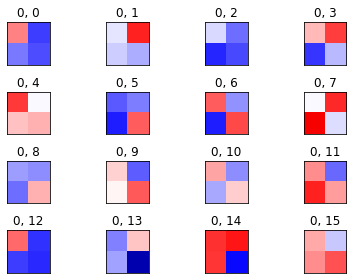

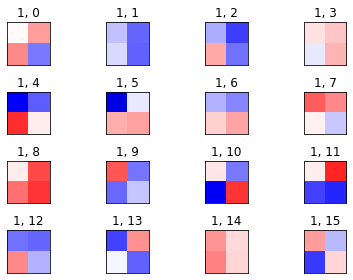

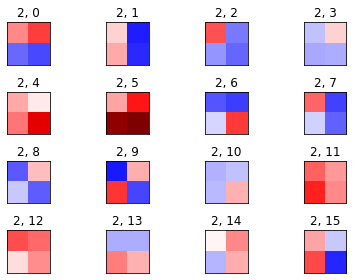

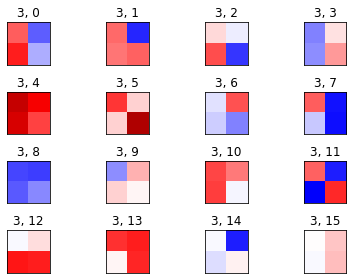

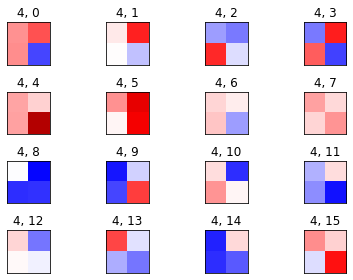

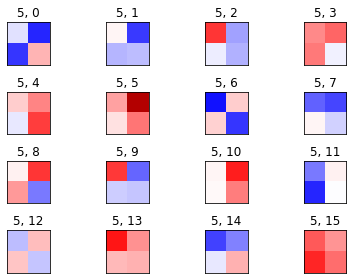

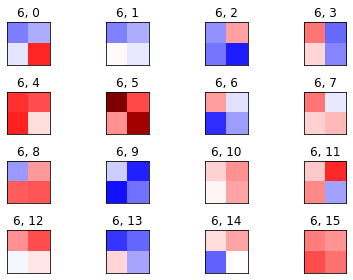

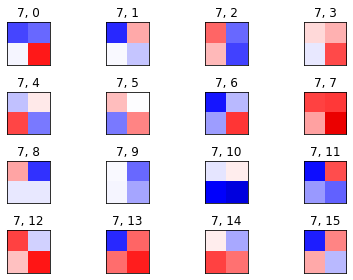

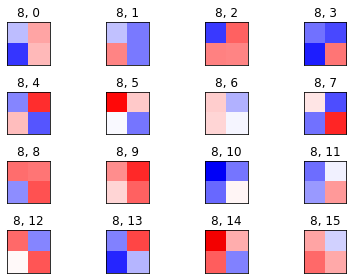

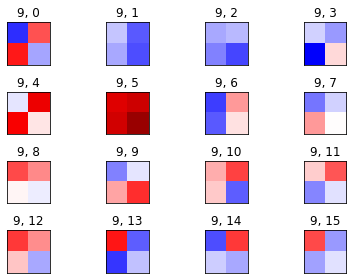

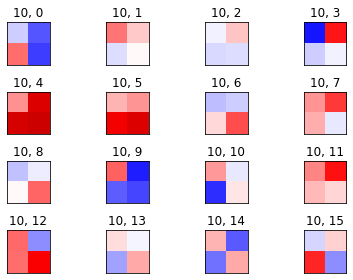

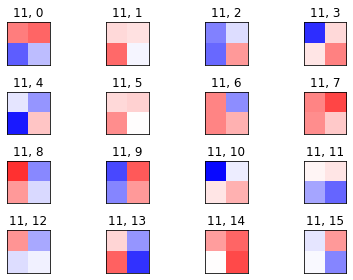

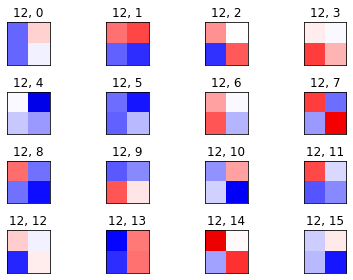

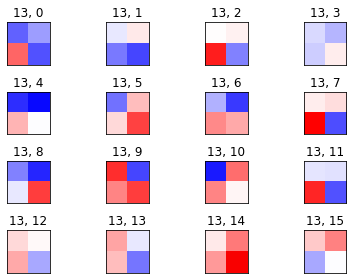

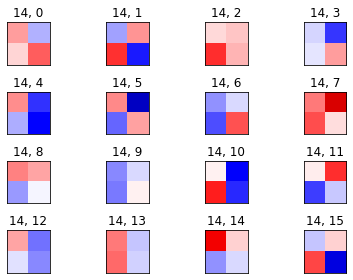

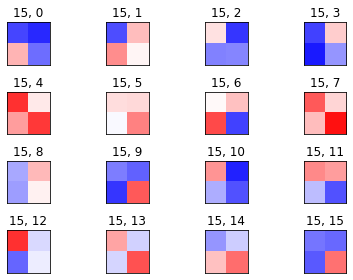

In [43]:
num_filters = conv_x2_kernel_np.shape[2]
channels = range(conv_x2_kernel_np.shape[2])
w_max = np.max(conv_x2_kernel_np)
w_min = np.min(conv_x2_kernel_np)

for channel in channels:
    # create figure and axes
    fig, axes = plt.subplots(4, 4)
    for idx, ax in enumerate(axes.flat):
        img = conv_x2_kernel_np[:, :, channel, idx]
        _ = ax.imshow(img, vmin=w_min, vmax=w_max, 
                      interpolation='nearest', cmap='seismic')
        _ = ax.set_xticks([])
        _ = ax.set_yticks([])
        _ = ax.set_title(f'{channel}, {idx}')
    fig.tight_layout()

In [ ]:

# iterate channels
for channel in channels:
    # iterate filters inside every channel
    for l, ax in enumerate(axes.flat):
        # get a single filter
        img = weights[:, :, channel, l]
        # put it on the grid
        ax.imshow(img, vmin=w_min, vmax=w_max, interpolation='nearest', cmap='seismic')
        # remove any labels from the axes
        ax.set_xticks([])
        ax.set_yticks([])
    # save figure
    plt.savefig(os.path.join(plot_dir, '{}-{}.png'.format(name, channel)), bbox_inches='tight')

[]

[]

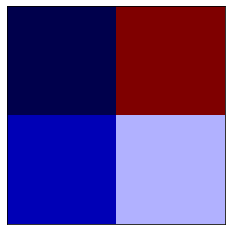

In [29]:
w0 = conv_x1_kernel_np[:, :, 0]
w_min = np.min(w0)
w_max = np.max(w0)

fig, ax = plt.subplots()
_ = ax.imshow(conv_x1_kernel_np[:, :, 0], vmin=w_min, vmax=w_max, 
          interpolation='nearest', cmap='seismic')
# remove any labels from the axes
_ = ax.set_xticks([])
_ = ax.set_yticks([])

In [ ]:
model.dynamics.position_fn.dense

In [39]:
import pickle

with open(model.files['parameters_pkl_file'], 'wb') as f:
    pickle.dump(model.params, f)

In [ ]:
model.sess.graph.collections

In [ ]:
model.sess.graph.get_collection

In [ ]:
model.dynamics.position_fn.summary()

In [ ]:
# Iterate over samples history and calculate observables for each sample.
# `lattice.calc_plaq_observables(samples)` calculates observables for each of
# the samples in the mini-batch.
actions_history = []
avg_plaquettes_history = []
top_charges_history = []
for idx, samples in enumerate(samples_history):
    t0 = time.time()
    observables = np.array(model.lattice.calc_plaq_observables(samples))
    actions, plaqs, charges = observables
    
    actions_history.append(actions)
    avg_plaquettes_history.append(plaqs)
    top_charges_history.append(charges)
    
    print(f'step: {idx}  '
          f'time / step: {time.time() - t0:^6.4g}  '
          f'avg action: {np.mean(actions):^6.4g}  '
          f'avg plaquette: {np.mean(plaqs):^6.4g} '
          f'top charge: {np.mean(charges):^6.4g}')

In [ ]:
_ = helpers.plot_run_data(model.data, 
                          model.params, 
                          model.steps_arr, 
                          model.figs_dir, 
                          skip_steps=1)

In [ ]:
#tf.reset_default_graph()
#model = GaugeModel(params=params,
#                   config=None,
#                   sess=None,
#                   conv_net=False,
#                   hmc=False,
#                   log_dir='../../gauge_logs_graph/run_25',
#                   restore=True)

In [ ]:
samples = np.random.randn(*model.samples.shape)
samples_history = []

In [ ]:
for i in range(500):
    t0 = time.time()
    samples = model.sess.run(model.x_out, feed_dict={model.x: samples})
    samples_history.append(samples)
    print(f'step: {i:^6.4g} time/step: {time.time() - t0:^6.4g}')

In [ ]:
samples_history_conv = np.array(samples_history_conv)
print(samples_history_conv.shape)

In [ ]:
import pickle
samples_history_file = os.path.join(model.info_dir, 'samples_history.pkl')
with open(samples_history_file, 'wb') as f:
    pickle.dump(samples_history_conv, f)